In [10]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
    confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import joblib

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [3]:
# Function to calculate and print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Function to calculate and print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'encoded_labels']).size().unstack(fill_value=0)
    class_counts = class_counts.reset_index()
    class_counts['island'] = class_counts['image_name'].apply(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df


In [4]:
# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before applying class weights
print_class_distribution(train_df, "Training Before Class Weights")
print_class_distribution(test_df, "Test")


Training Before Class Weights Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10



Class Distribution Before Class Weights:
                       Class  Pixel Count
encoded_labels                           
0                 freshwater        32201
1                        ice       240185
2                      ocean       623431
3                       rock        74284
4               walrus_mixed          657
5                walrus_pure           38


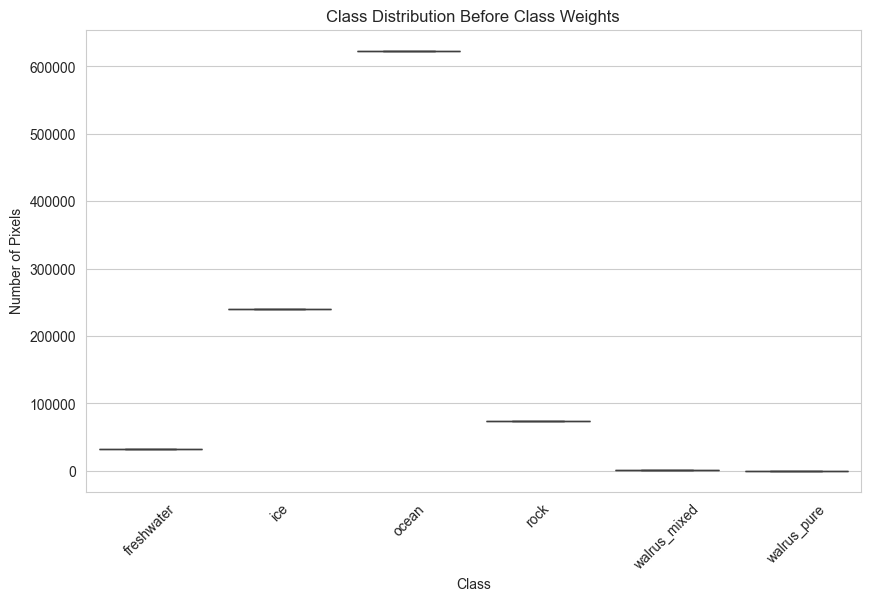

In [5]:
# Class distribution table and boxplot before applying class weights
class_counts_before_weights = train_df['encoded_labels'].value_counts().sort_index()
class_names_before_weights = le.inverse_transform(class_counts_before_weights.index)
distribution_df_before_weights = pd.DataFrame({'Class': class_names_before_weights, 'Pixel Count': class_counts_before_weights})

print("\nClass Distribution Before Class Weights:")
print(distribution_df_before_weights)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Pixel Count', data=distribution_df_before_weights)
plt.title('Class Distribution Before Class Weights')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Pixels')
plt.show()

In [6]:
# Compute class weights to give more importance to minority classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [7]:
# Define models to try
models = []
models.append(('RF', RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)))
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))


In [8]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Function to plot predictions
def plot_predictions(predicted_images, title):
    # Define a color map for the labels
    label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}
    cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
    
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        # Create a color bar with fixed labels
        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

        # Highlight the labels present in the current image
        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

        plt.show()



Training and evaluating model: RF
Accuracy: 0.988772146683148
Precision: 0.9886750723403176
Recall: 0.988772146683148
F1 Score: 0.9885704076264737
Cohen's Kappa: 0.9783576099559044

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.92      0.87      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.97     18572
walrus_mixed       0.92      0.29      0.44       165
 walrus_pure       1.00      0.80      0.89        10

    accuracy                           0.99    242700
   macro avg       0.97      0.82      0.86    242700
weighted avg       0.99      0.99      0.99    242700


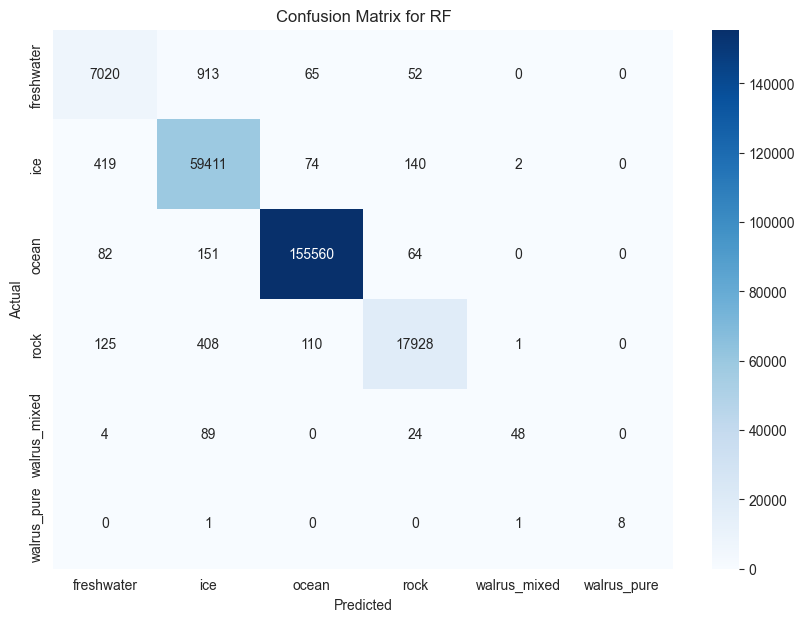

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


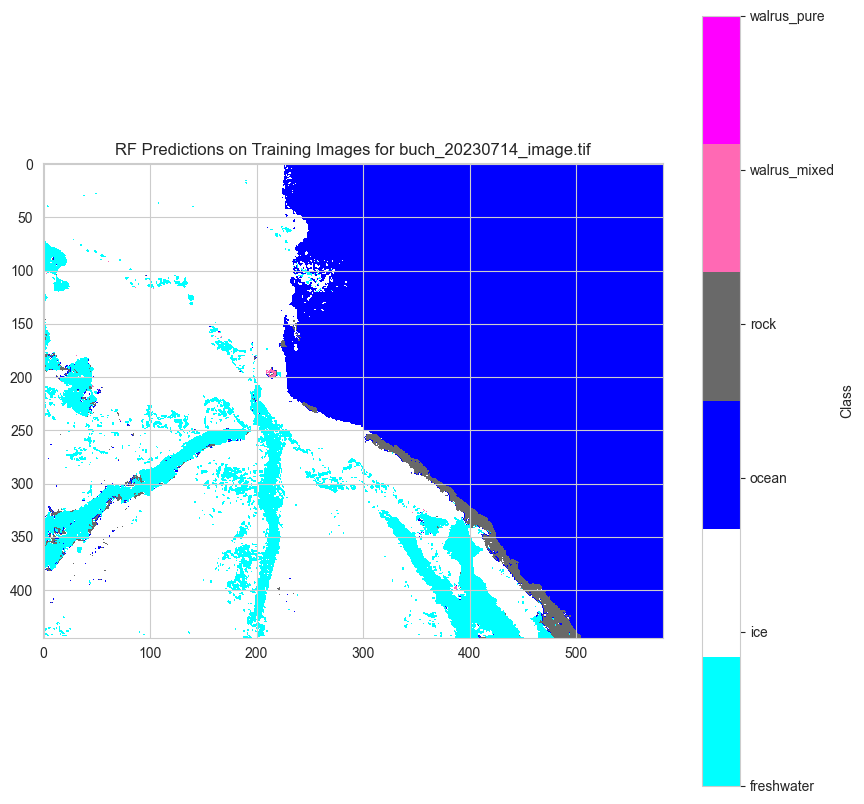

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


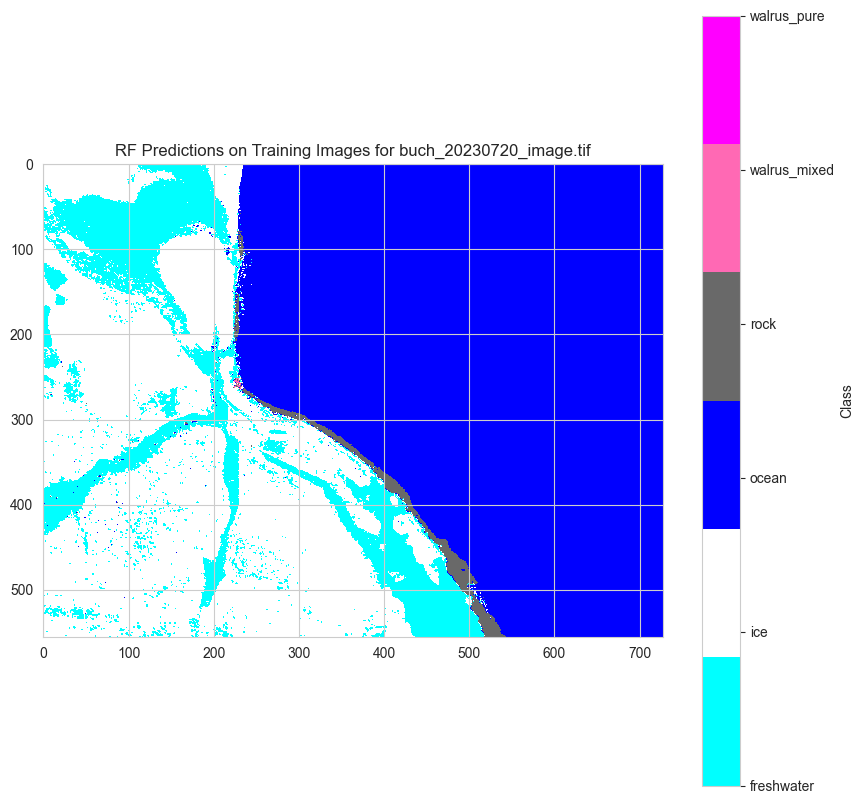

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


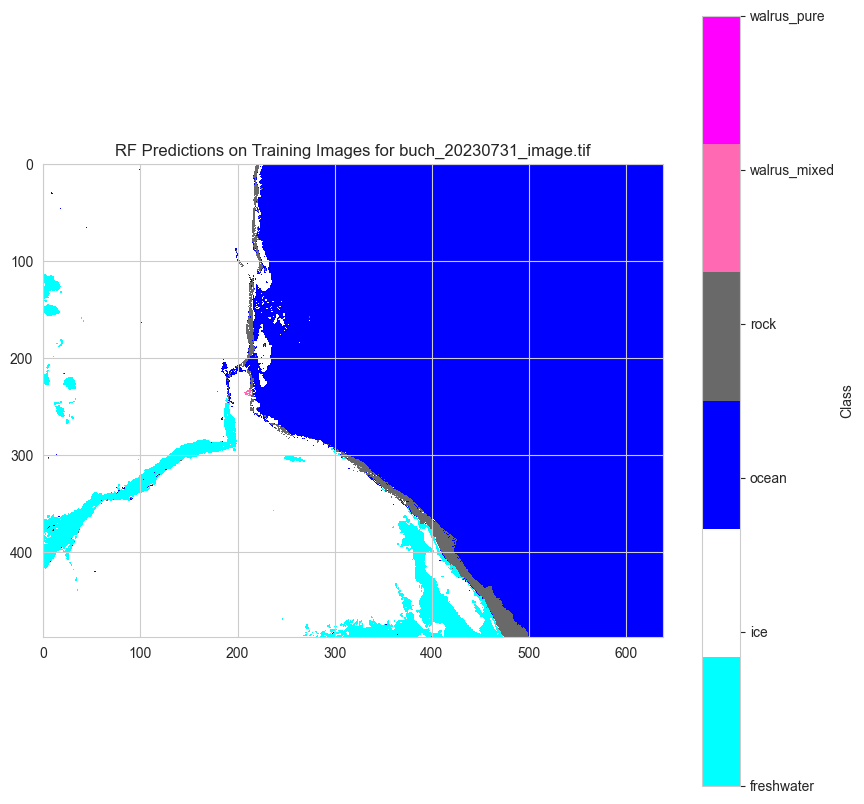

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


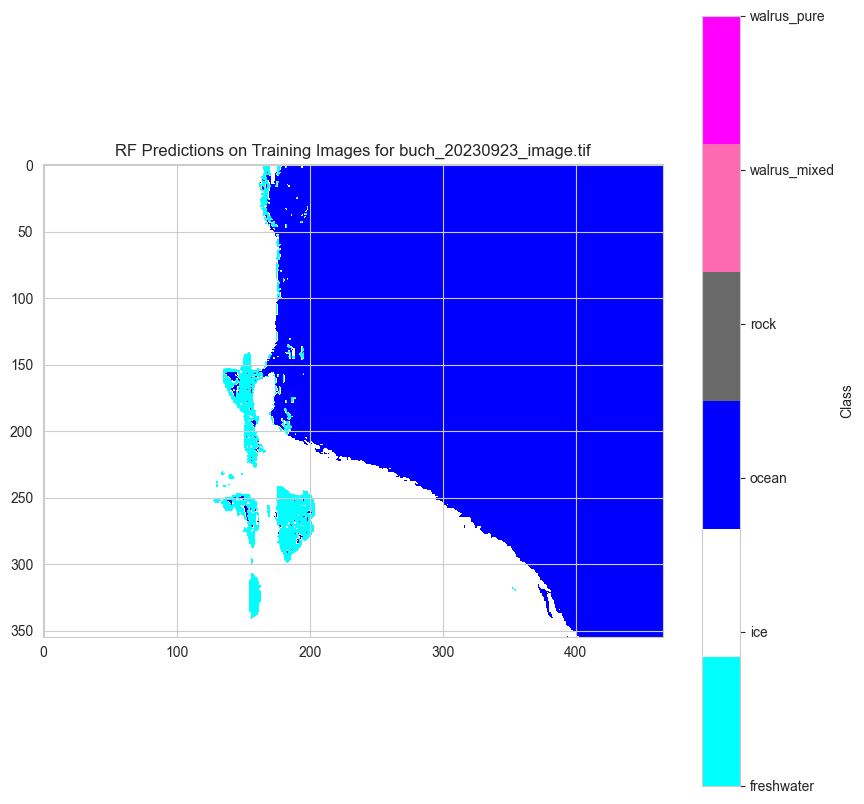

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


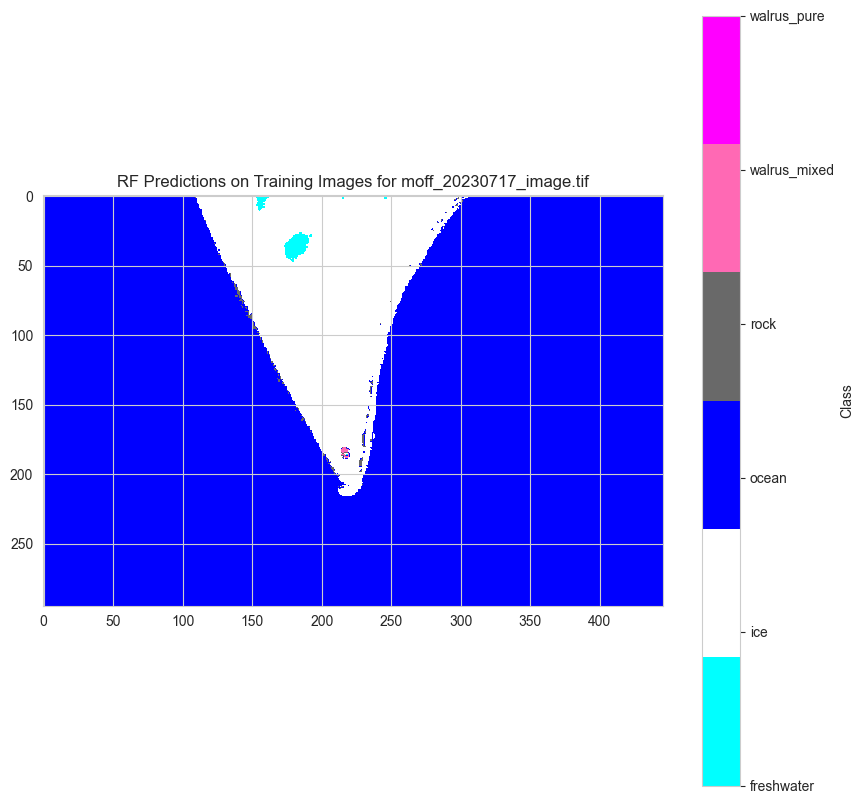

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


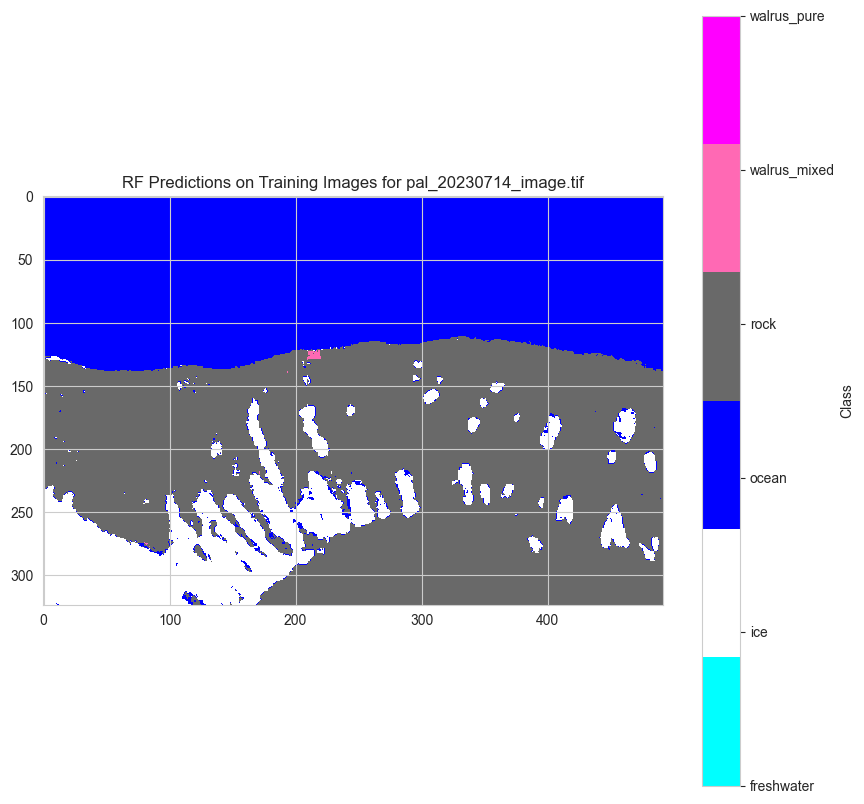

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


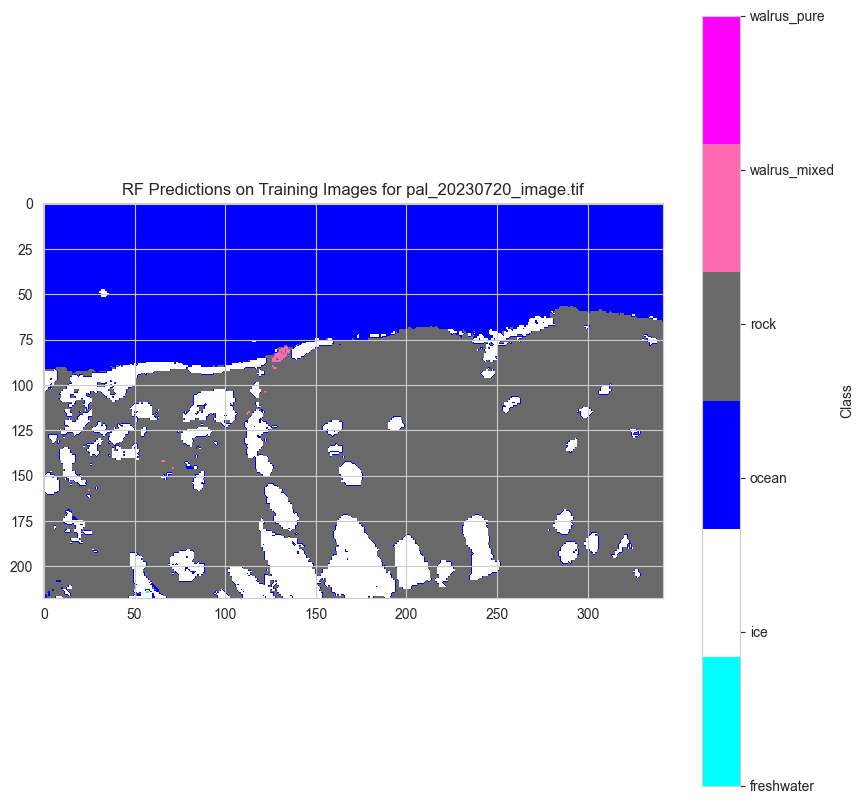

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


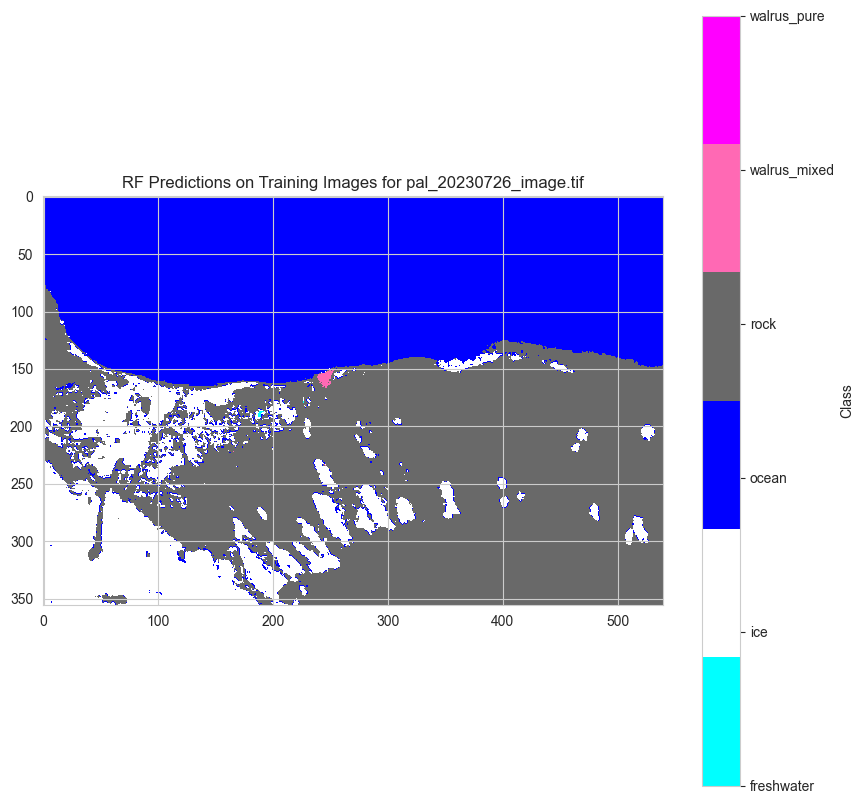

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


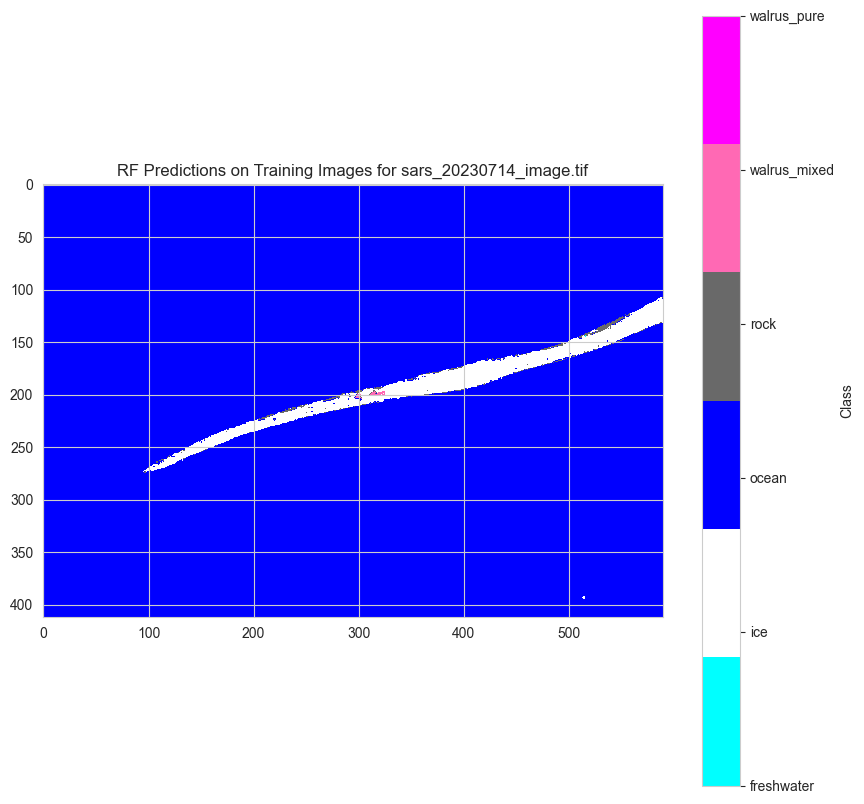

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


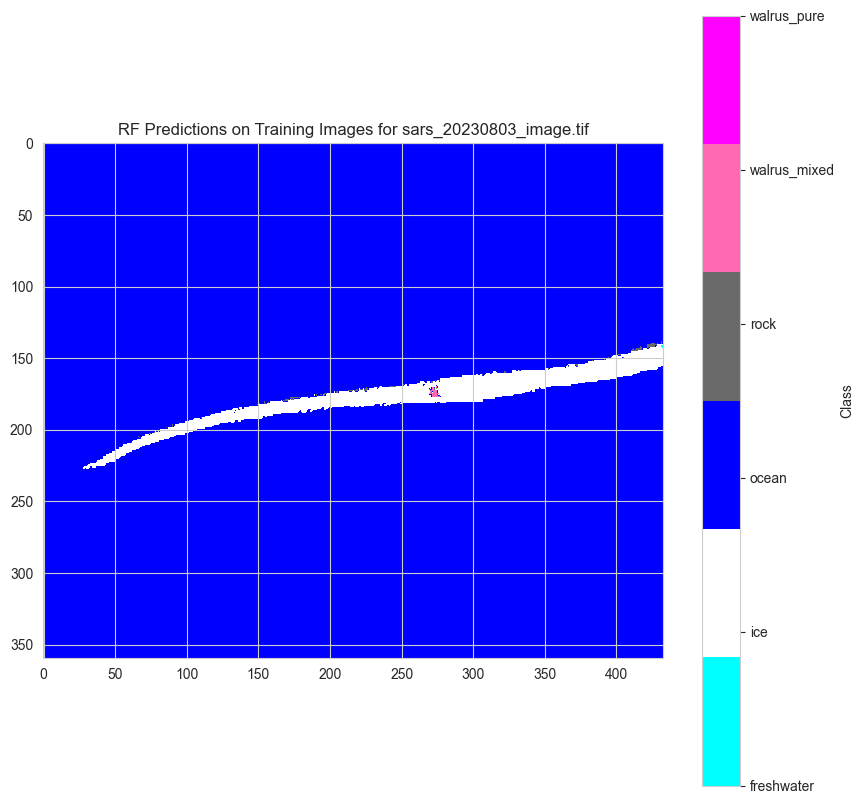

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


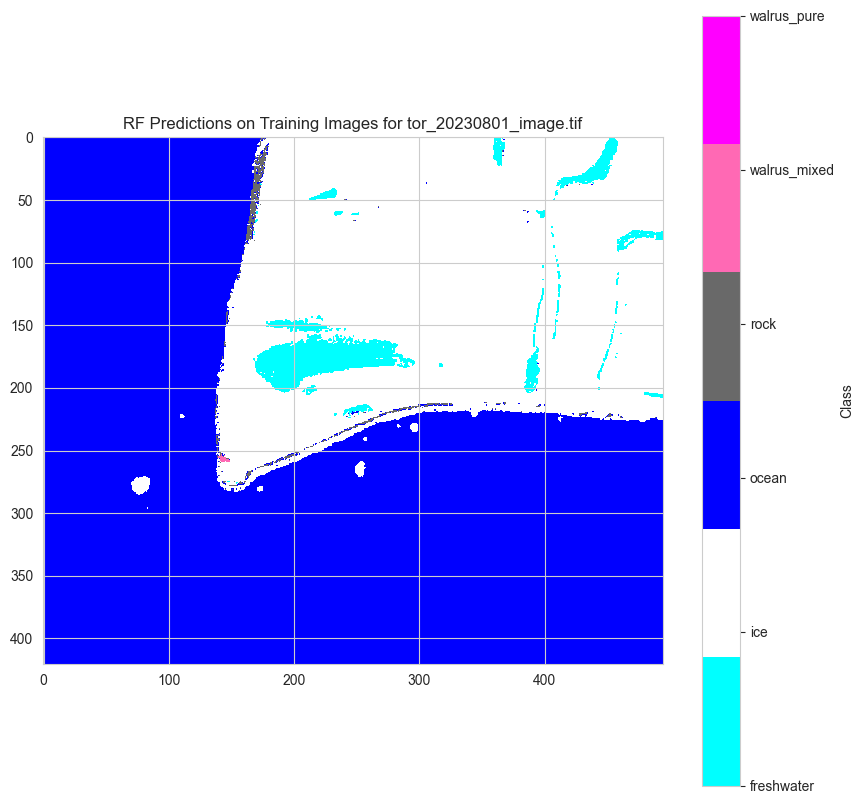

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


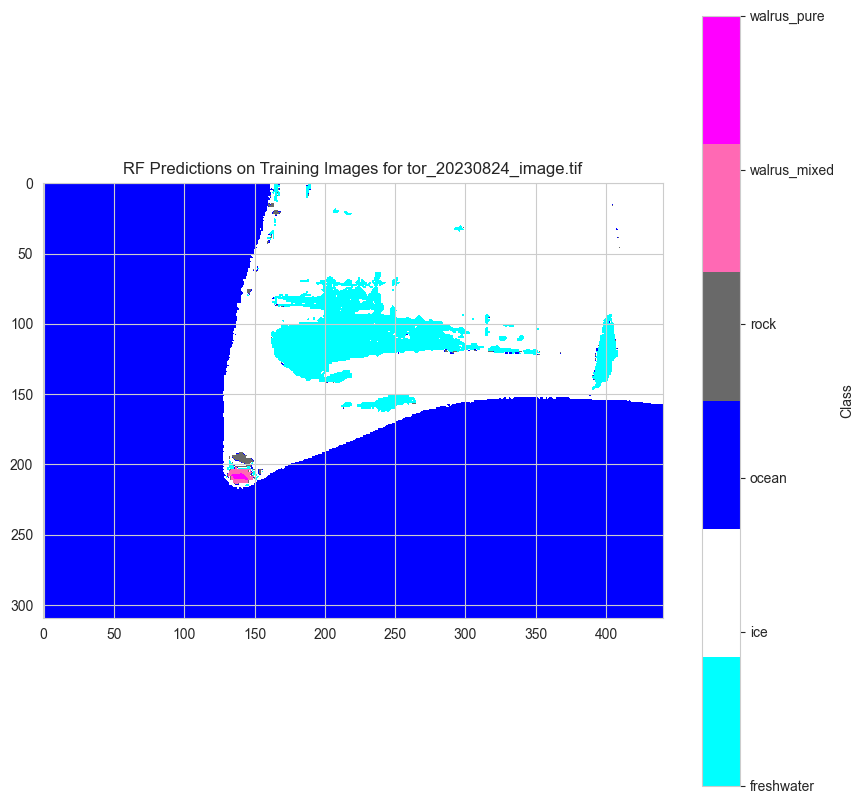

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


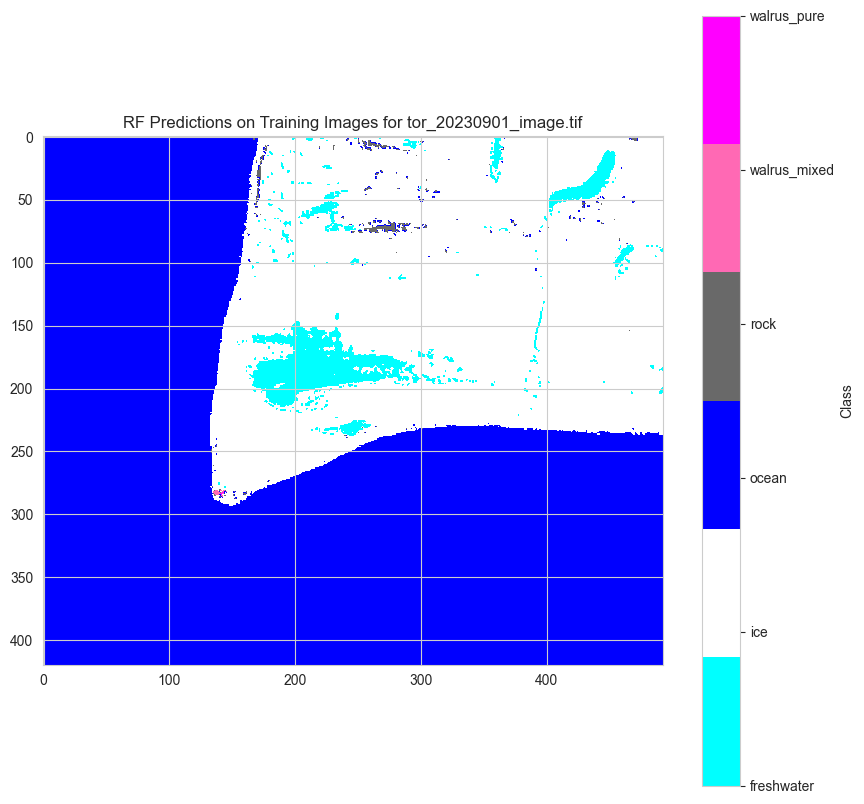

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


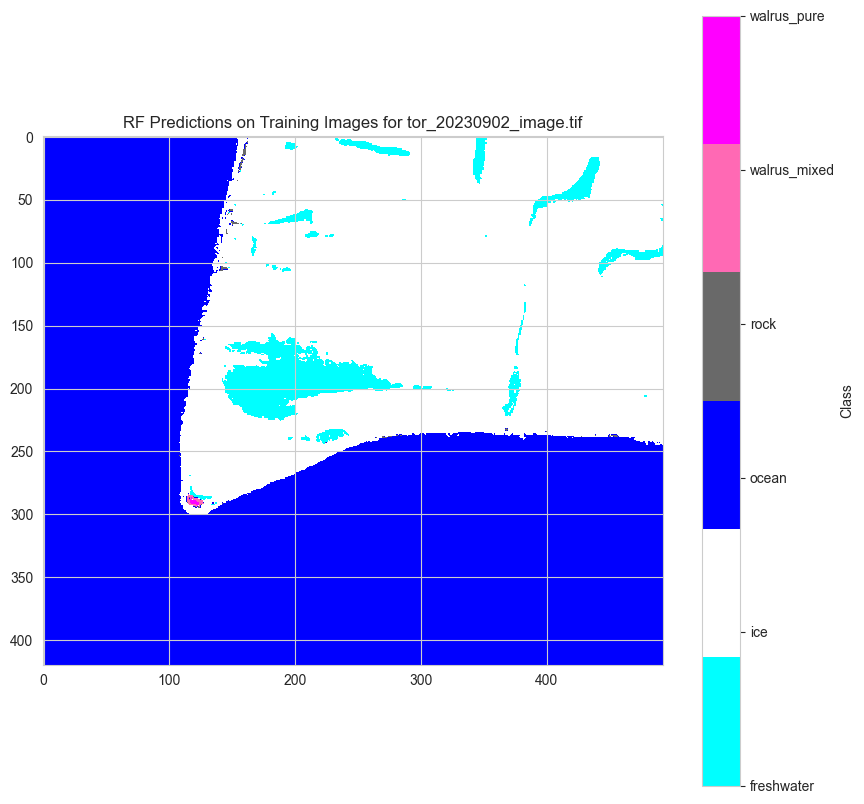

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


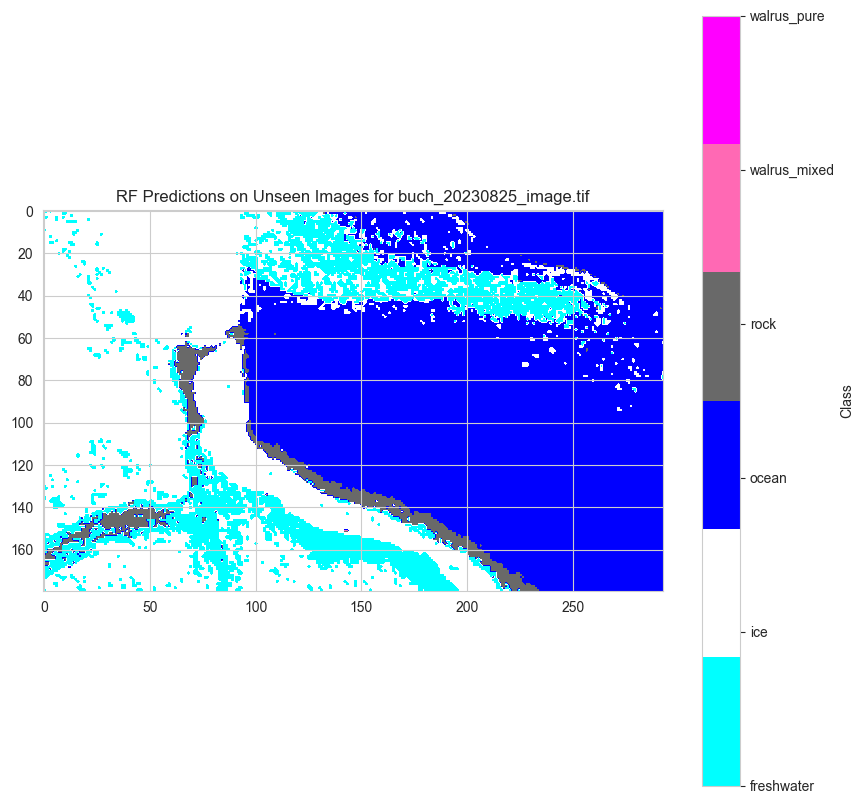

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


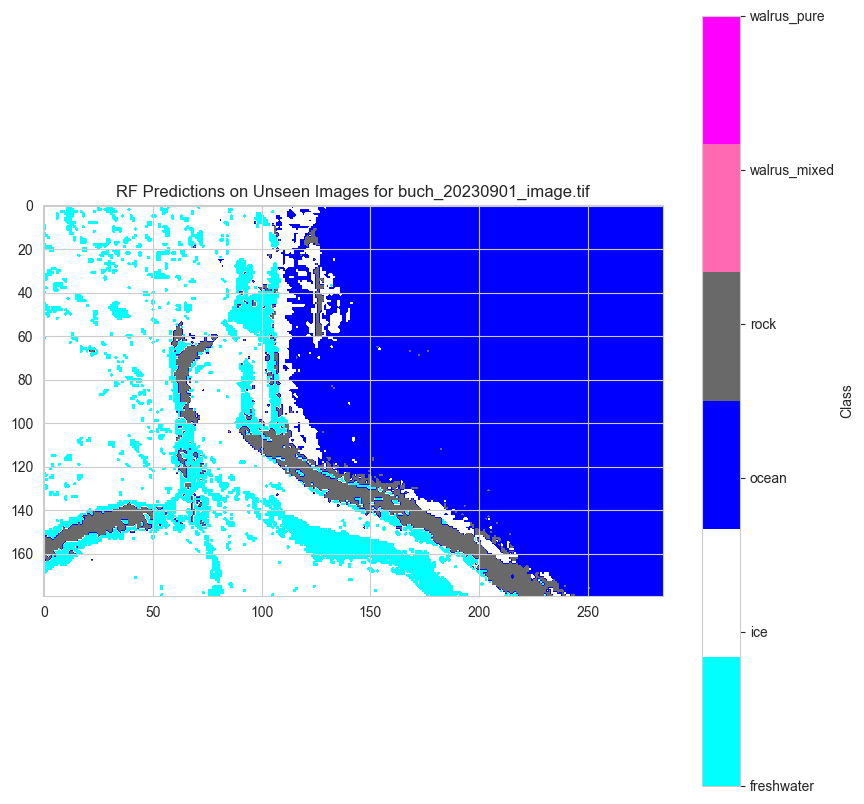

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


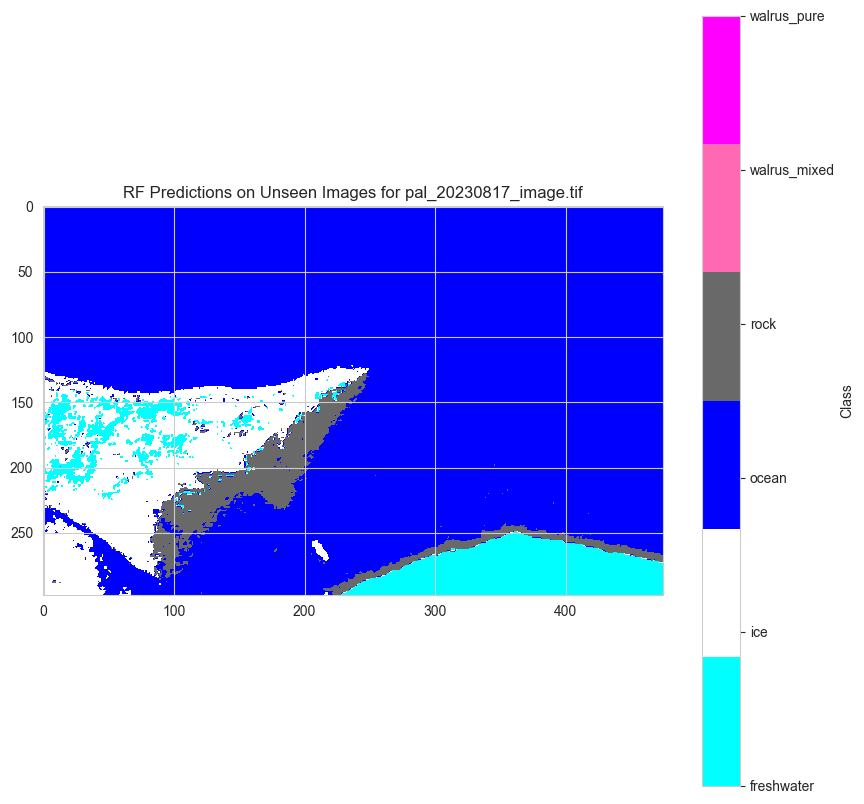

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


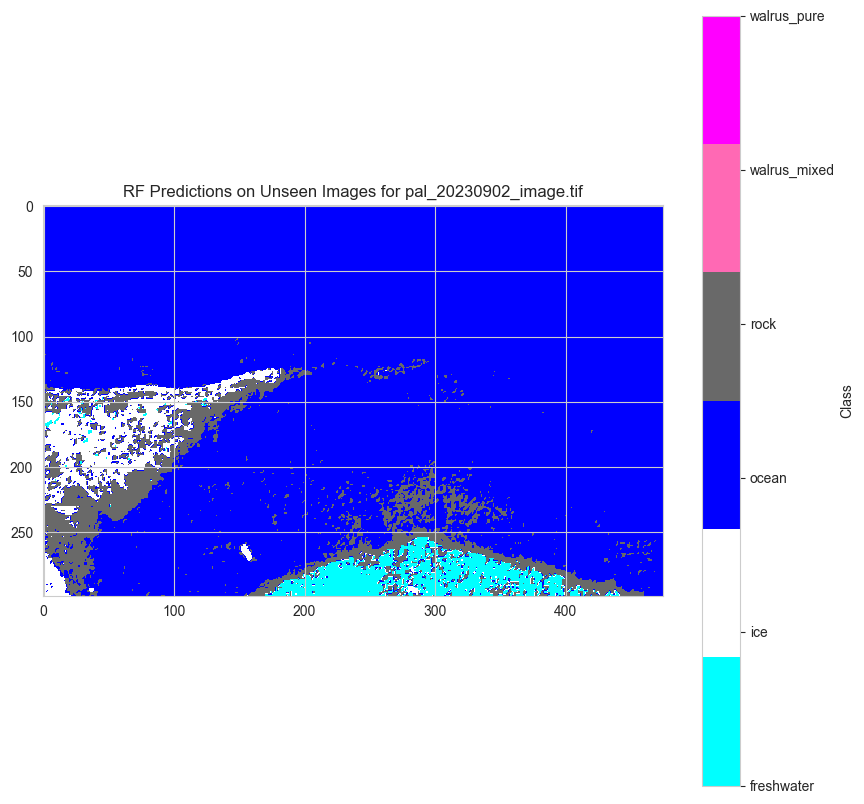

Labels present in sars_20230719_image.tif: ['ice', 'ocean', 'rock']


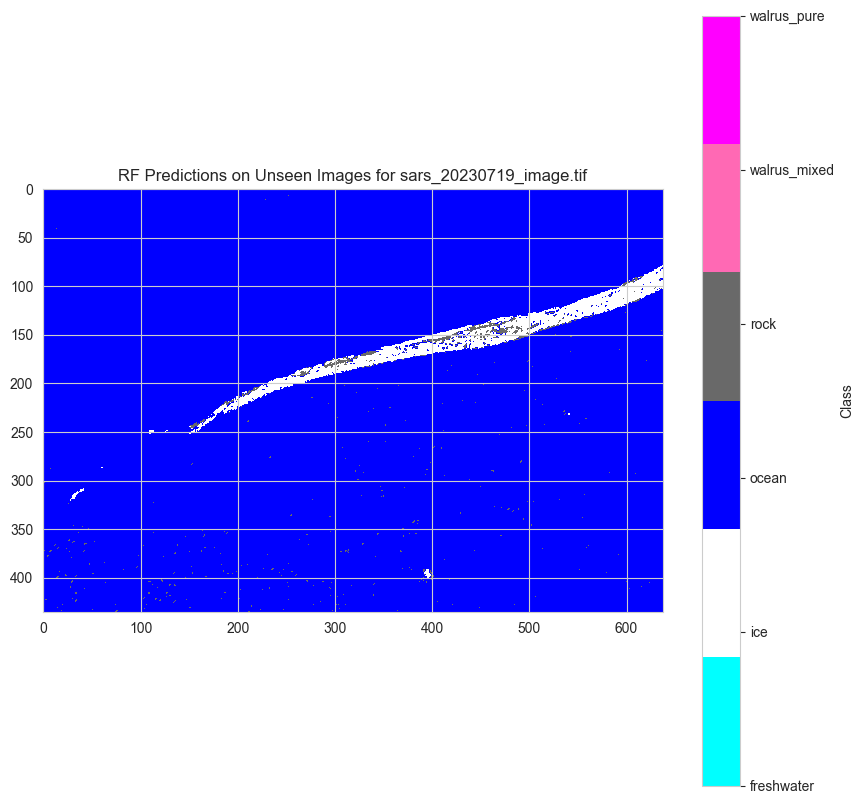

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


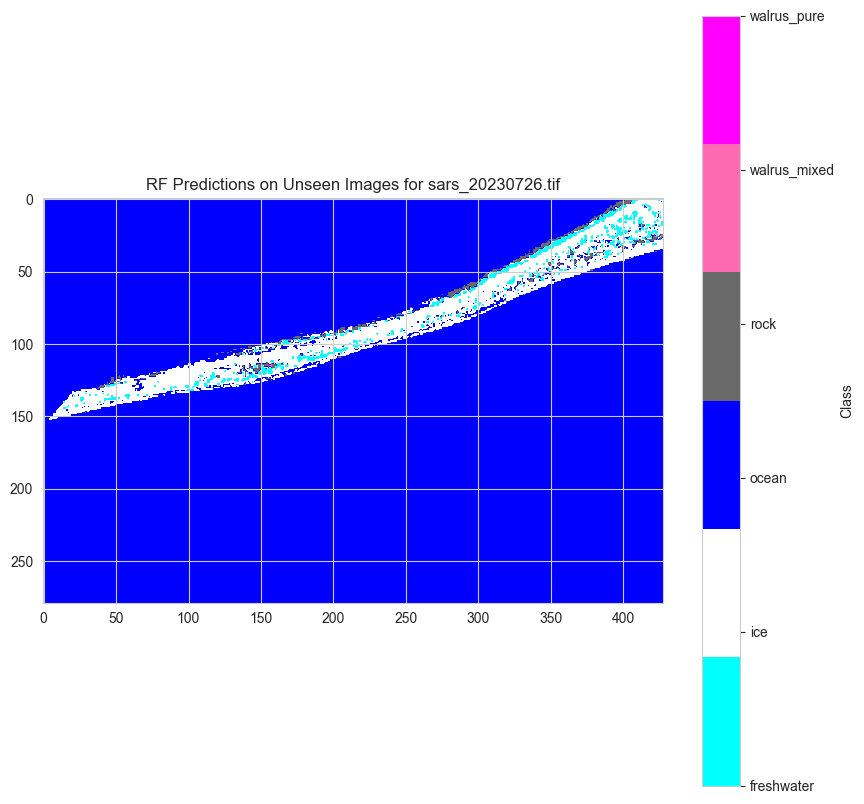

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


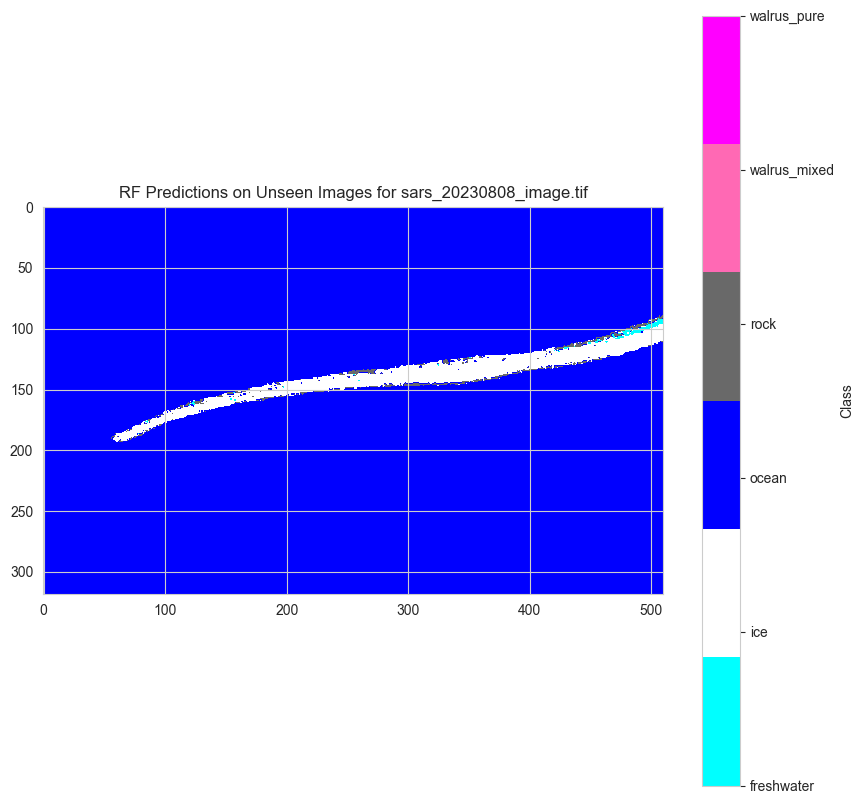

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


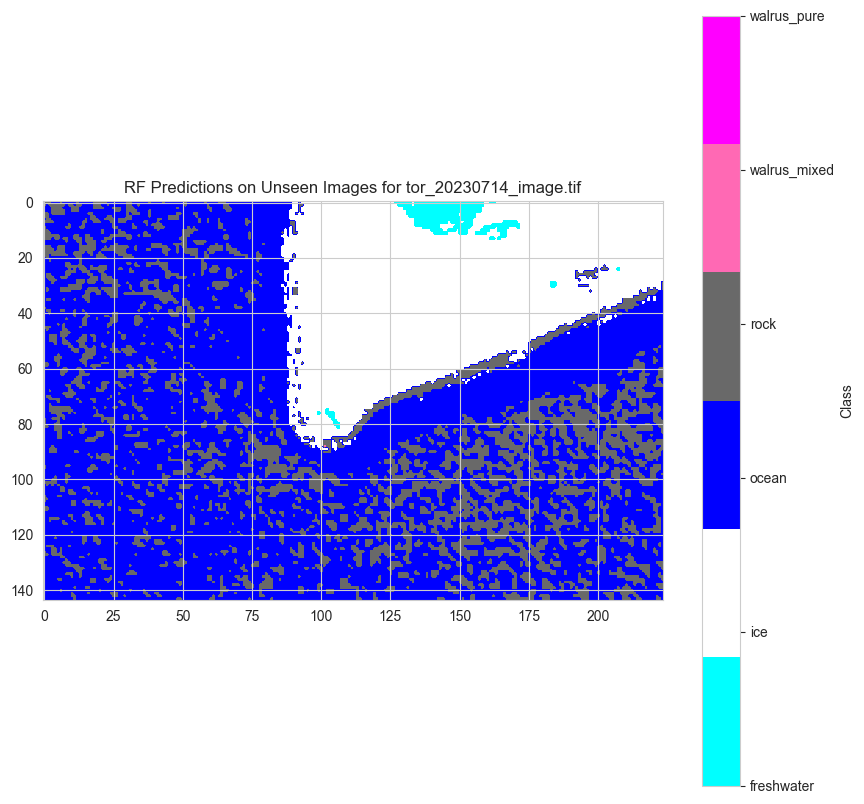

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


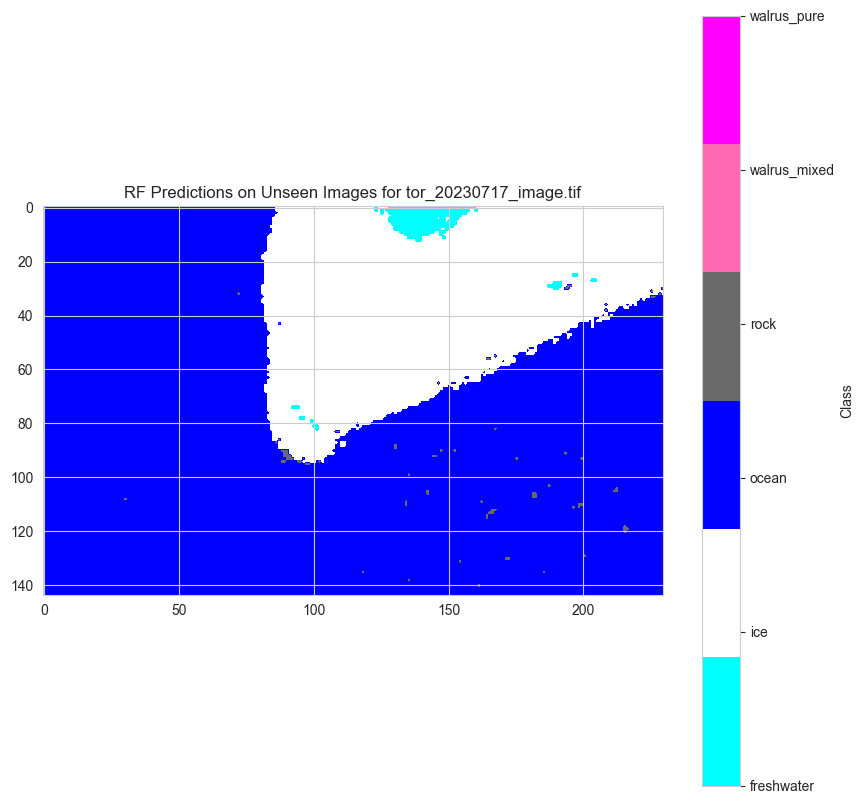

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


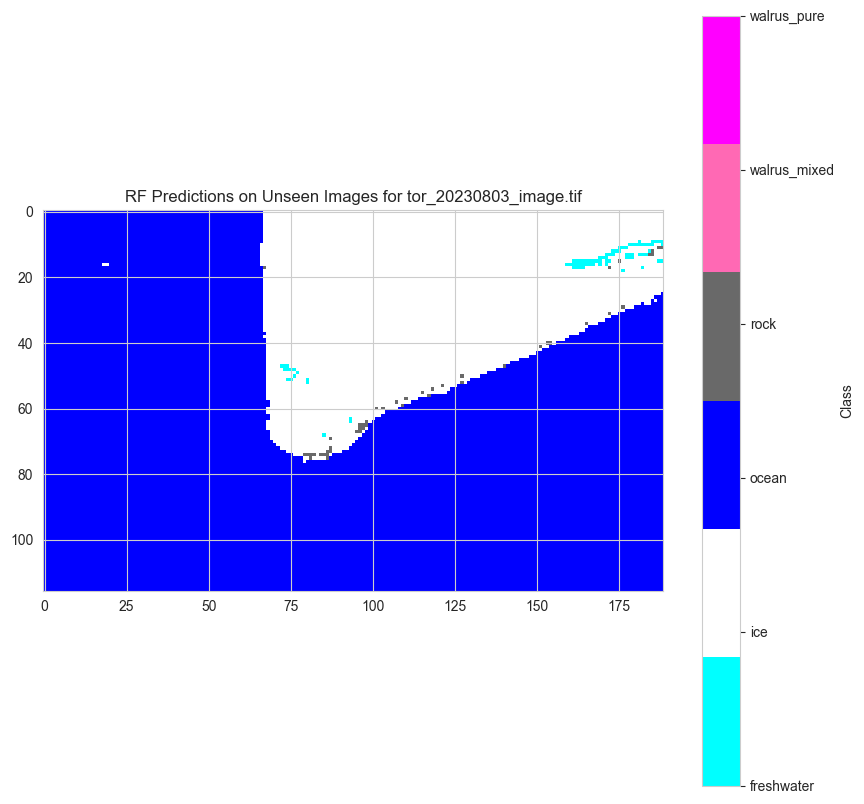

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


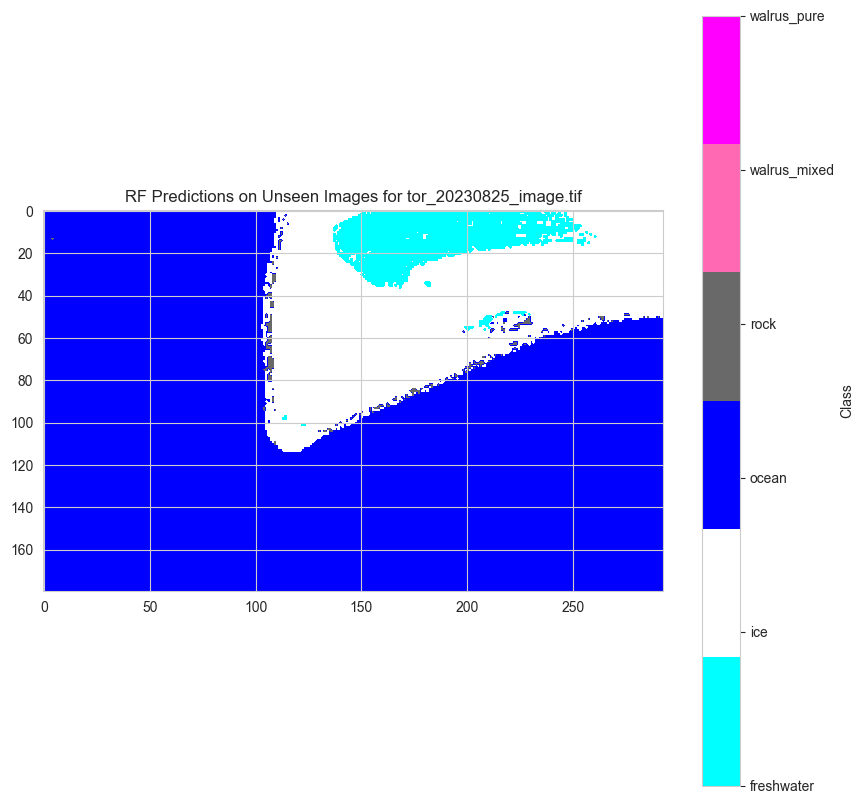

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


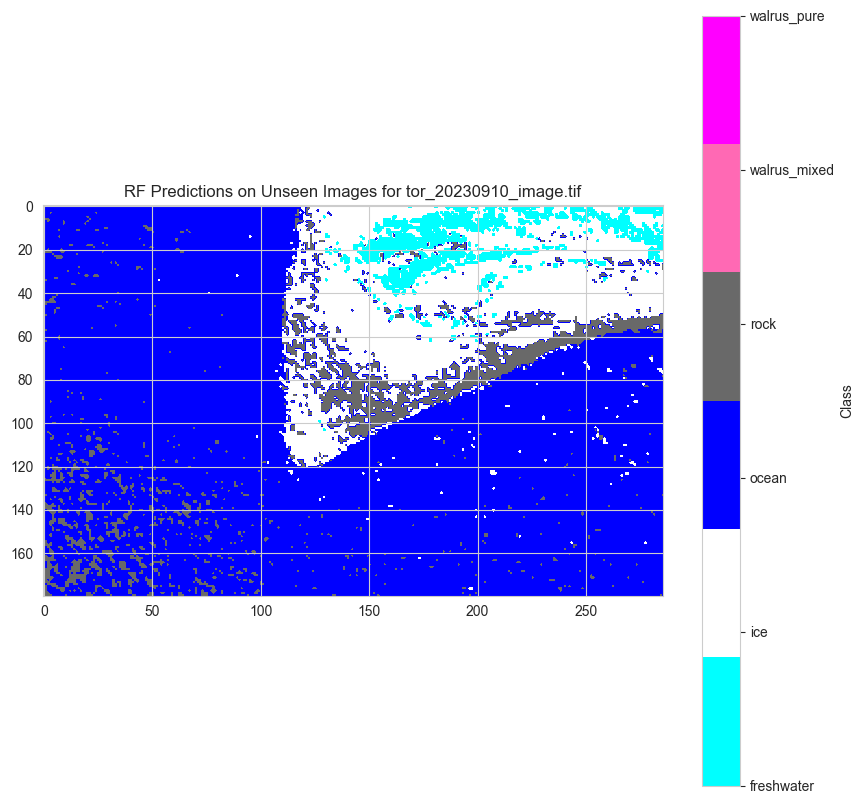


Training and evaluating model: LR


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9316275236918006
Precision: 0.926928767110949
Recall: 0.9316275236918006
F1 Score: 0.9259991688825725
Cohen's Kappa: 0.8671151266948515

Classification Report:


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

  freshwater       0.64      0.27      0.38      8050
         ice       0.85      0.95      0.90     60046
       ocean       0.98      0.98      0.98    155857
        rock       0.82      0.75      0.78     18572
walrus_mixed       0.00      0.00      0.00       165
 walrus_pure       0.67      0.40      0.50        10

    accuracy                           0.93    242700
   macro avg       0.66      0.56      0.59    242700
weighted avg       0.93      0.93      0.93    242700


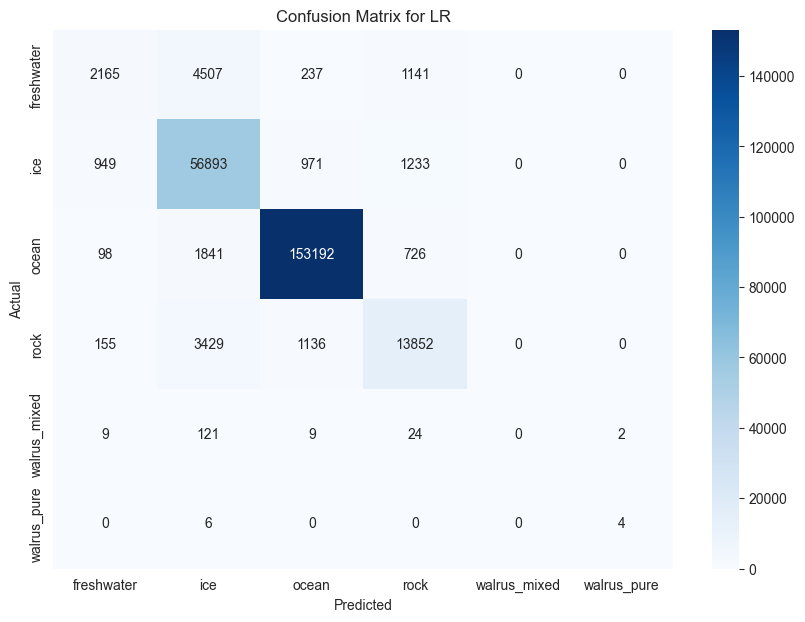

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


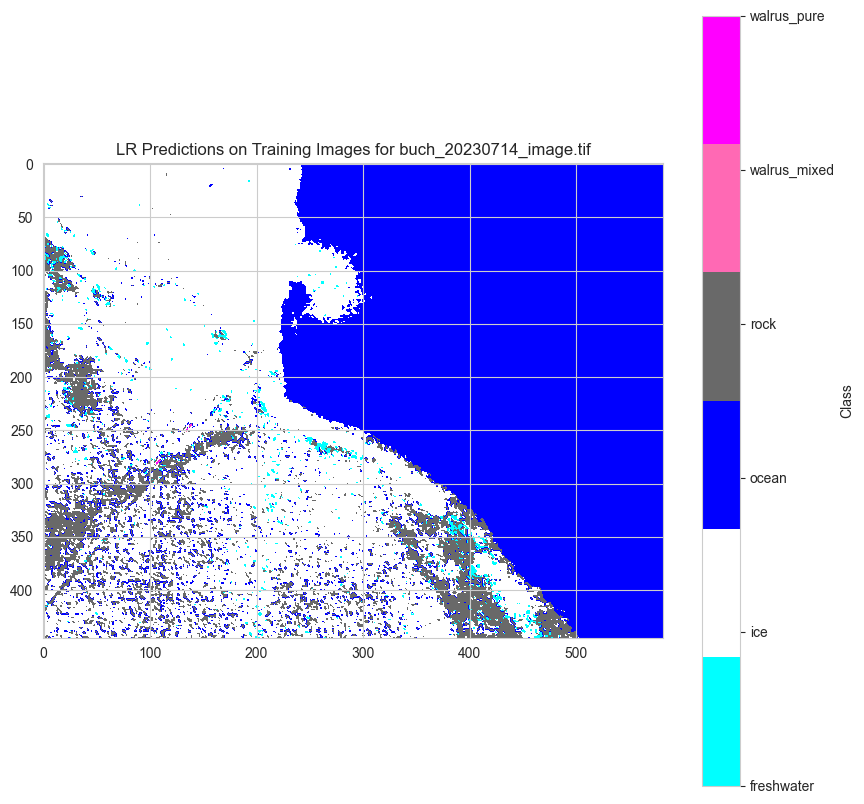

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


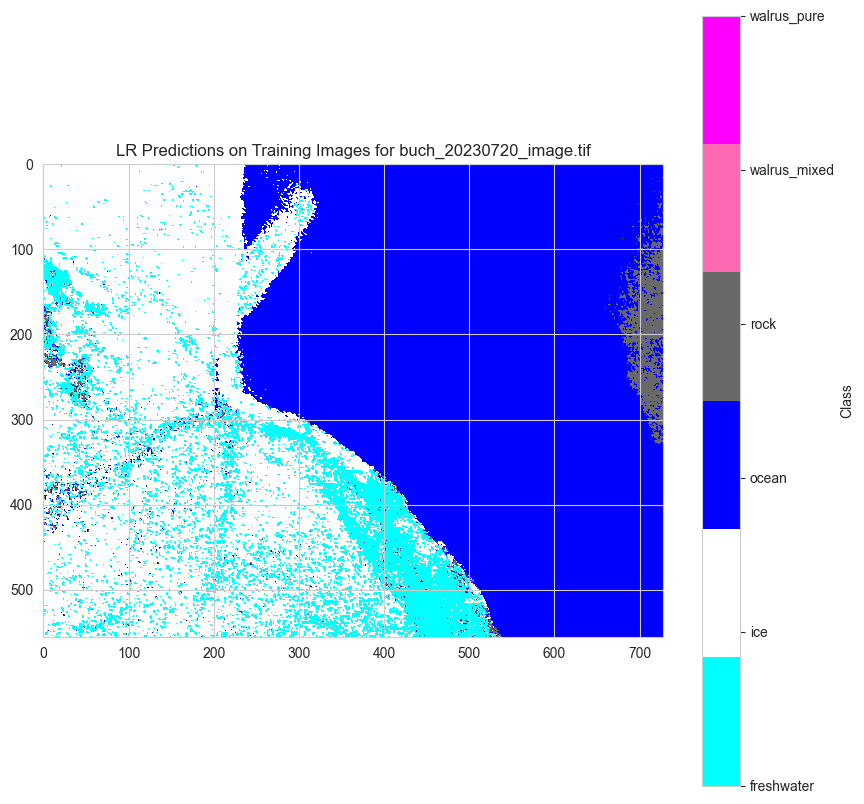

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


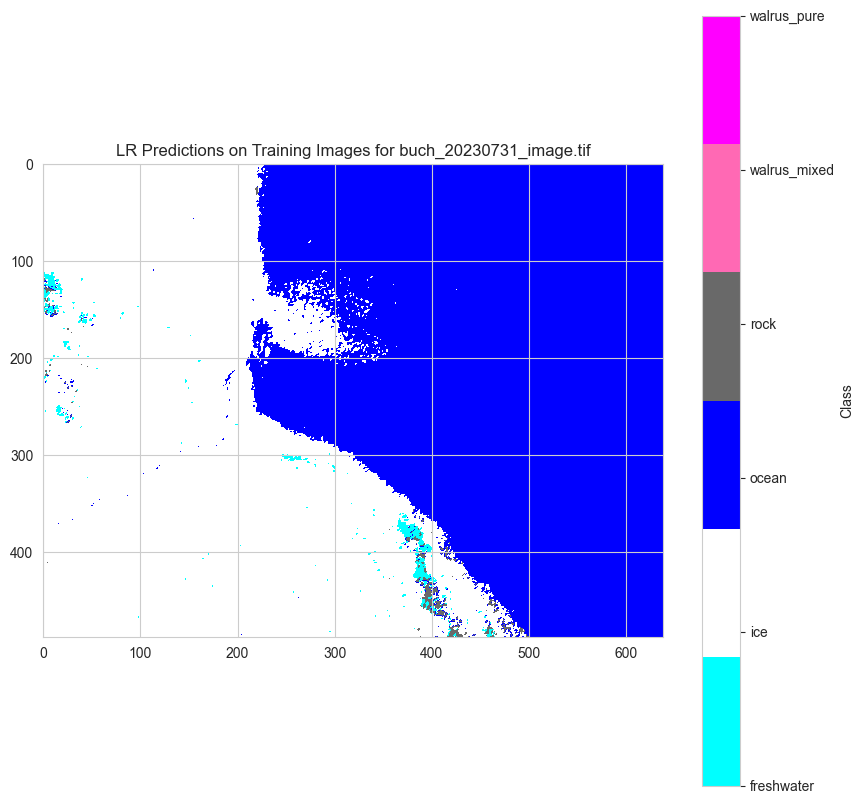

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


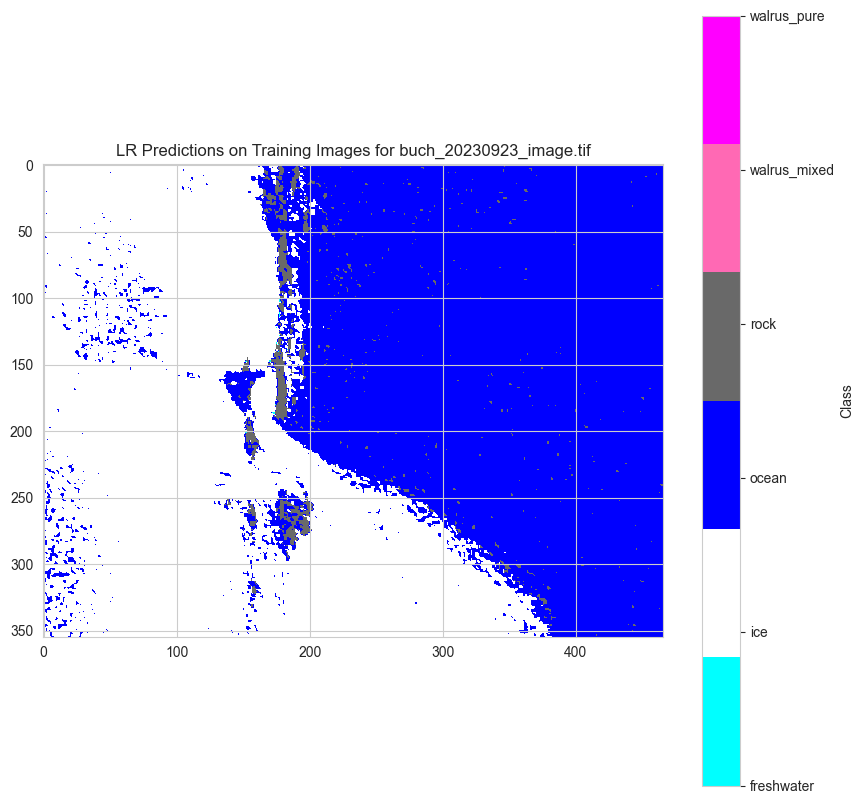

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


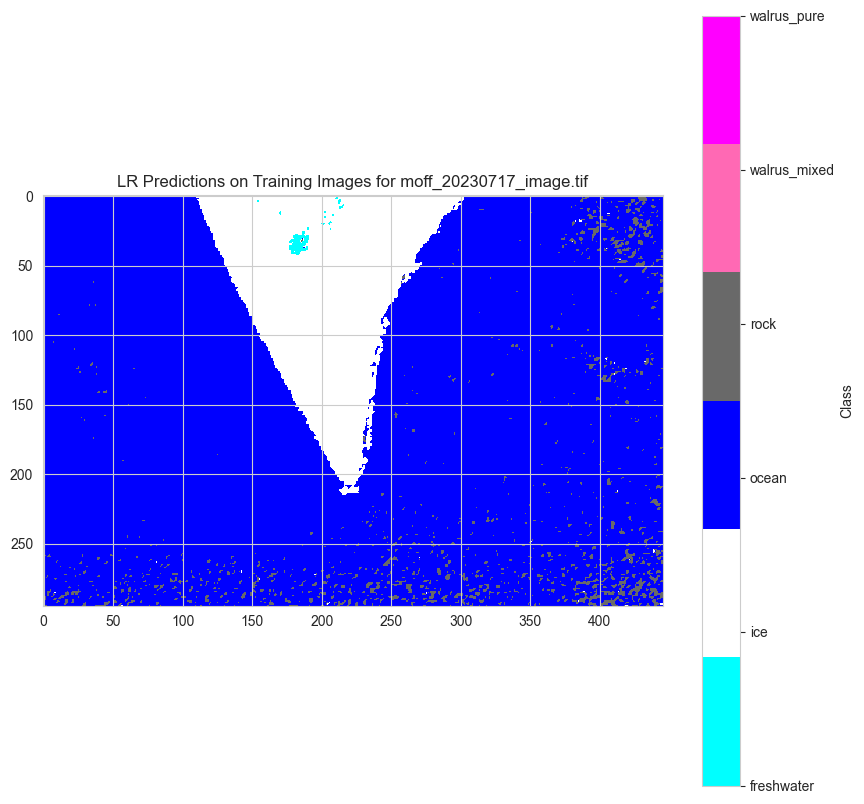

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


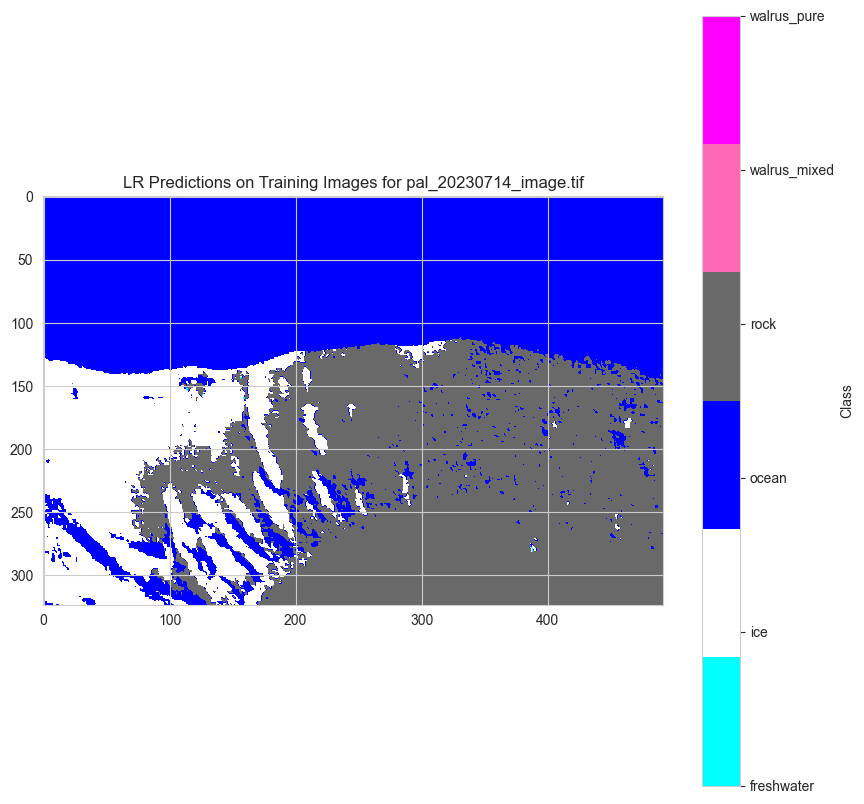

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


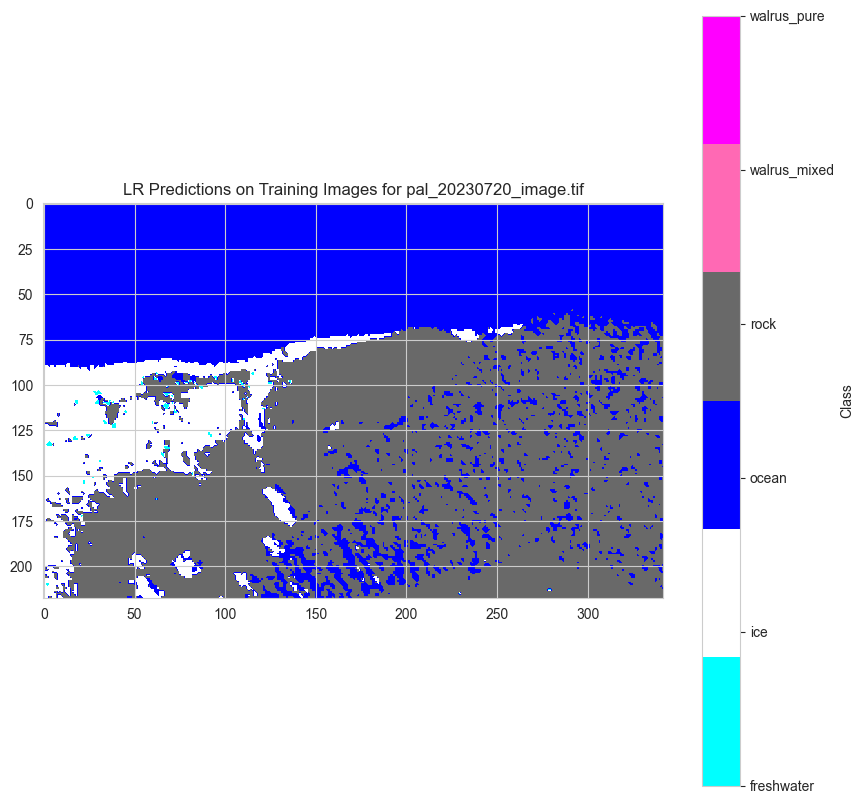

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


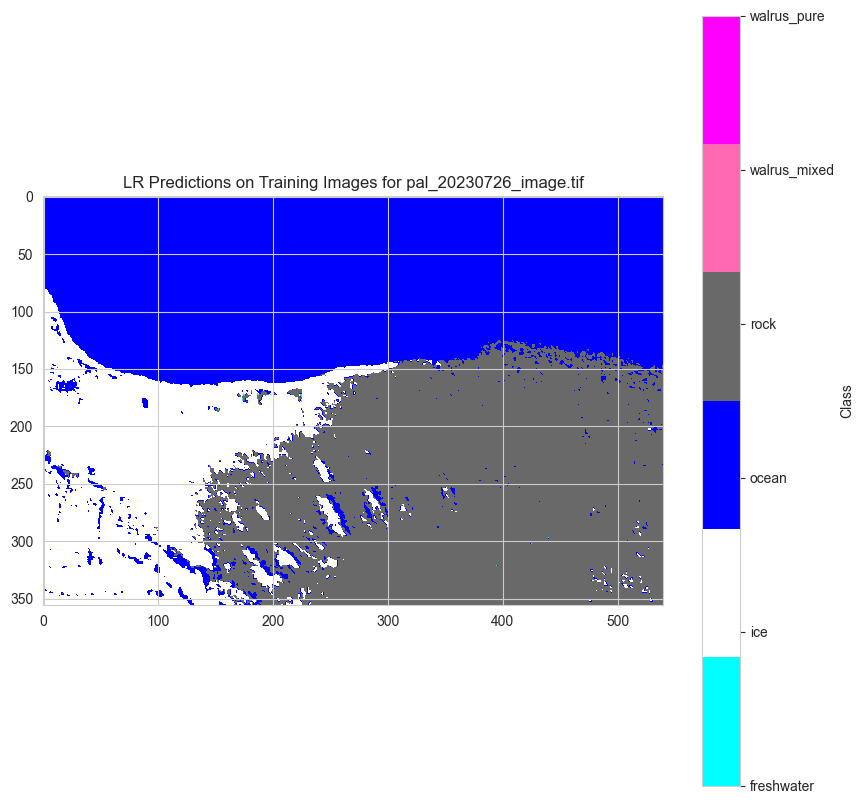

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


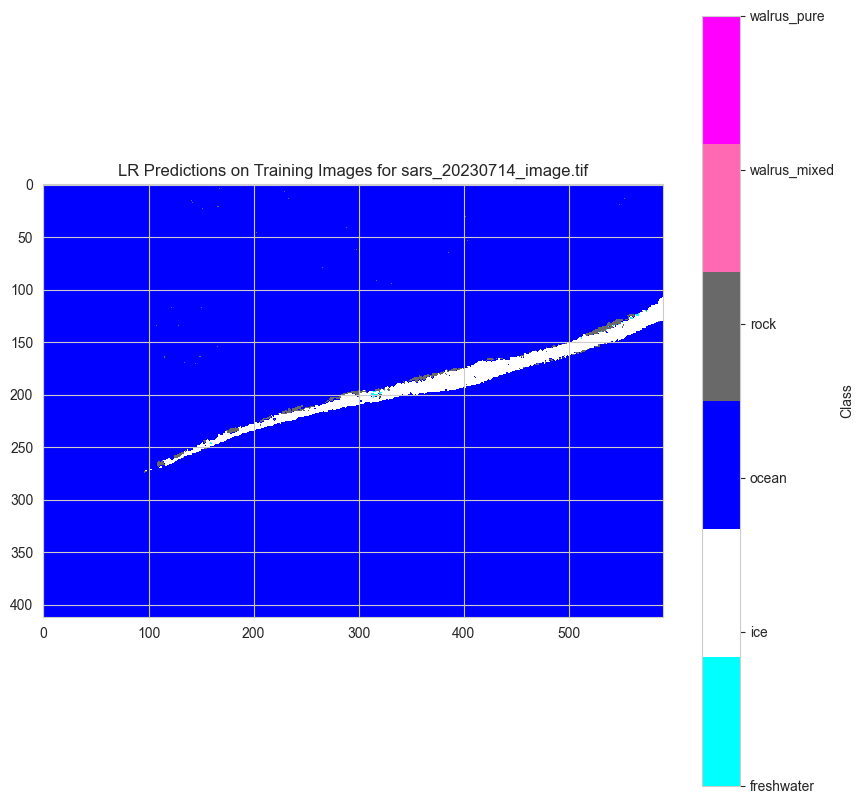

Labels present in sars_20230803_image.tif: ['ice', 'ocean', 'rock']


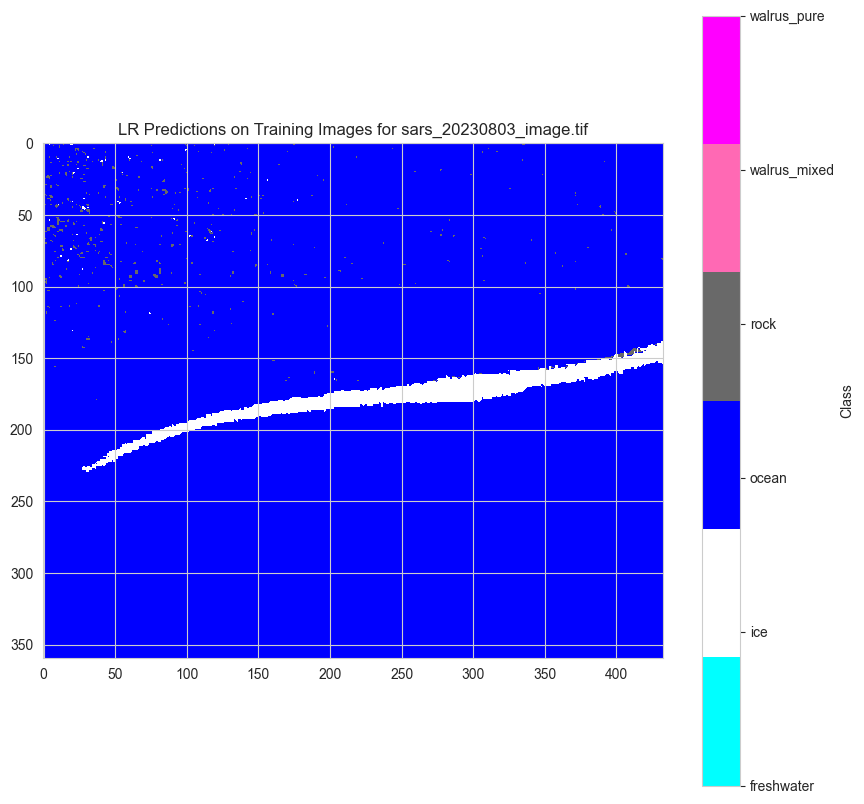

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


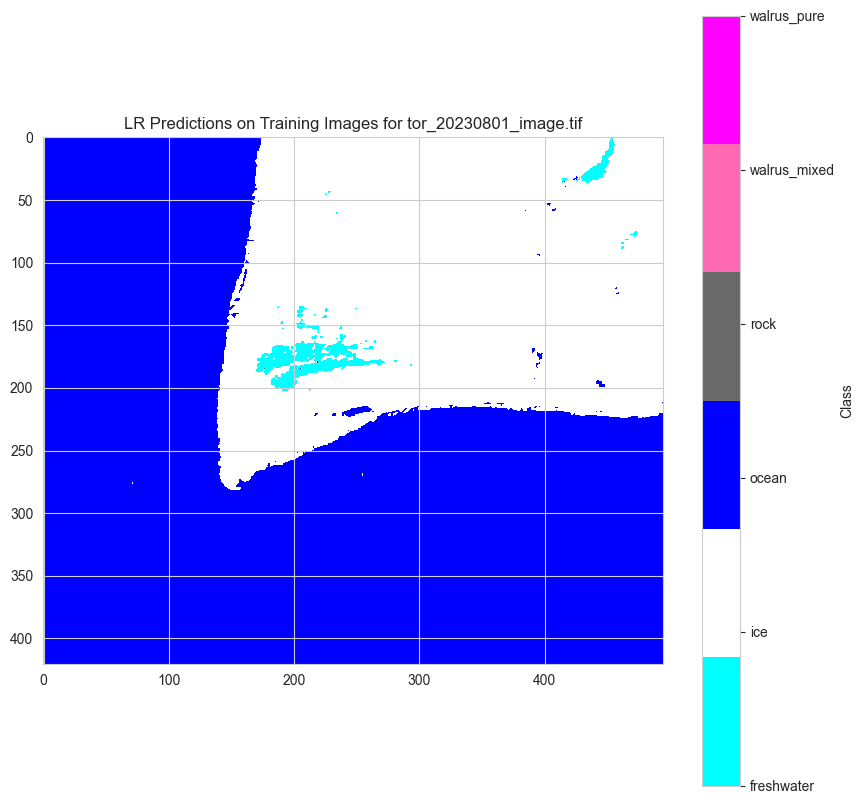

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_pure']


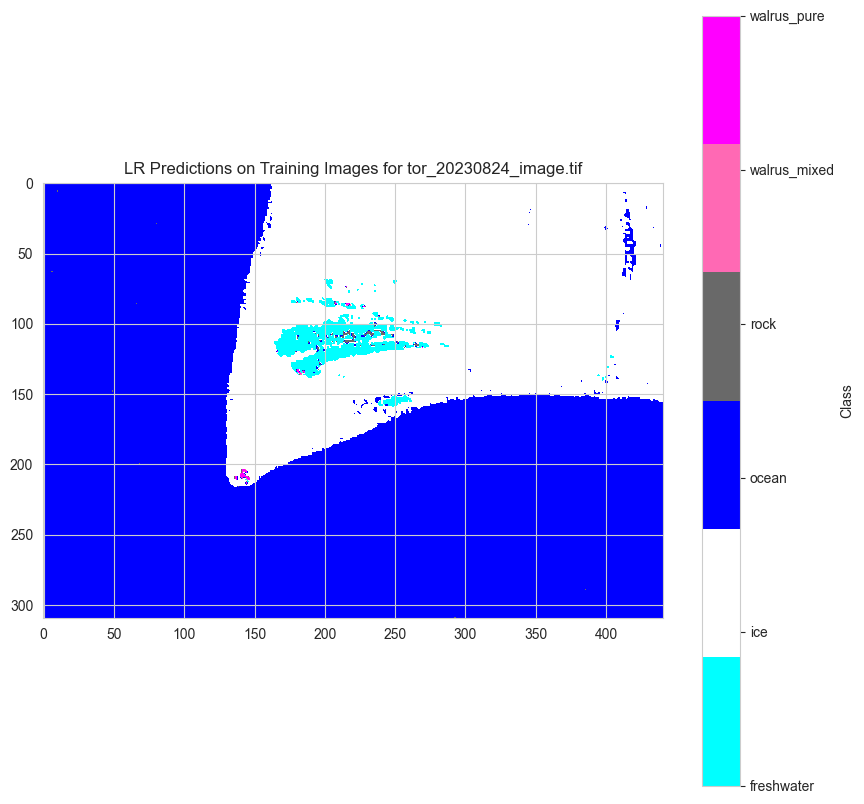

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


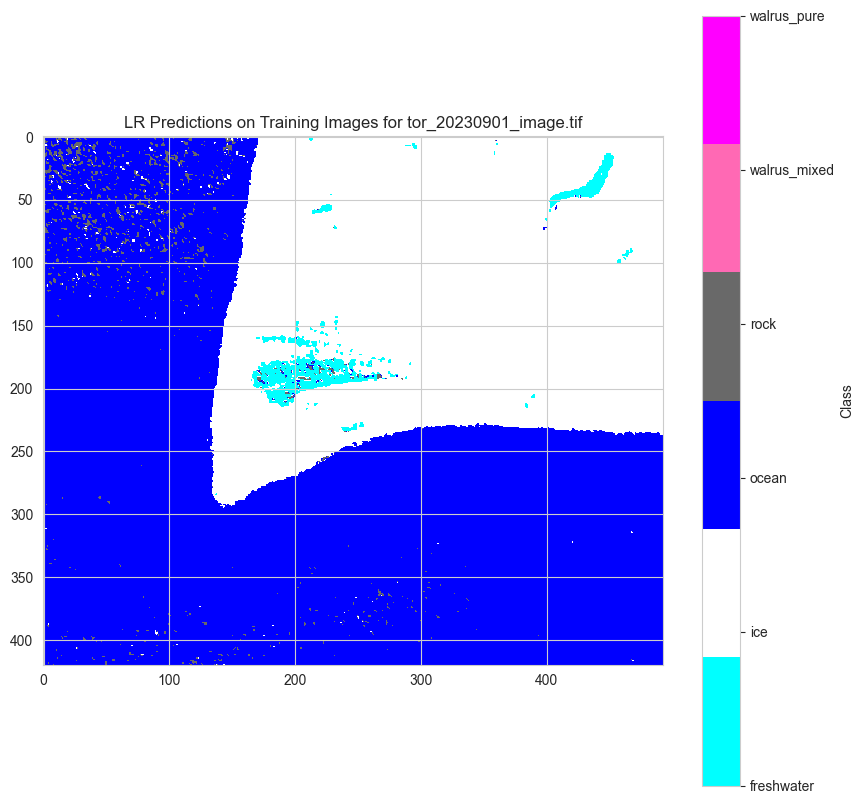

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


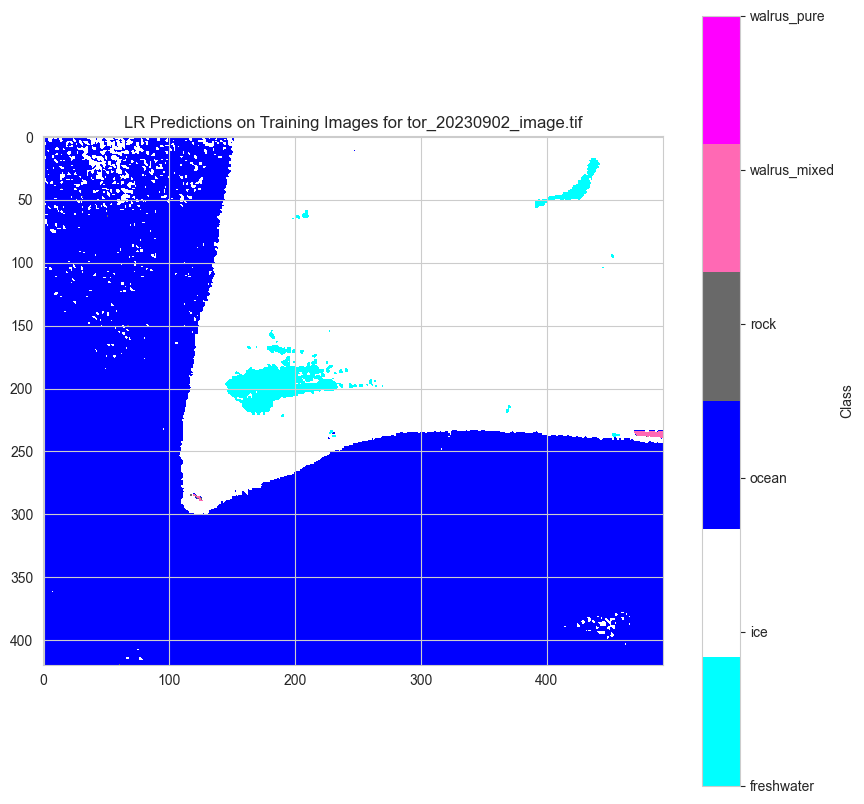

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


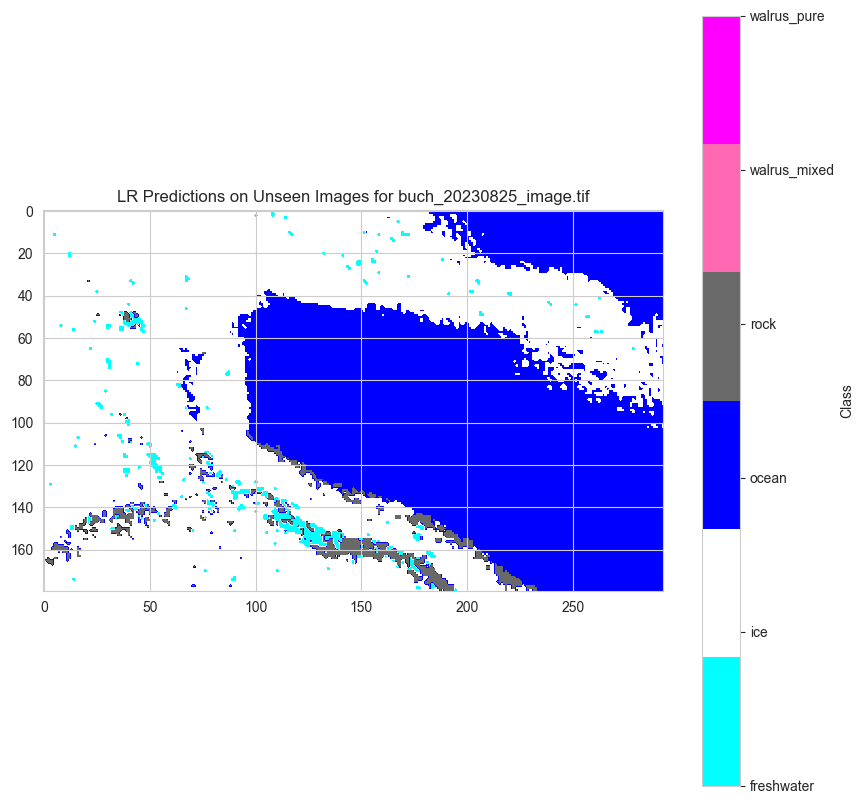

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


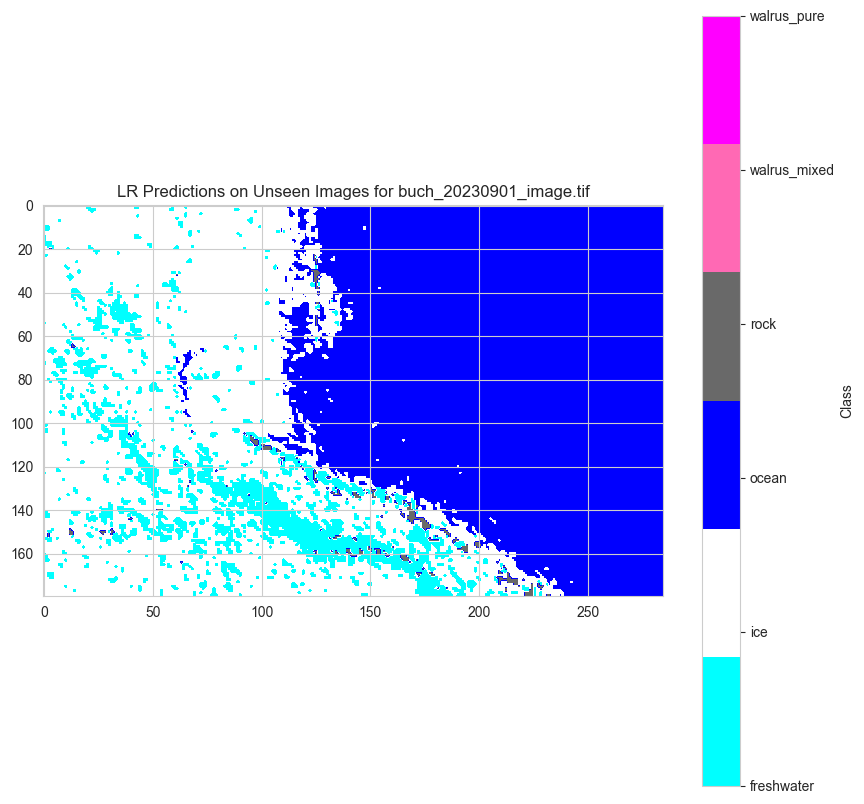

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


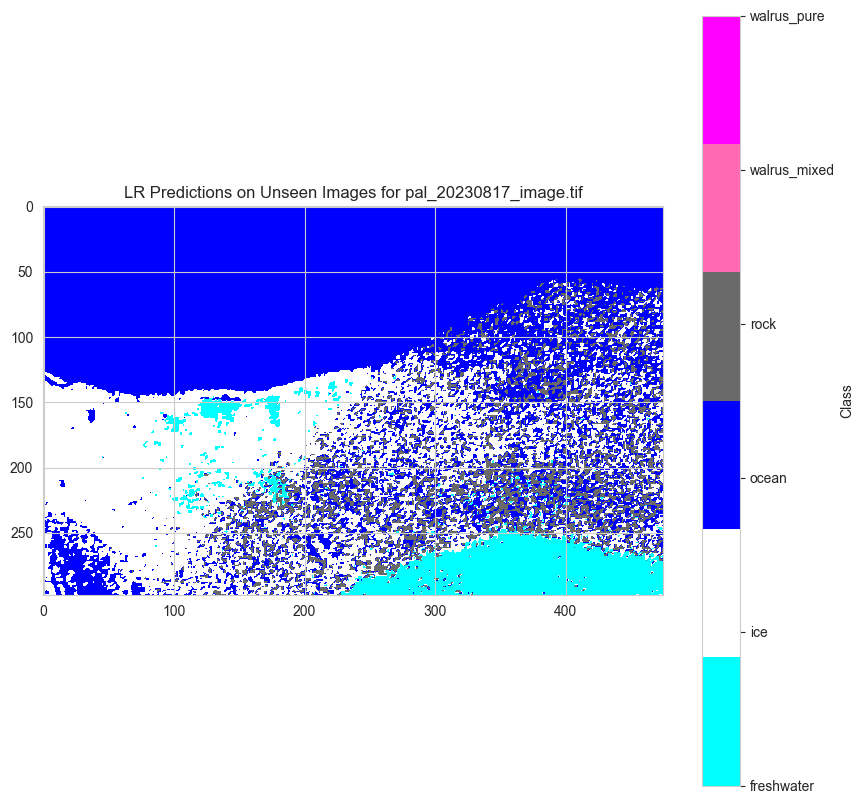

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


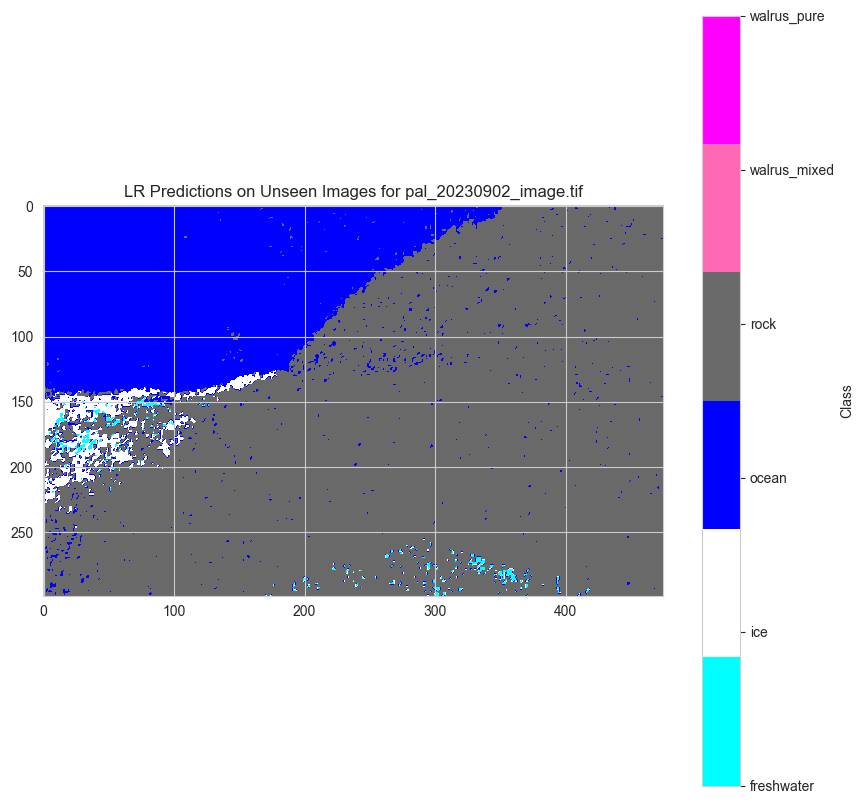

Labels present in sars_20230719_image.tif: ['ice', 'ocean', 'rock']


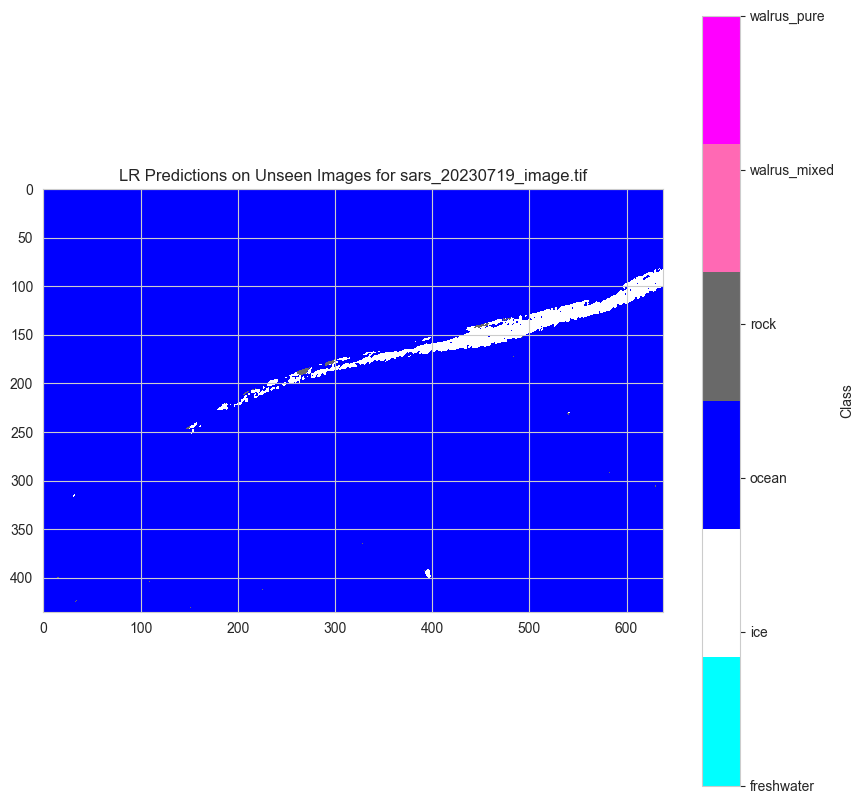

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


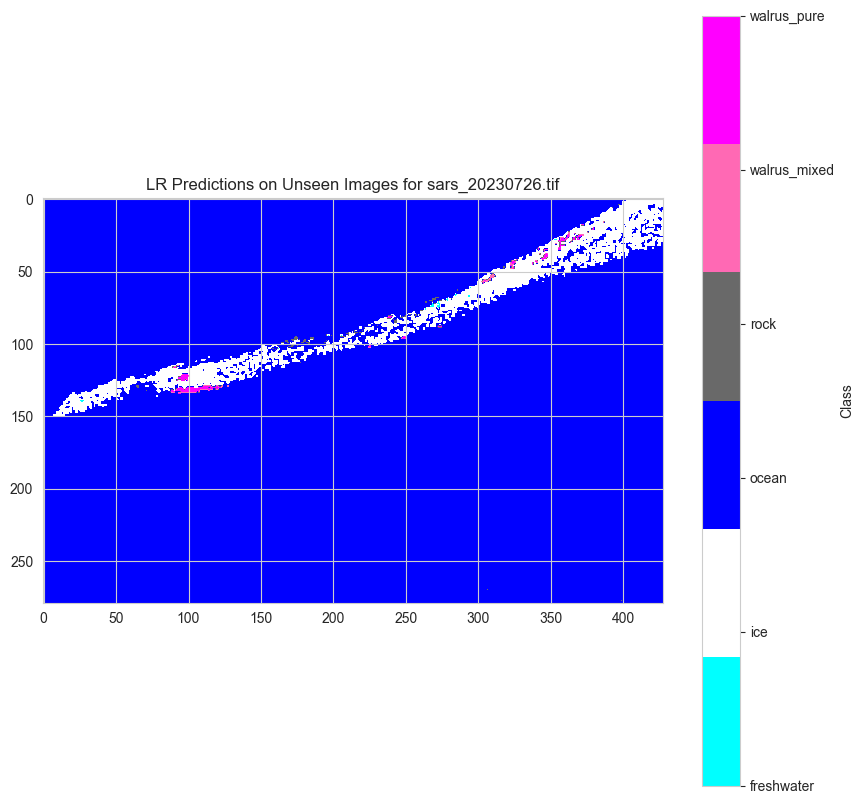

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


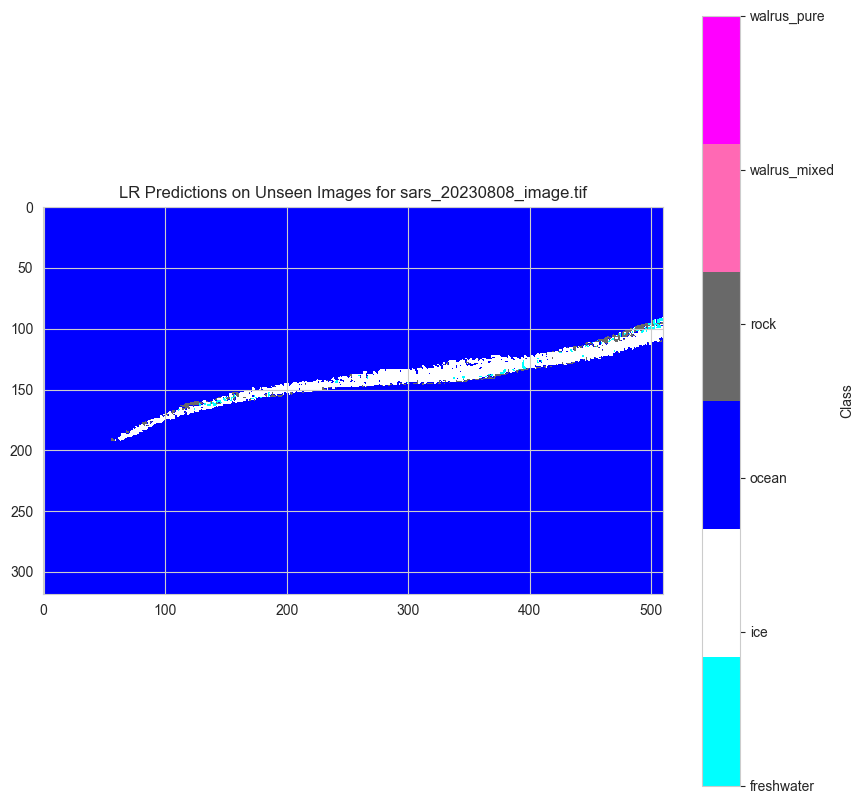

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


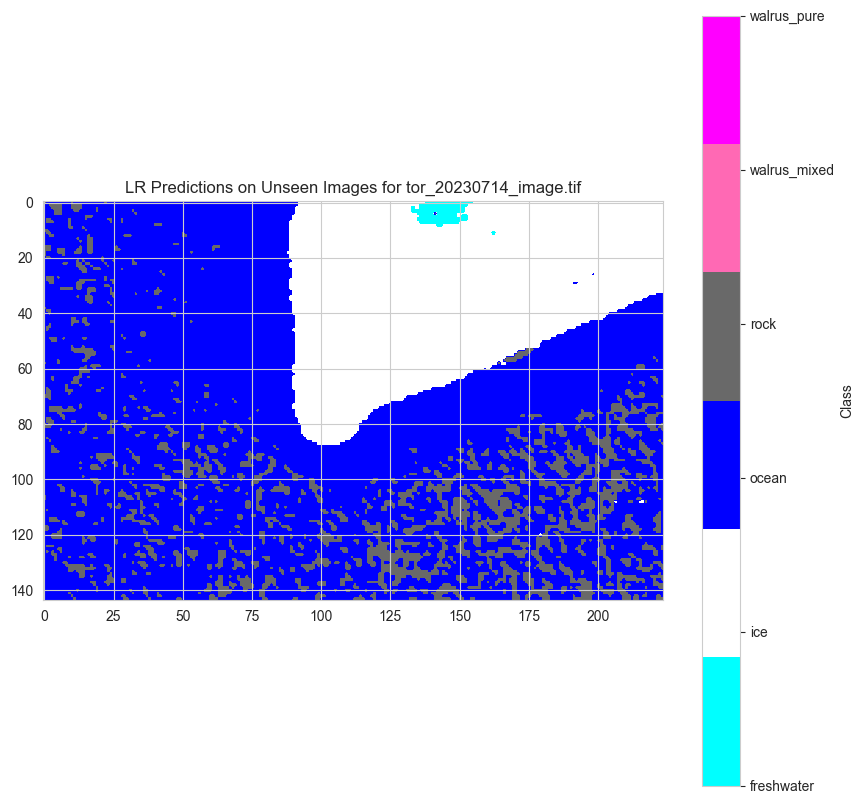

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


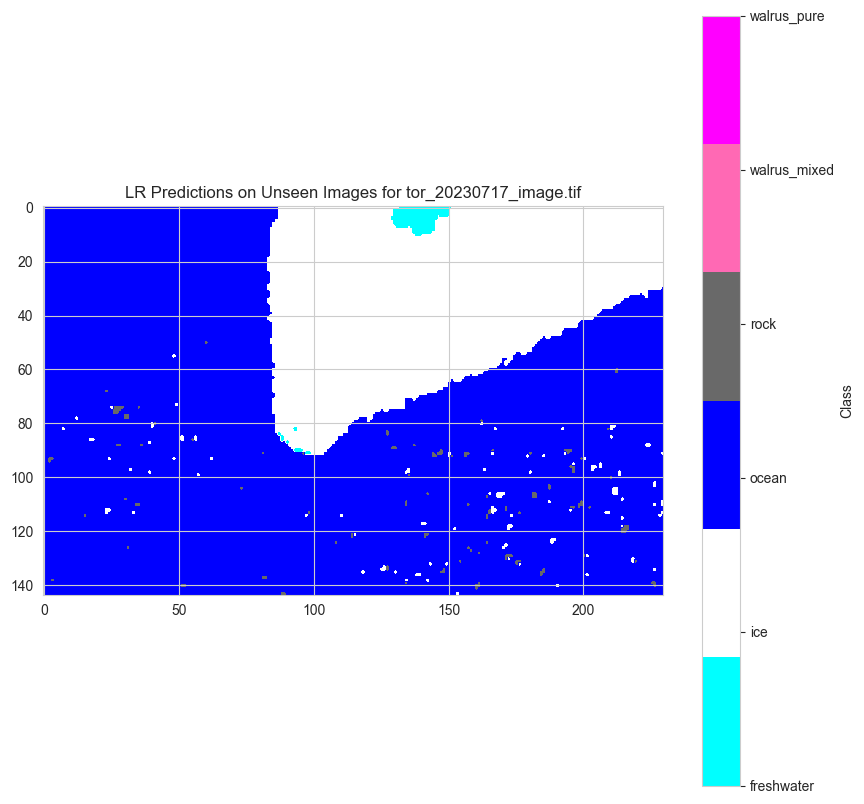

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean']


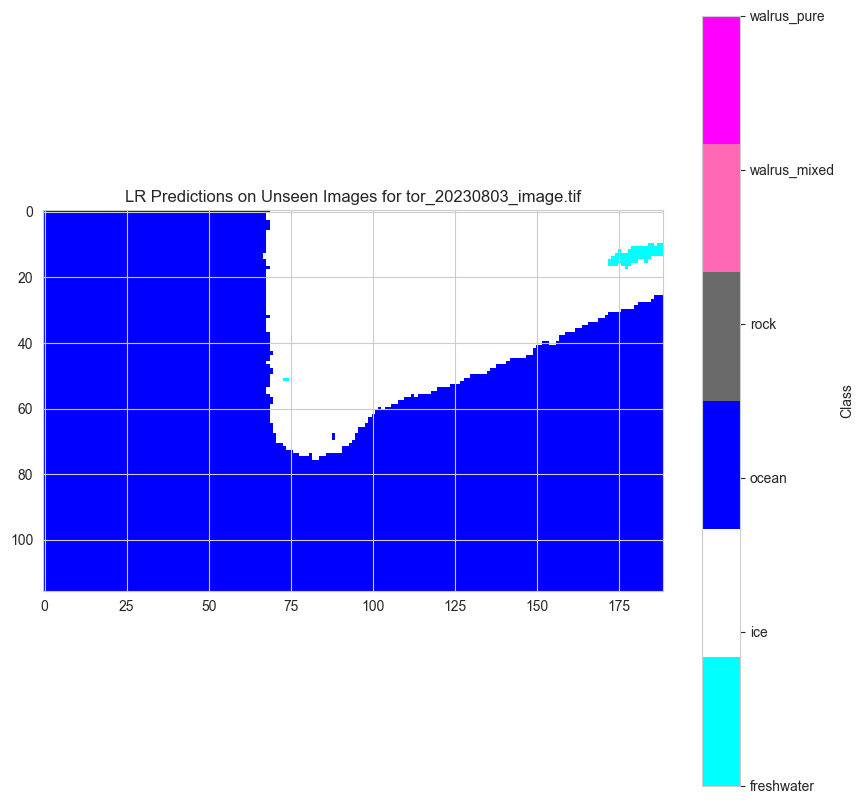

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


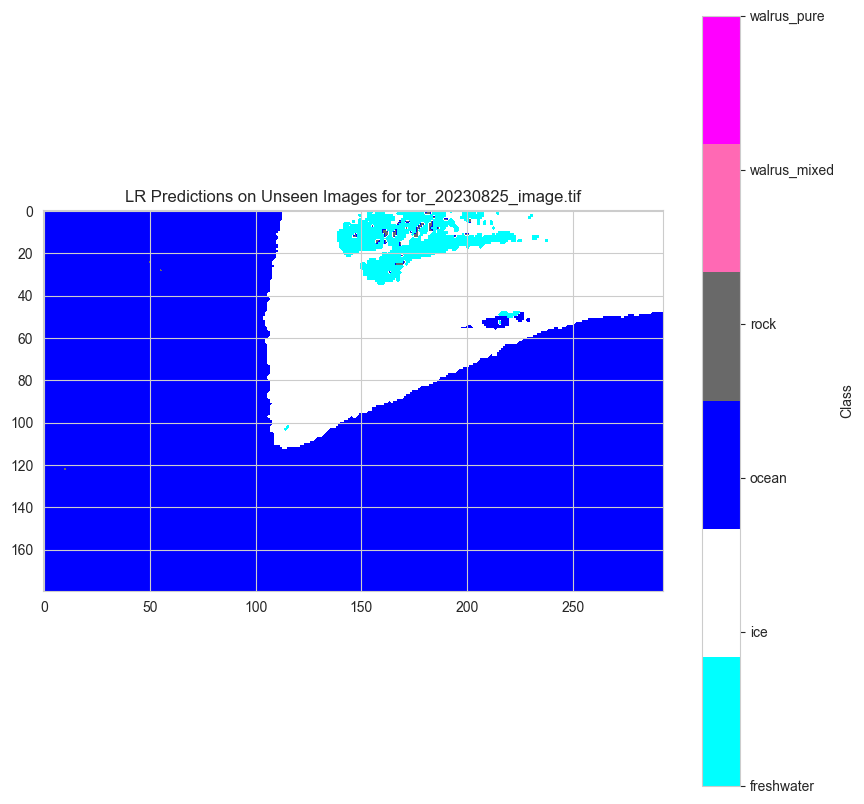

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


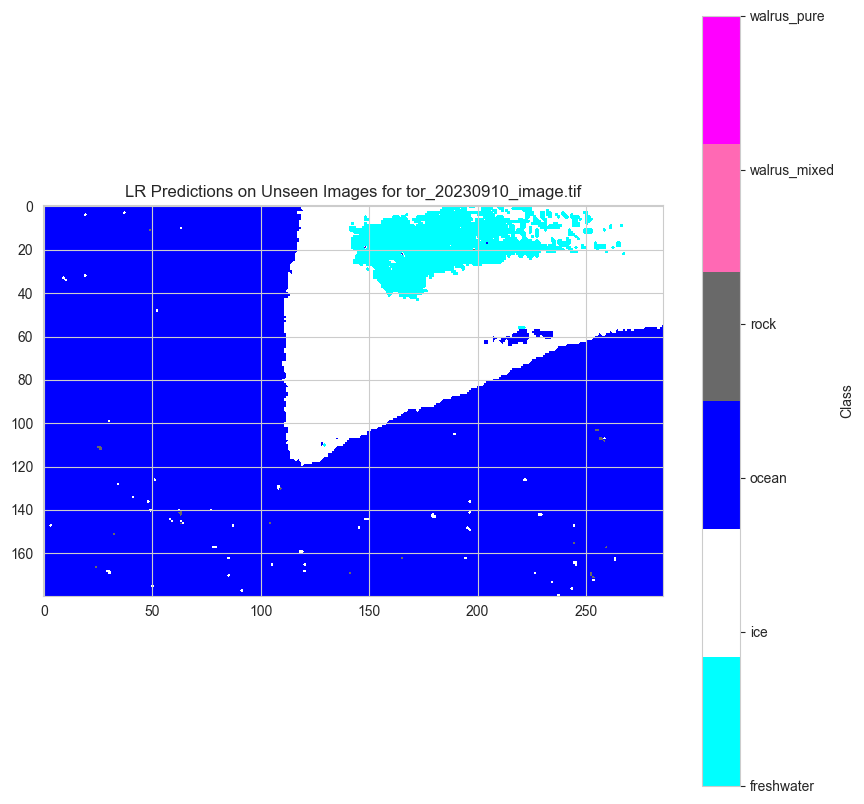


Training and evaluating model: LDA


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9158508446641945
Precision: 0.9066550480976896
Recall: 0.9158508446641945
F1 Score: 0.9080382285549711
Cohen's Kappa: 0.8336469255121024

Classification Report:


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

  freshwater       0.58      0.26      0.35      8050
         ice       0.86      0.93      0.89     60046
       ocean       0.96      0.98      0.97    155857
        rock       0.76      0.60      0.67     18572
walrus_mixed       0.00      0.00      0.00       165
 walrus_pure       0.00      0.00      0.00        10

    accuracy                           0.92    242700
   macro avg       0.53      0.46      0.48    242700
weighted avg       0.91      0.92      0.91    242700


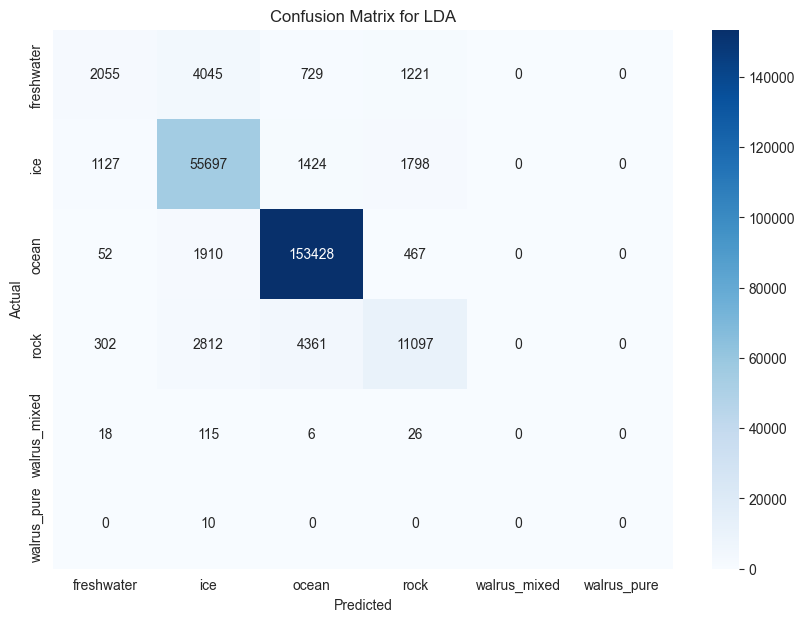

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


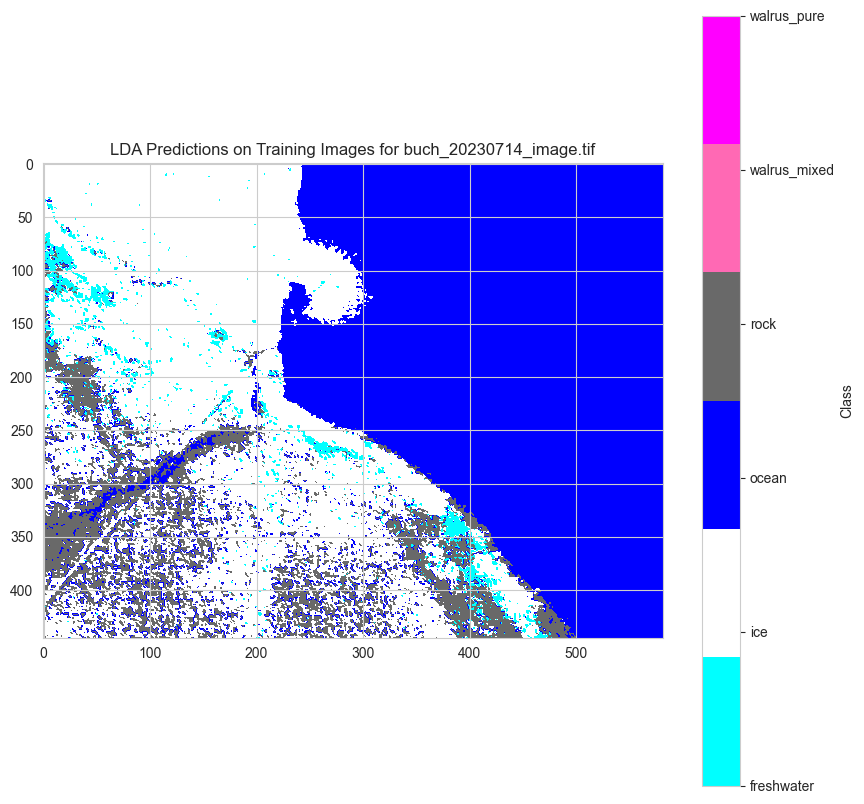

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


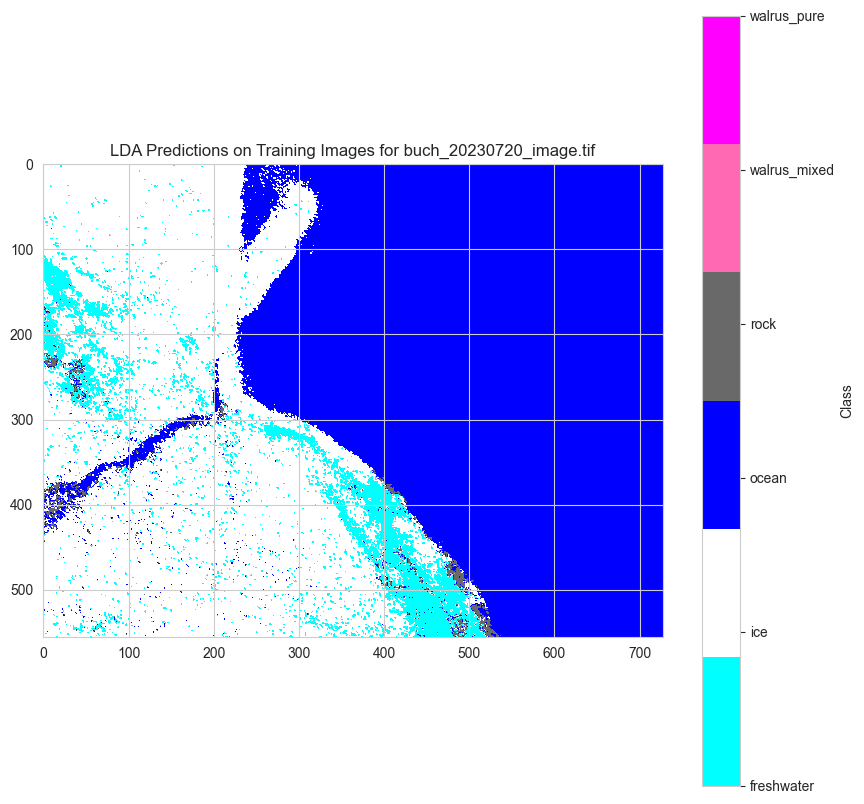

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


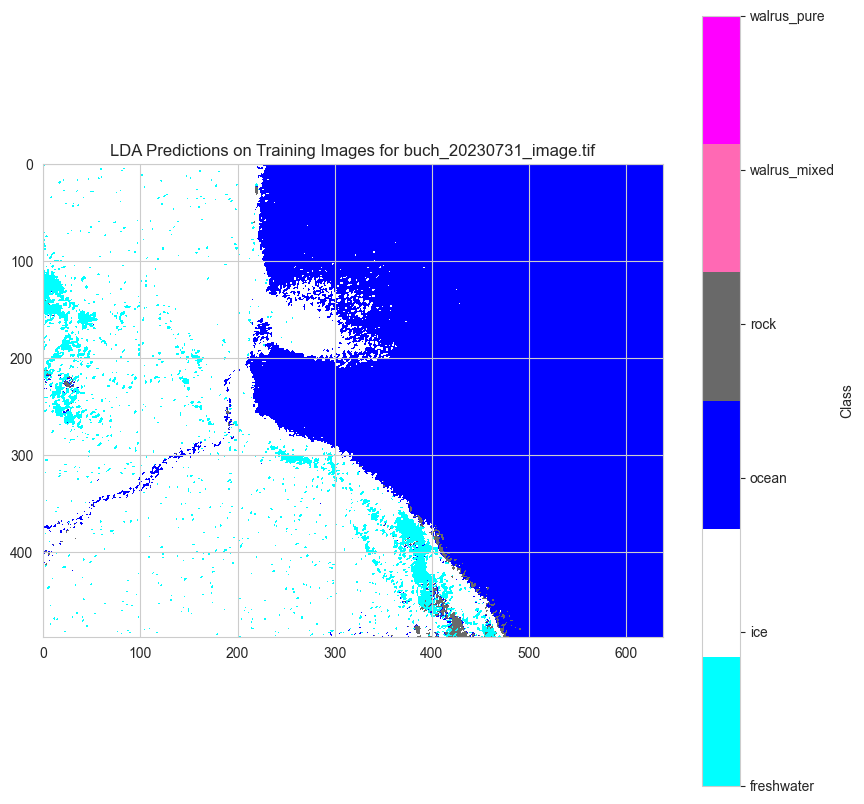

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


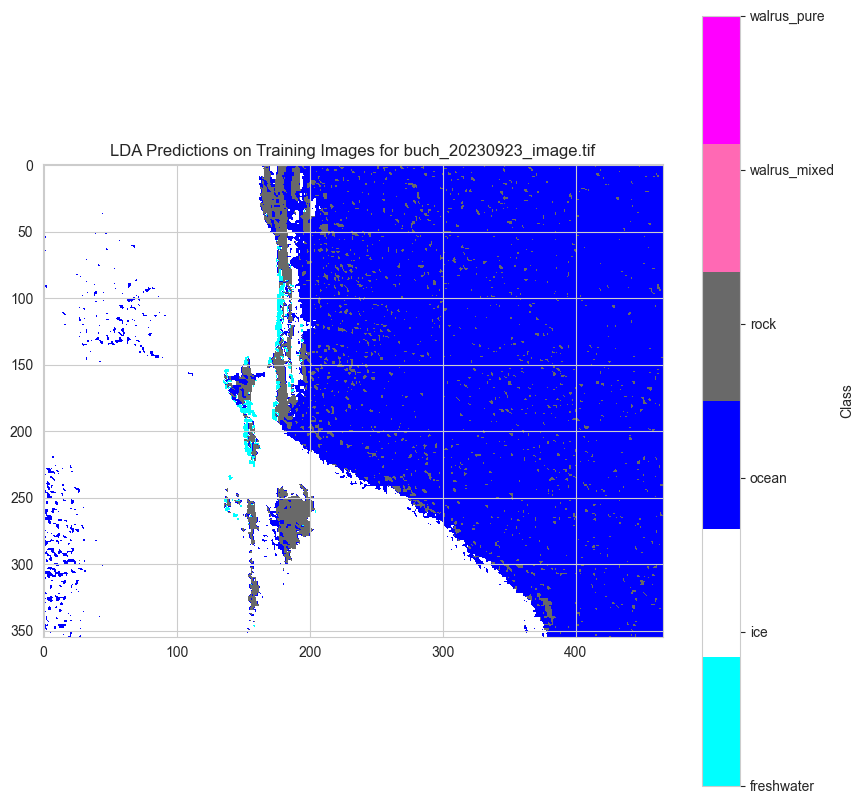

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


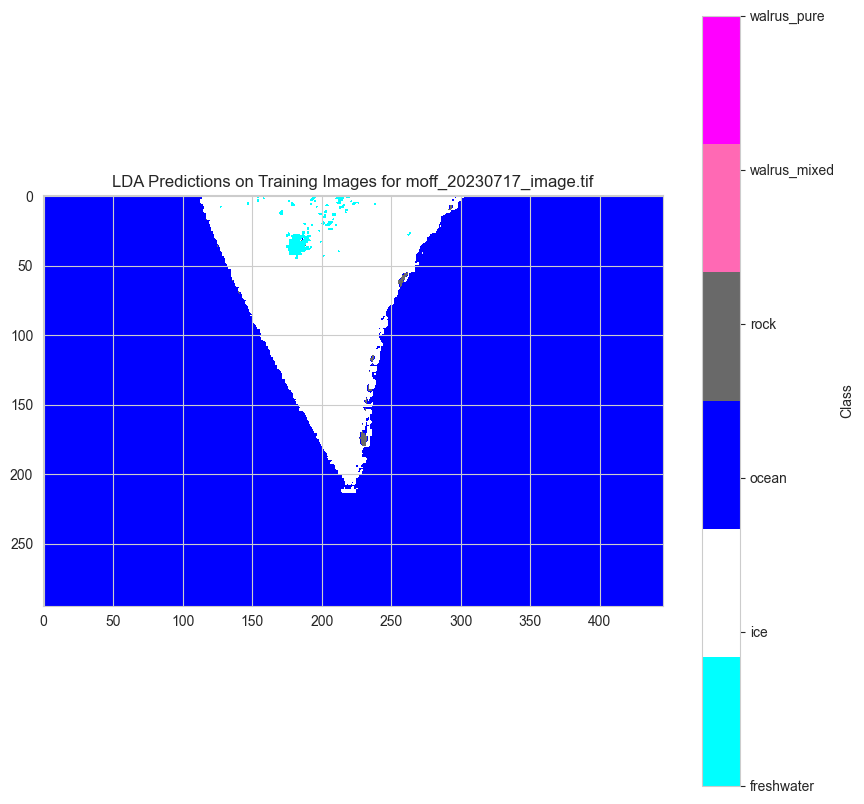

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


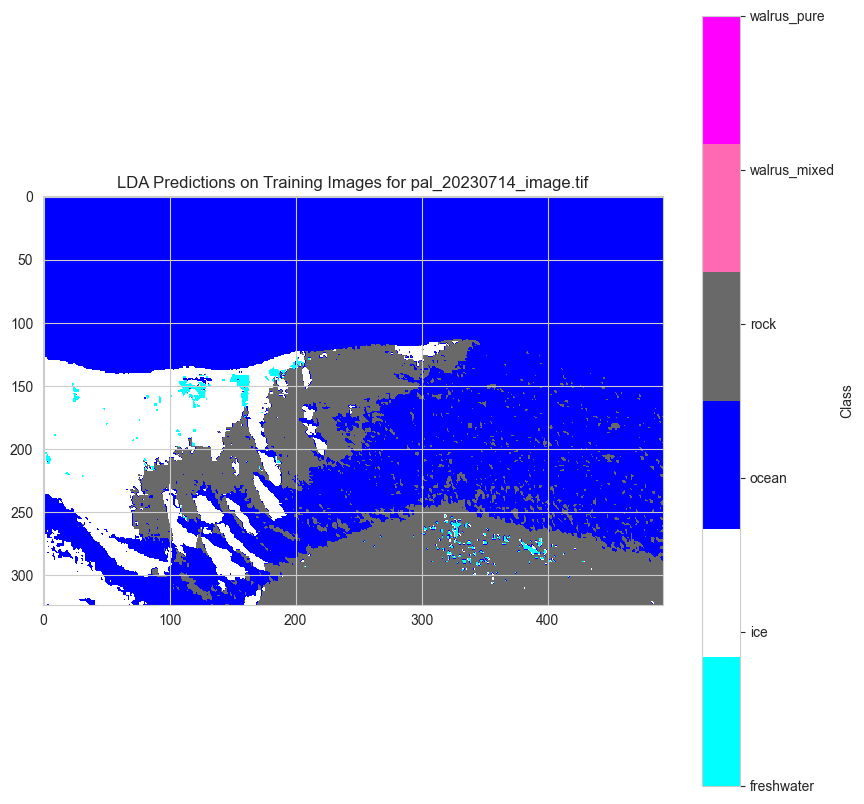

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


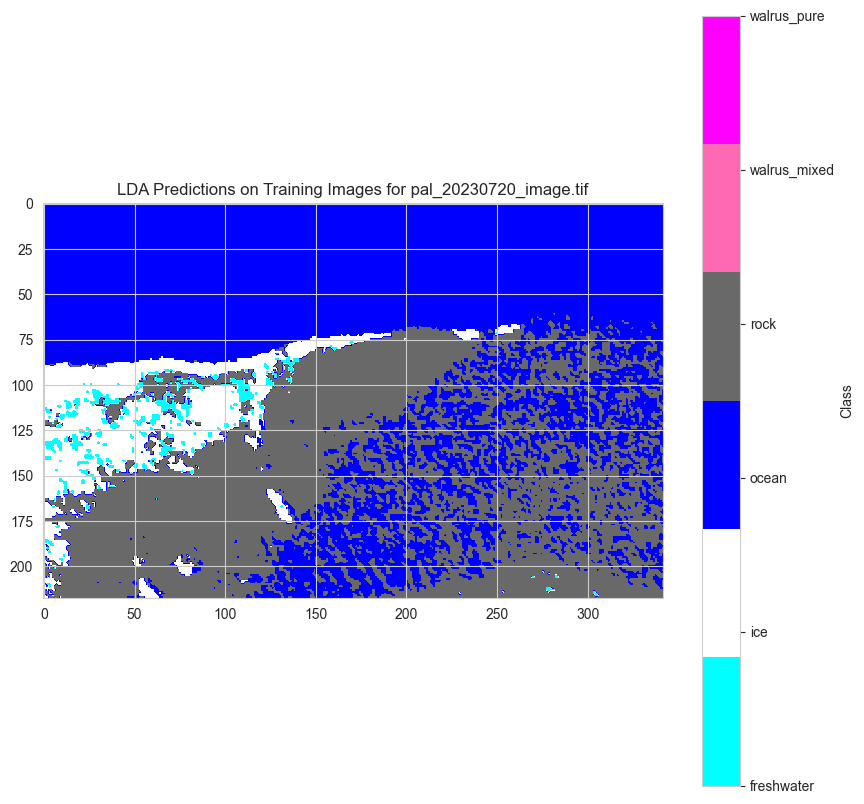

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


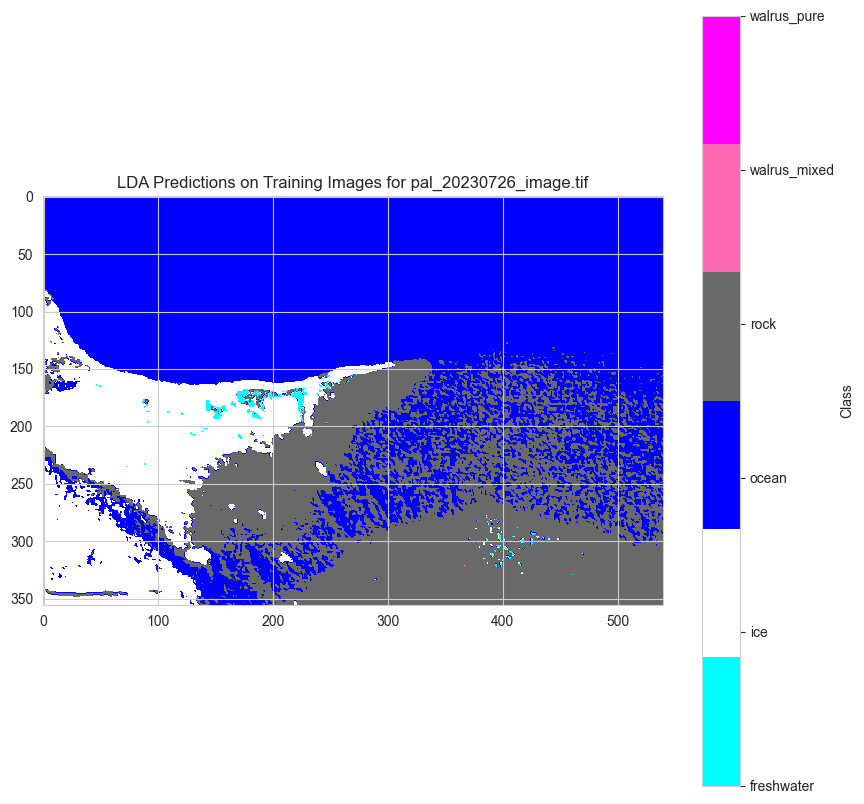

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


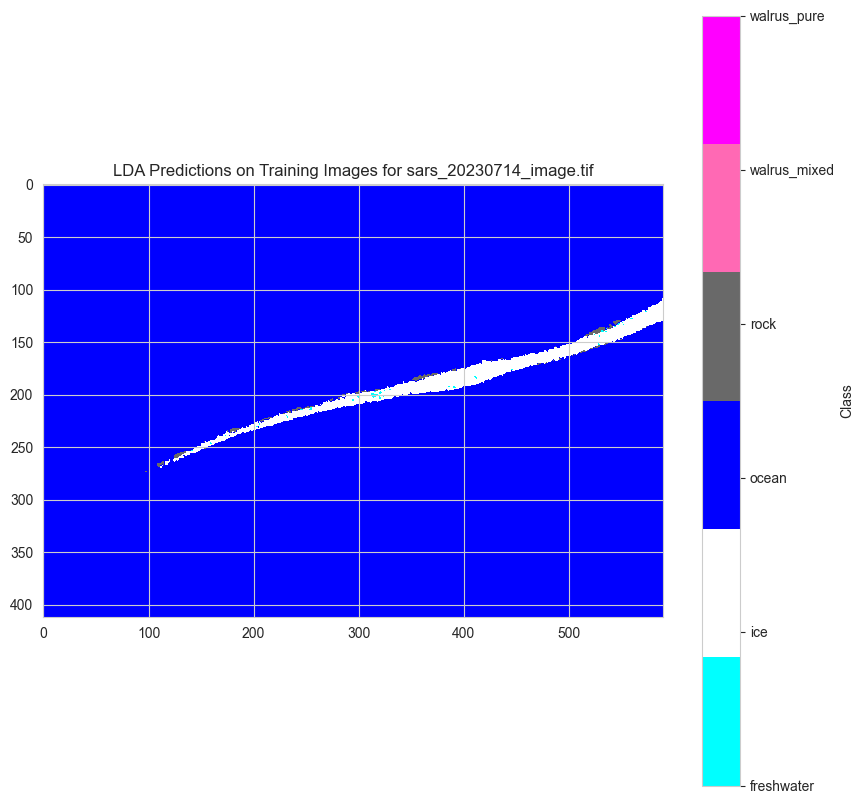

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


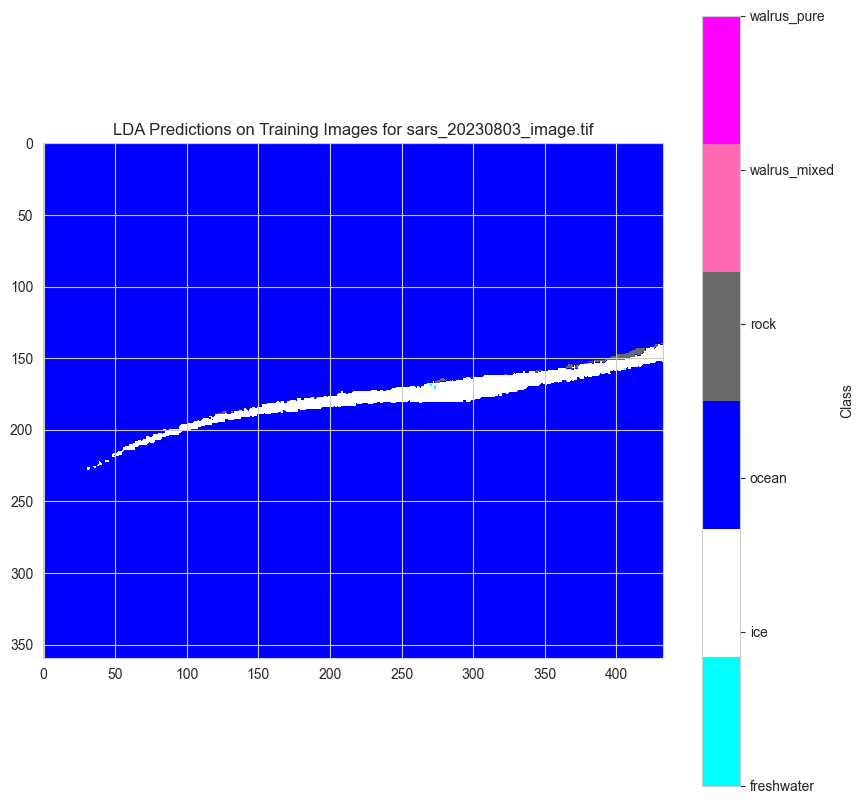

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


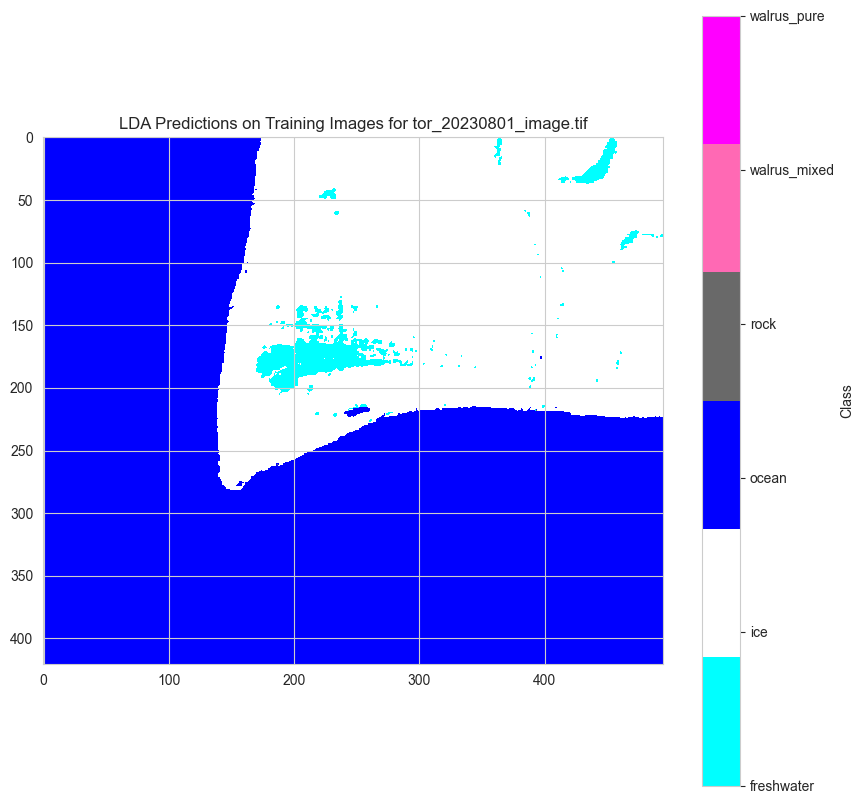

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean']


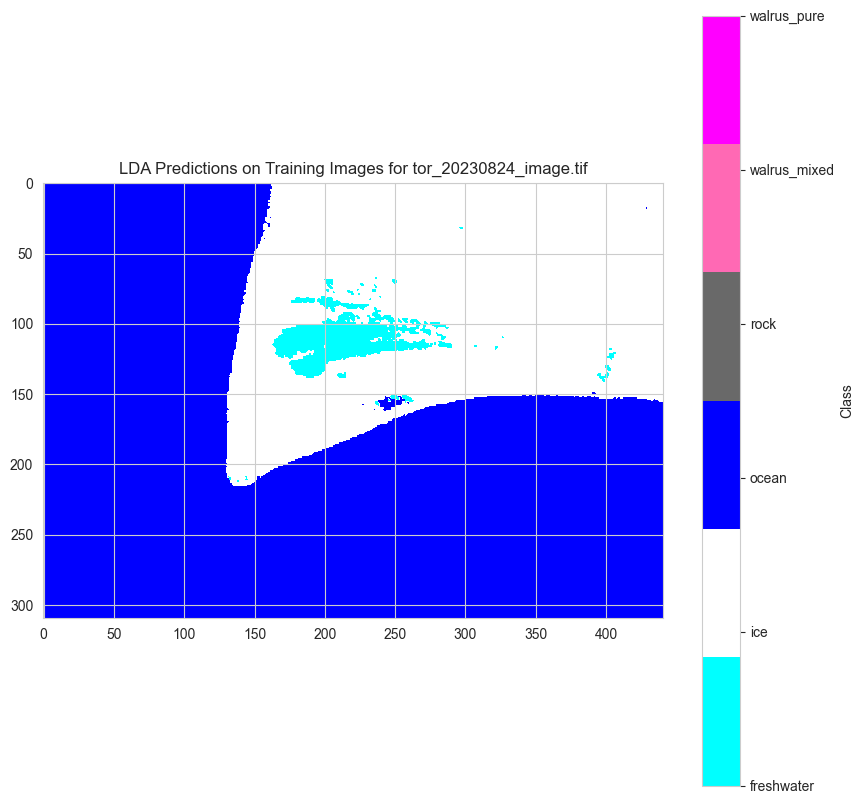

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


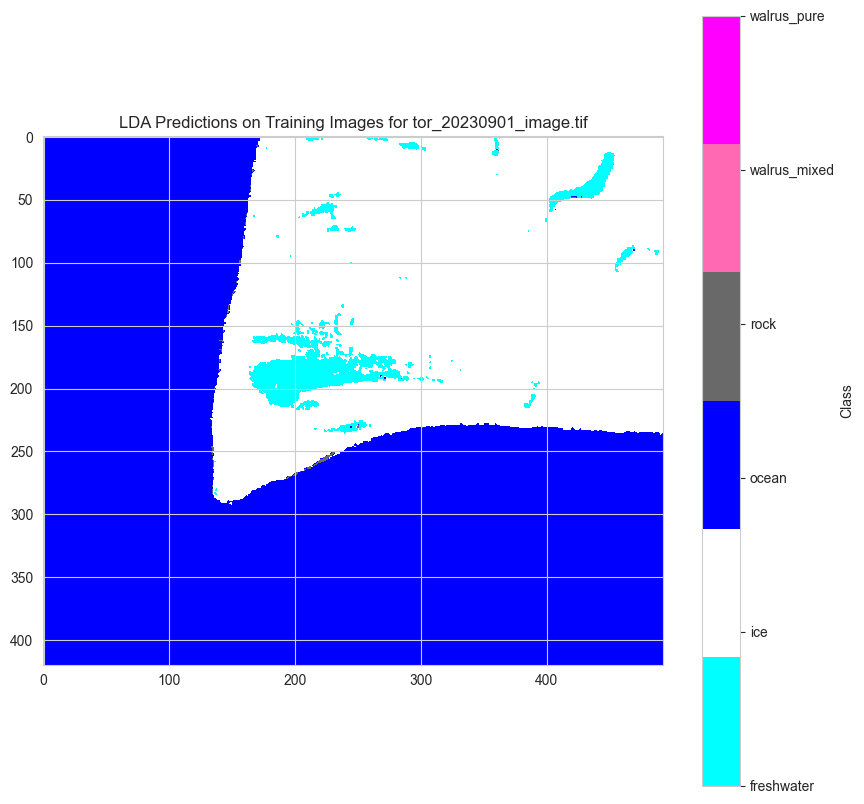

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'walrus_pure']


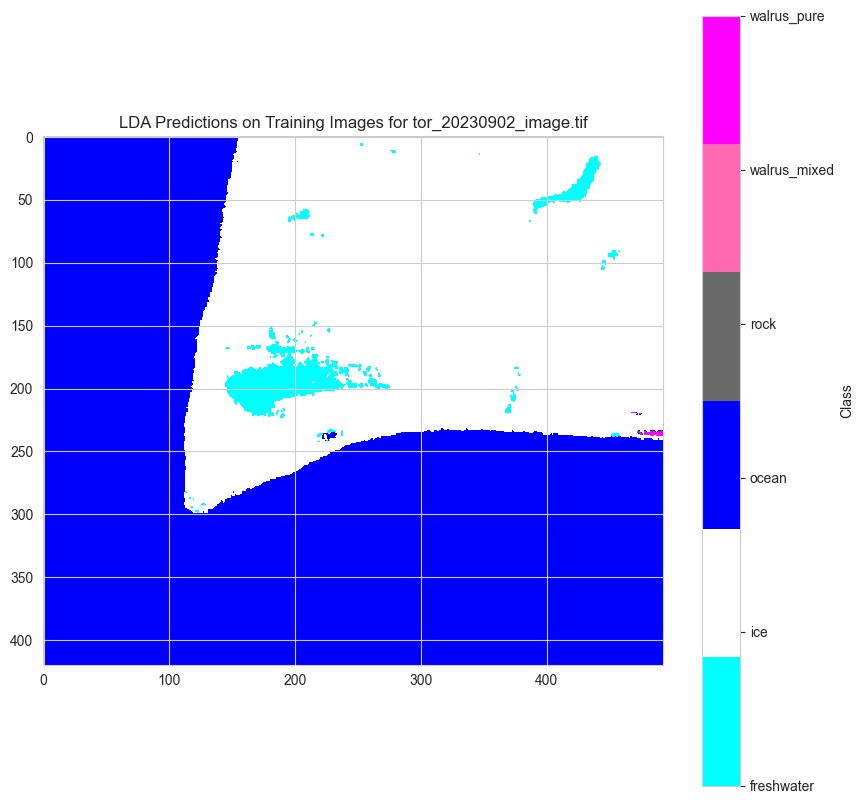

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


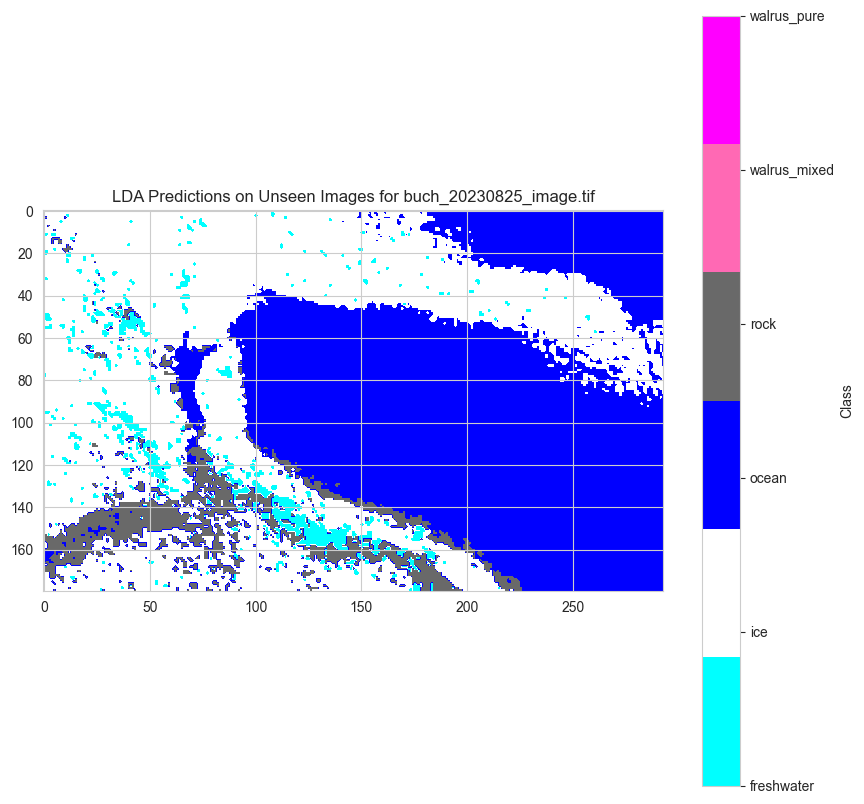

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


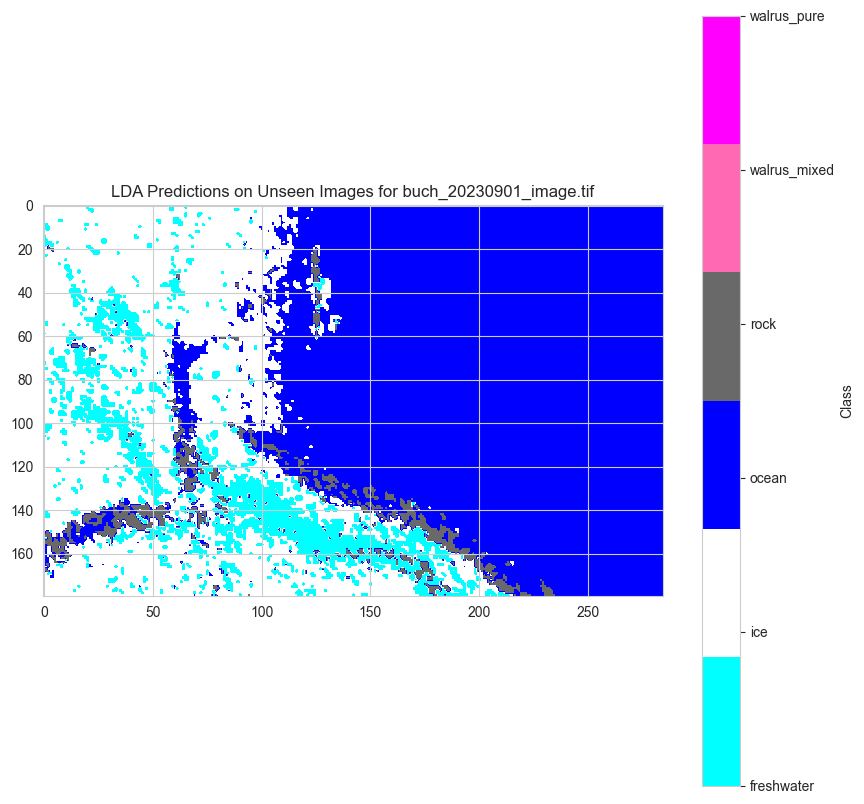

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


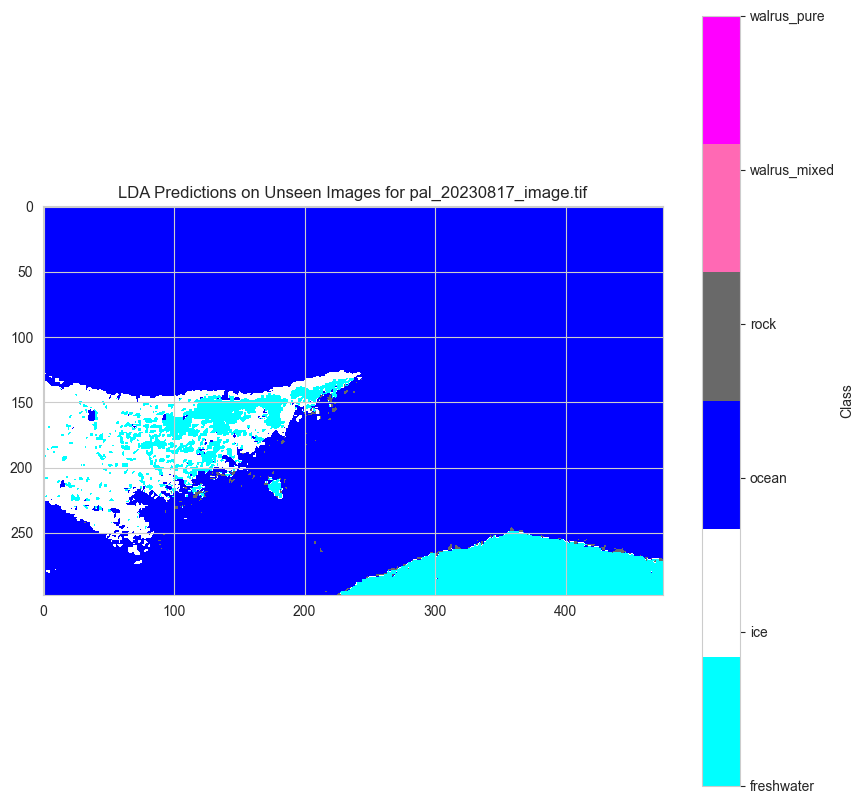

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


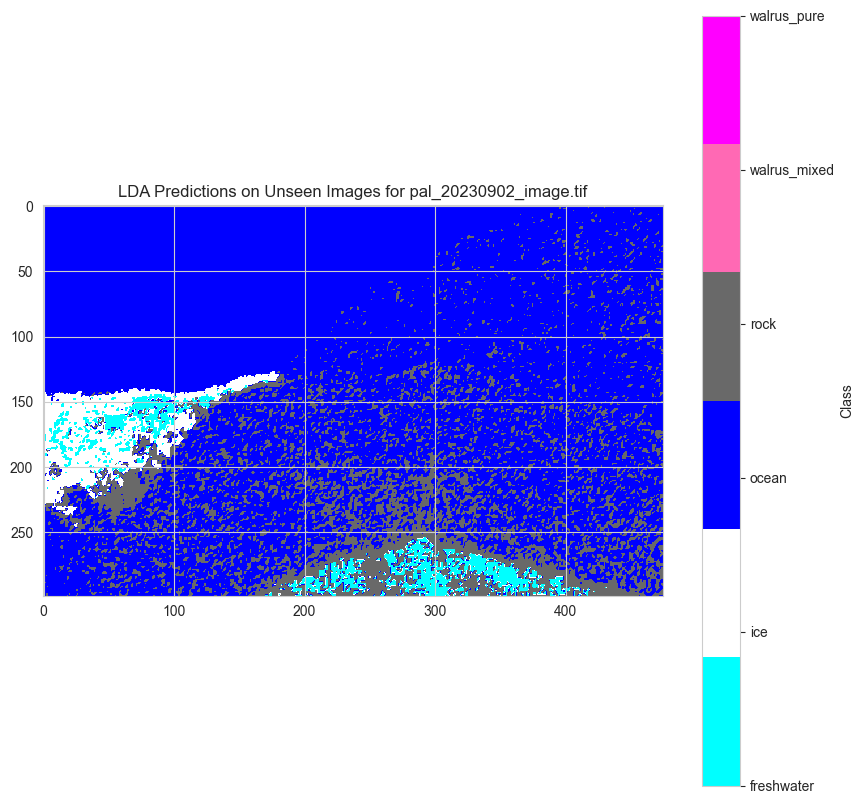

Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


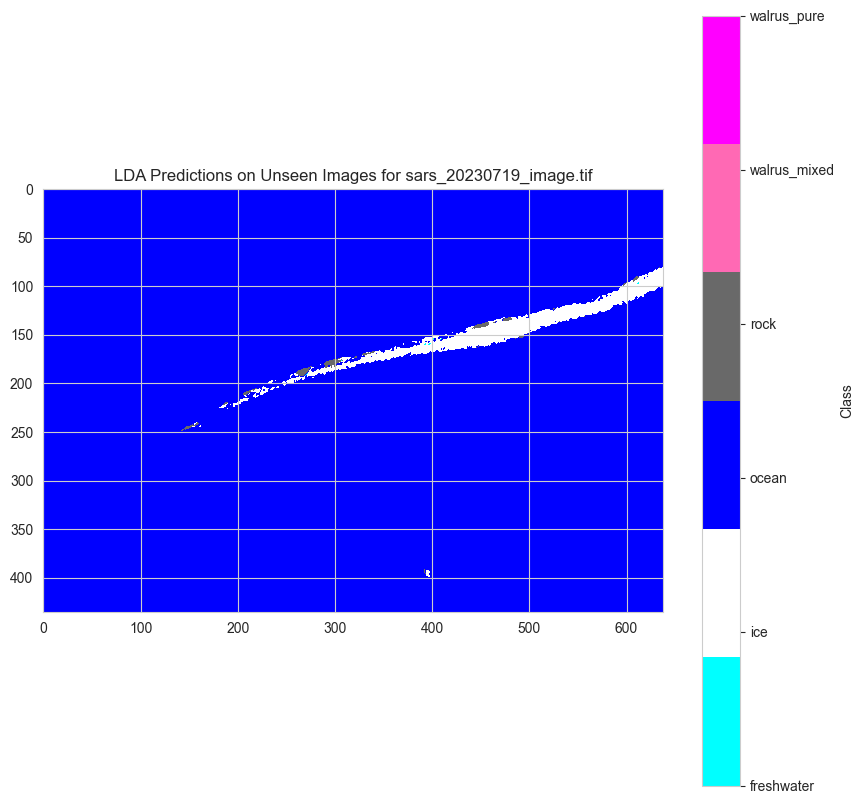

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock']


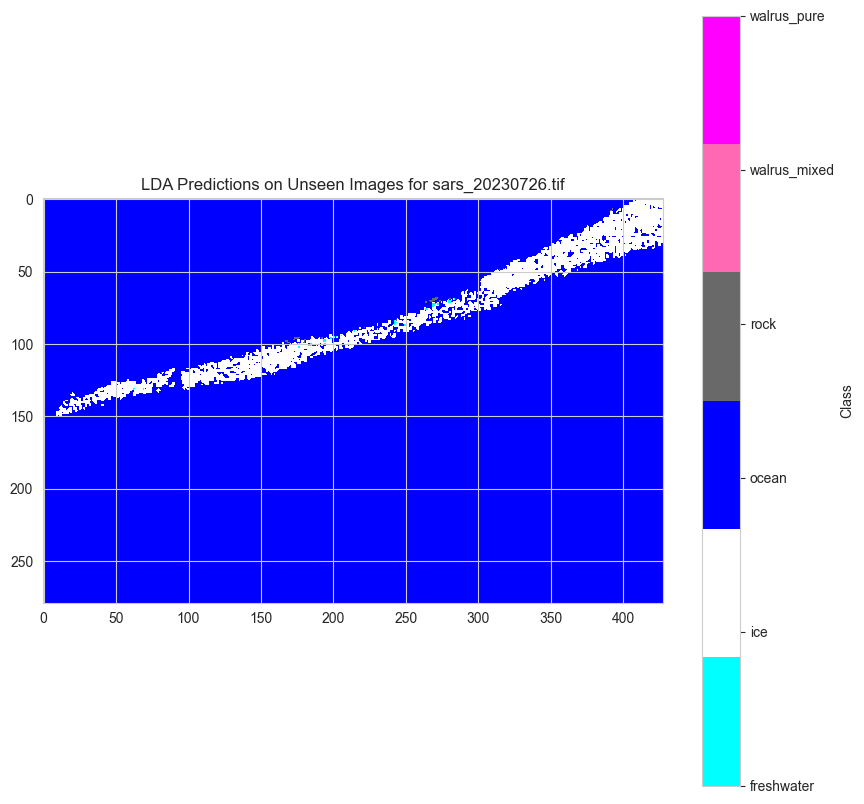

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


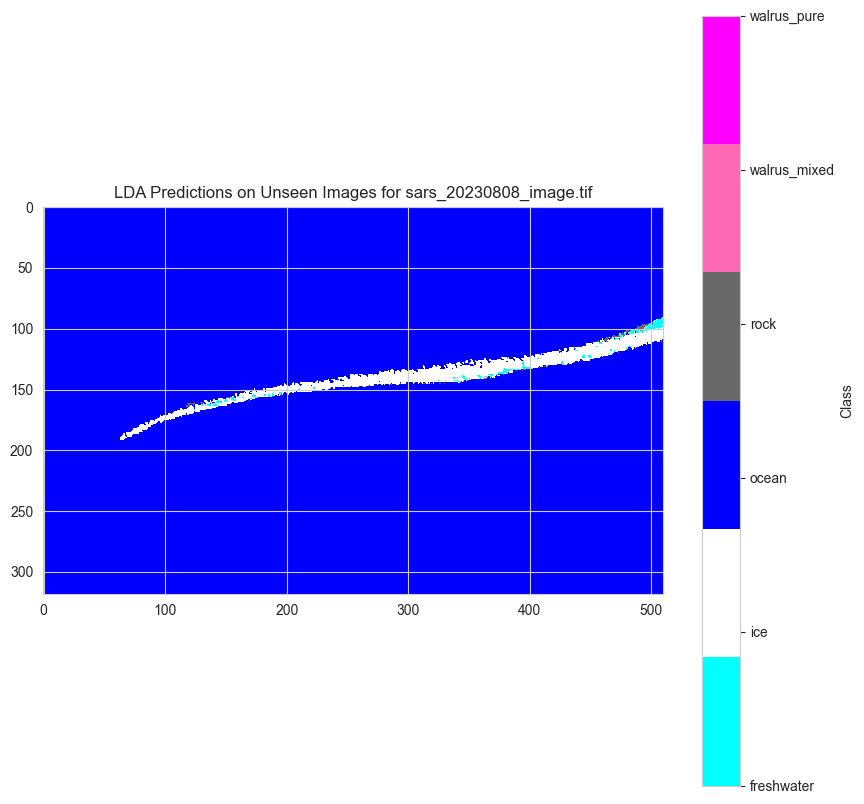

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


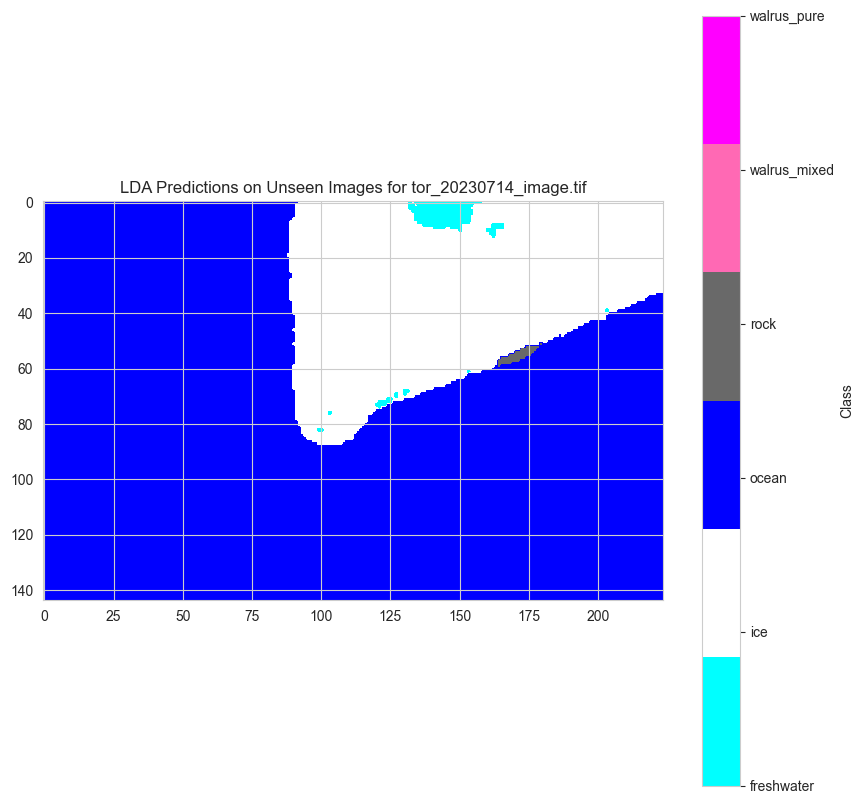

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


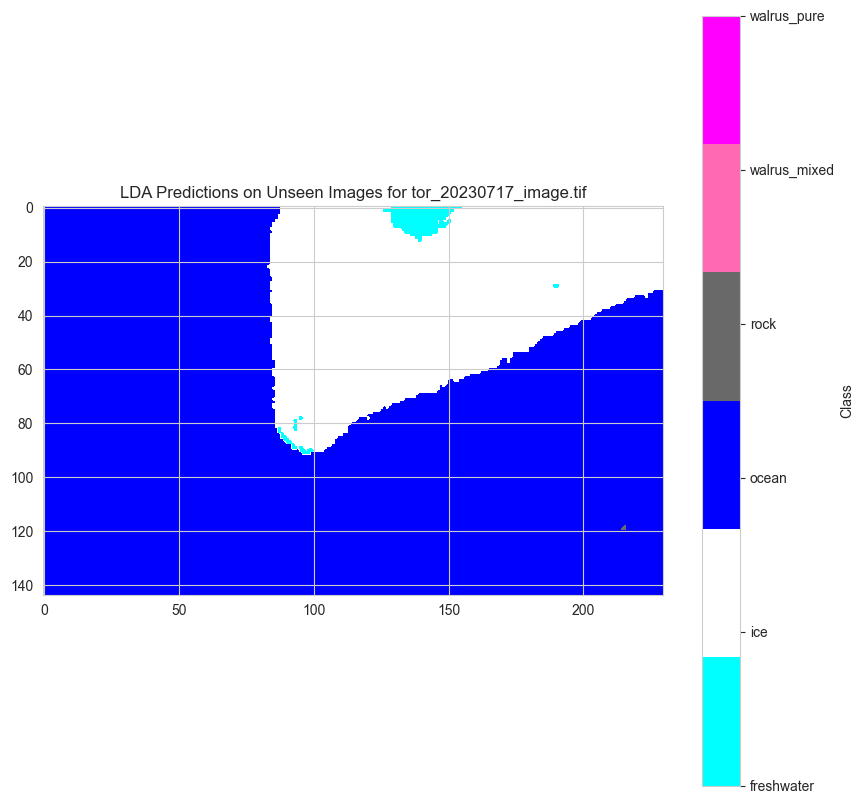

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean']


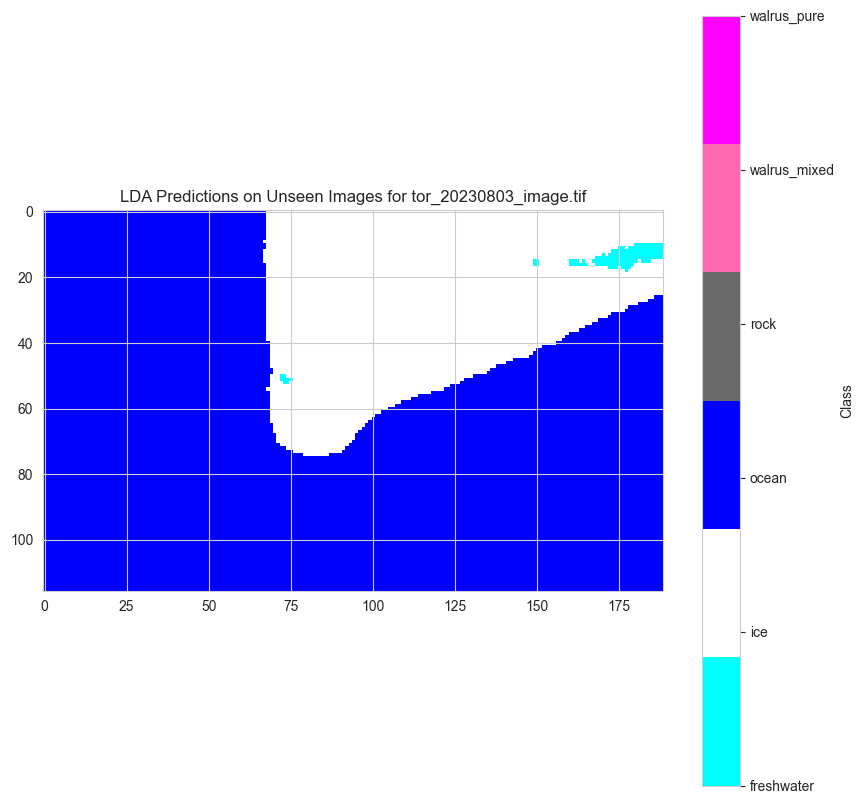

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


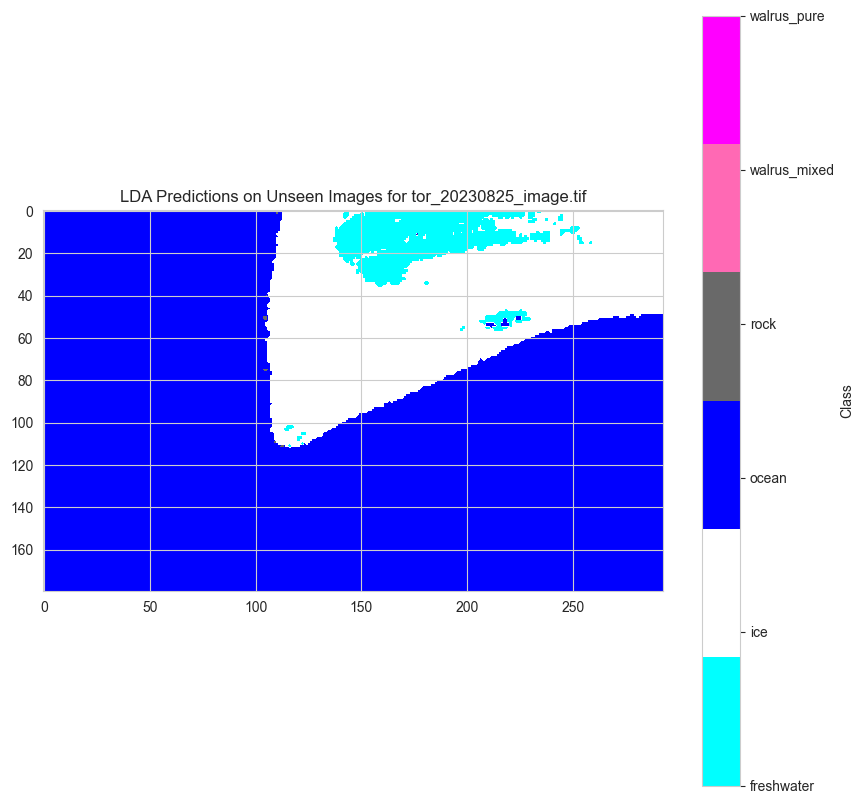

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


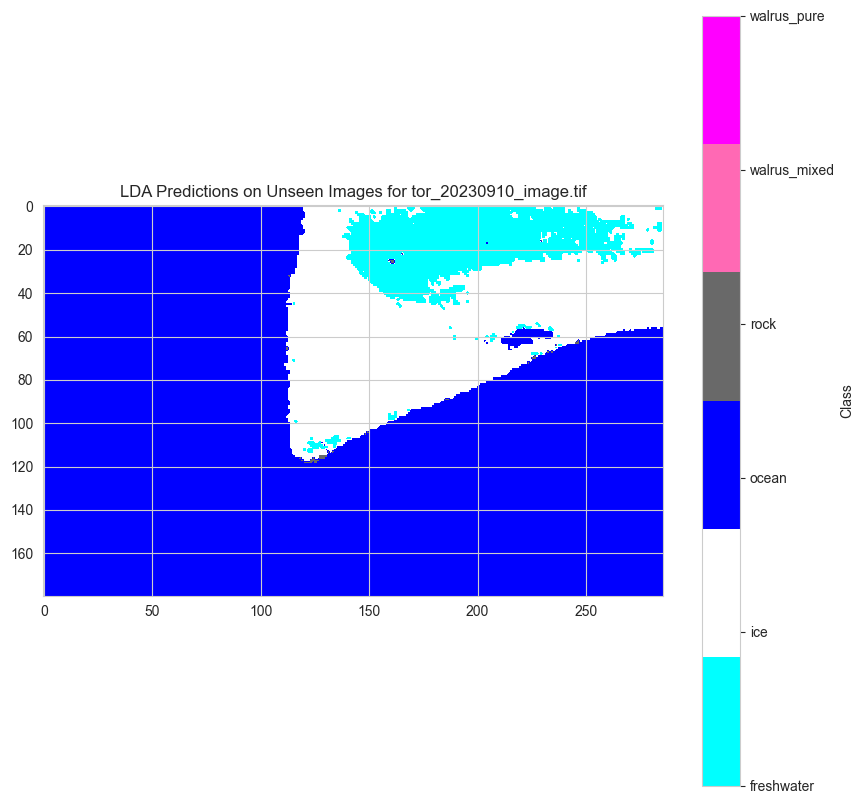


Training and evaluating model: KNN
Accuracy: 0.9898393077873918
Precision: 0.9897953871871185
Recall: 0.9898393077873918
F1 Score: 0.989760176412945
Cohen's Kappa: 0.9804273594336935

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.90      0.90      8050
         ice       0.98      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.98     18572
walrus_mixed       0.92      0.47      0.62       165
 walrus_pure       0.83      1.00      0.91        10

    accuracy                           0.99    242700
   macro avg       0.94      0.89      0.90    242700
weighted avg       0.99      0.99      0.99    242700


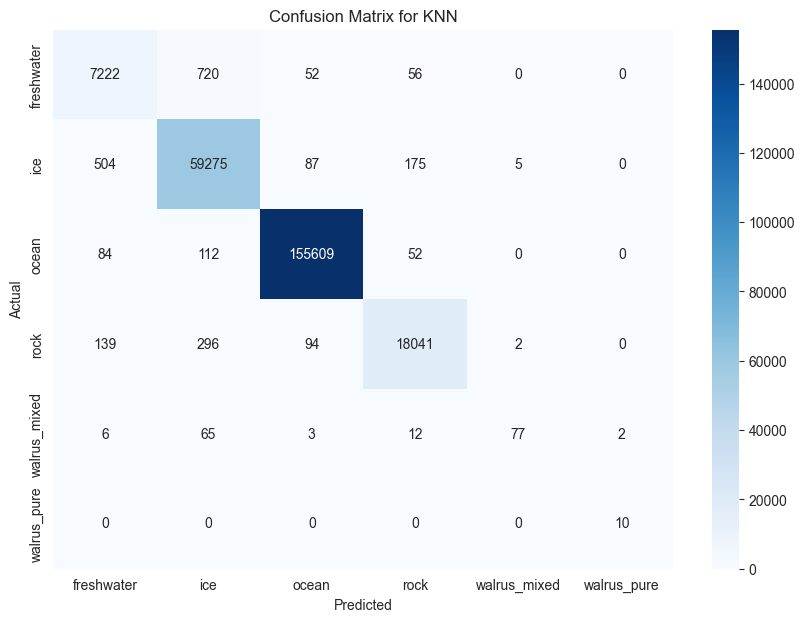

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


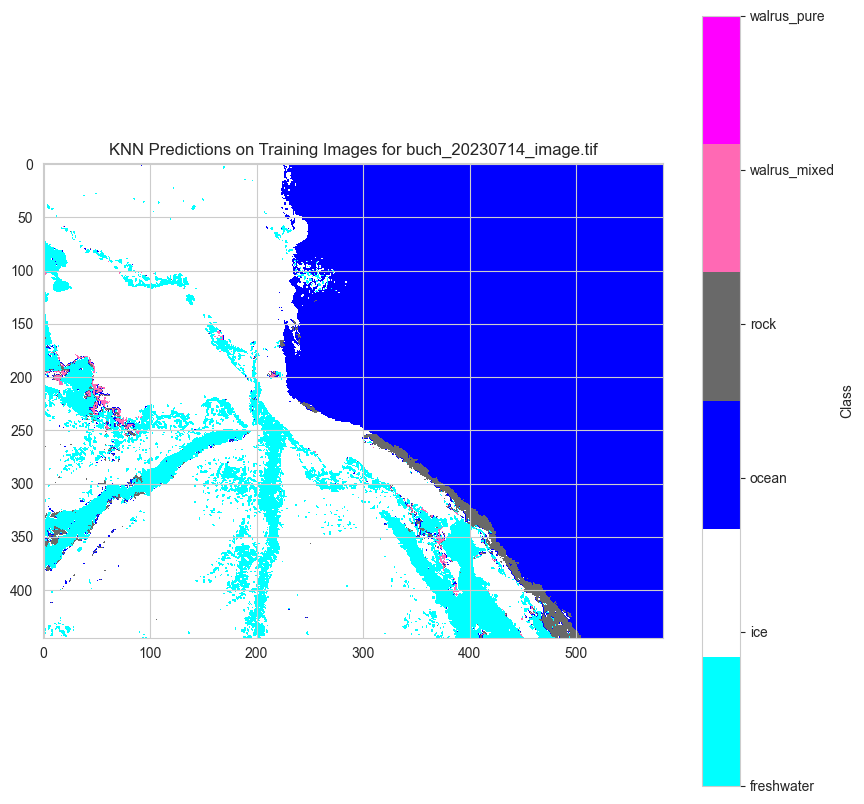

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


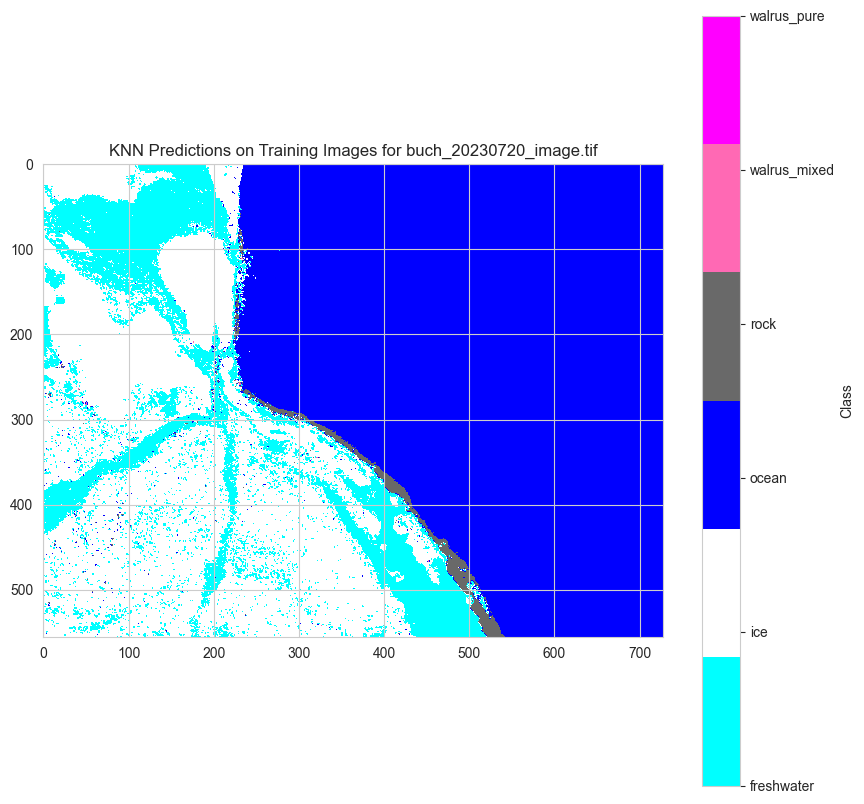

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


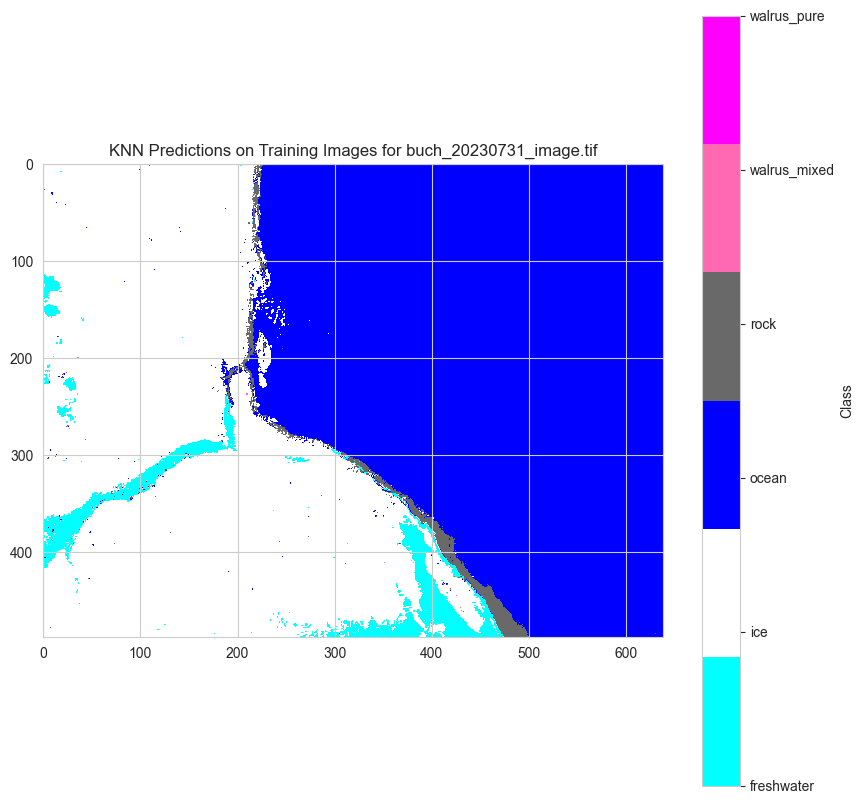

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


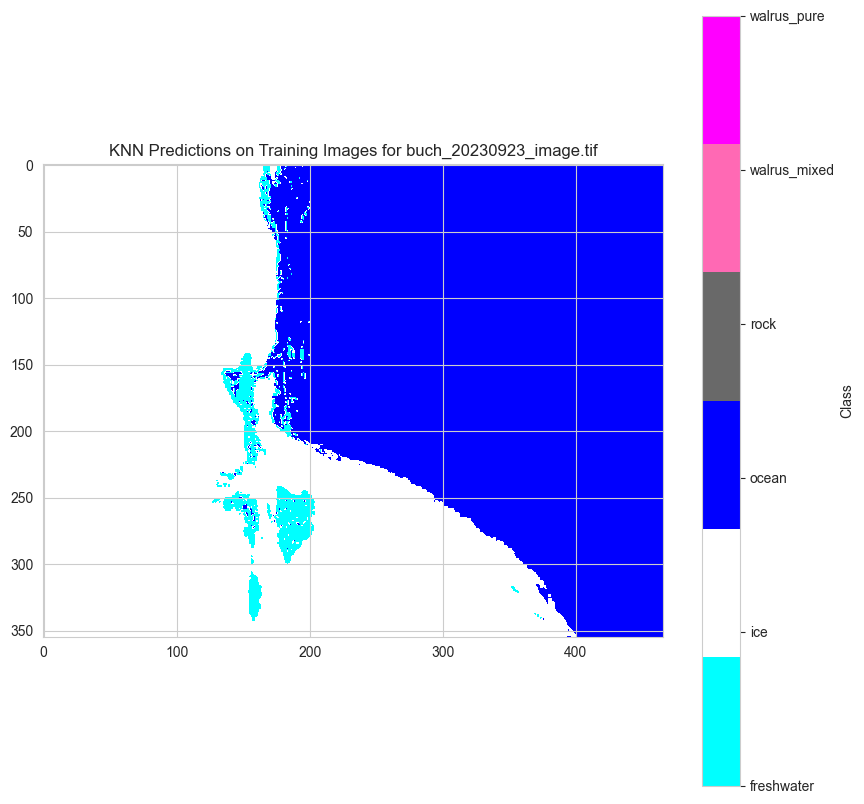

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


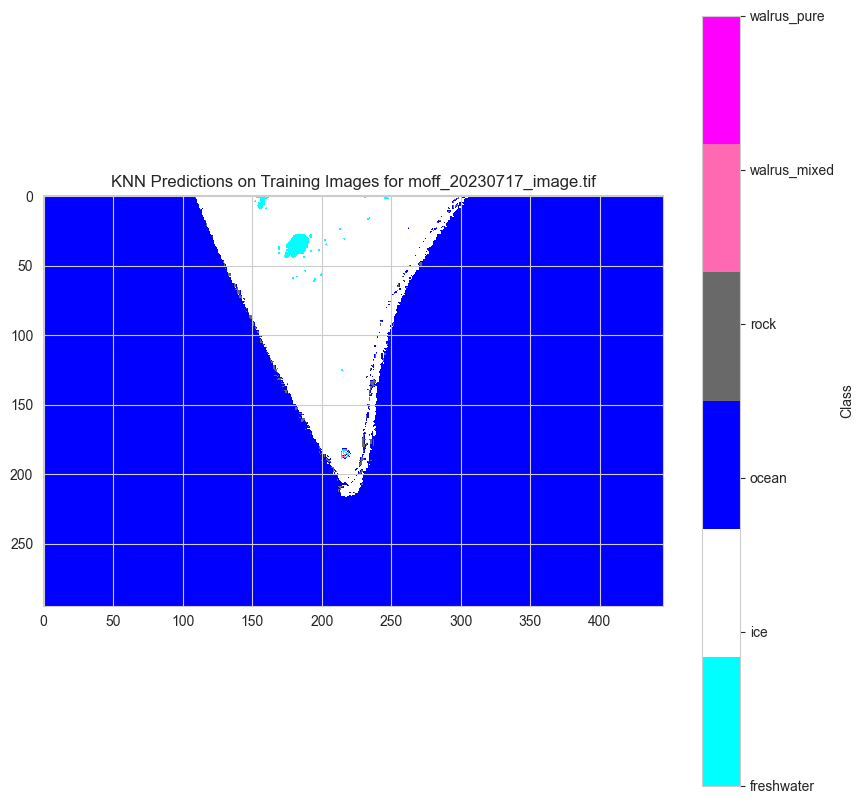

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


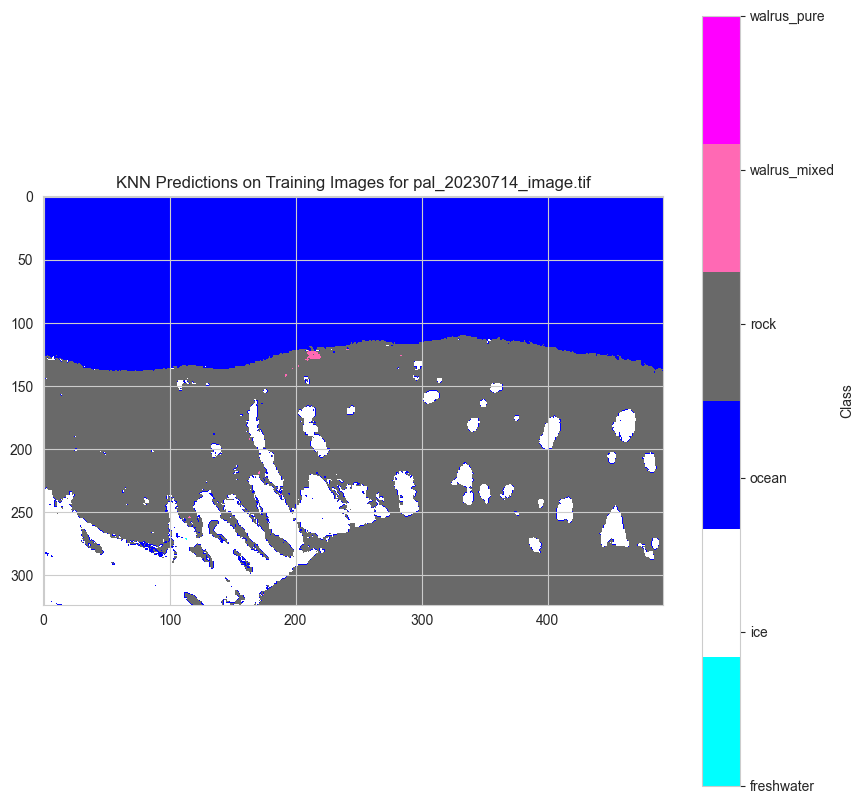

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


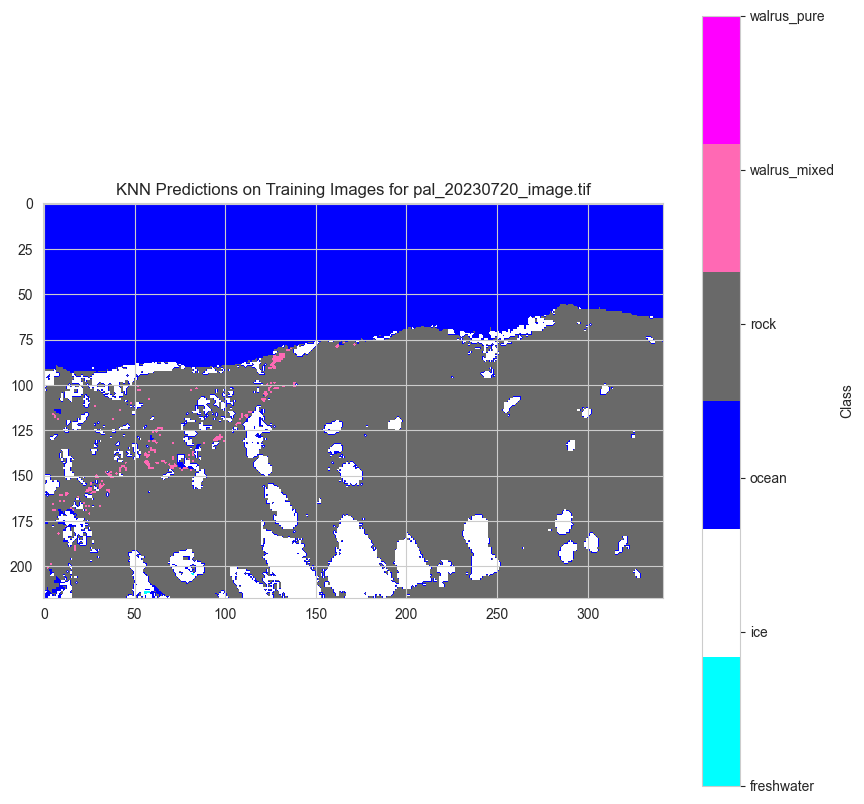

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


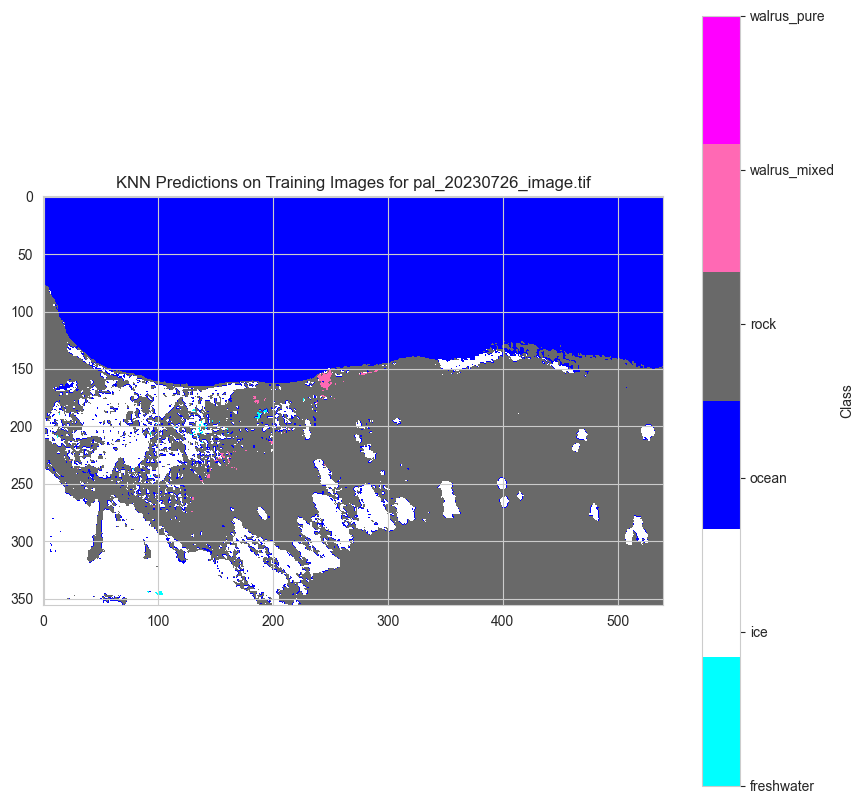

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


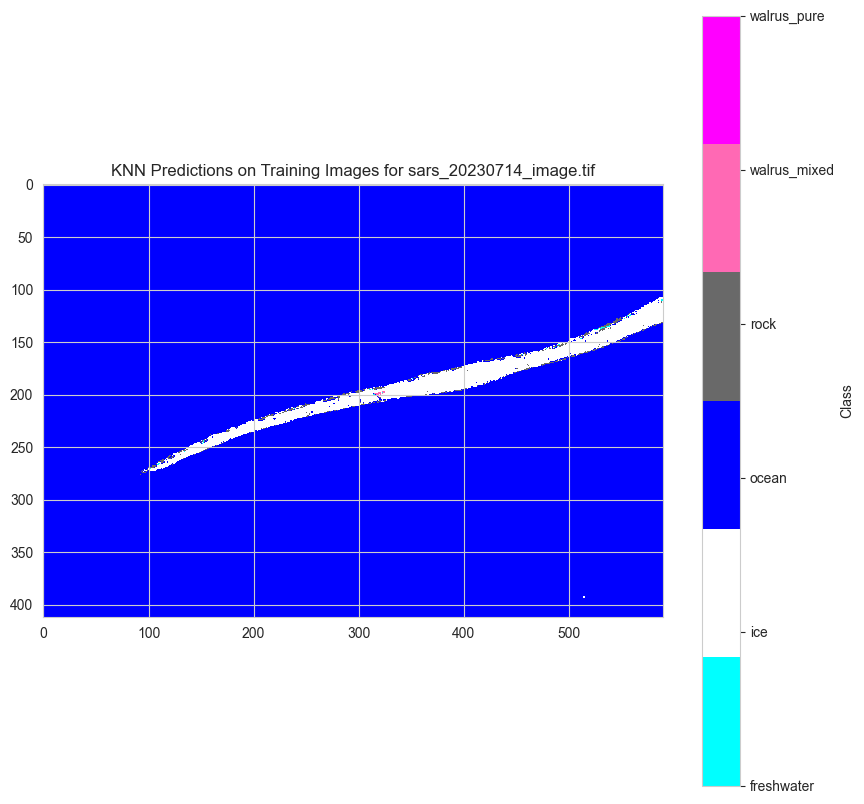

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


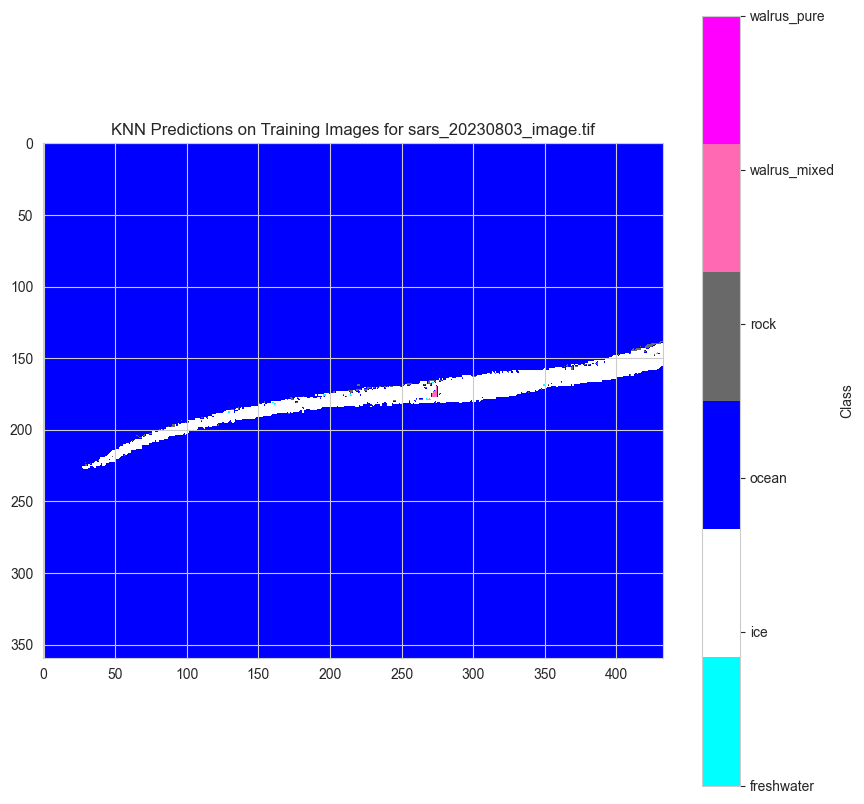

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


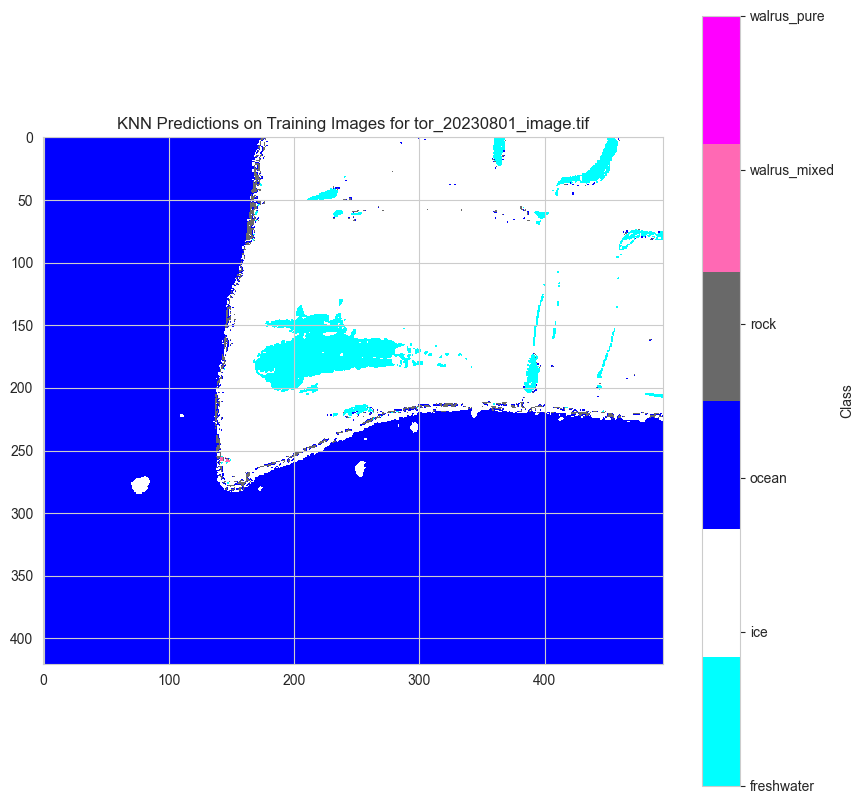

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


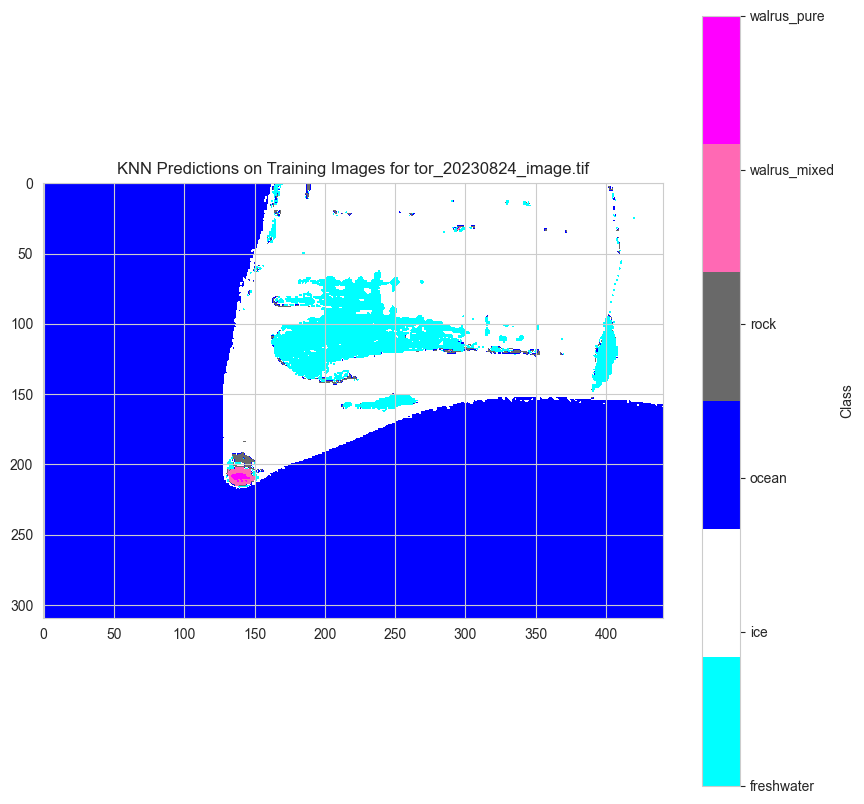

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


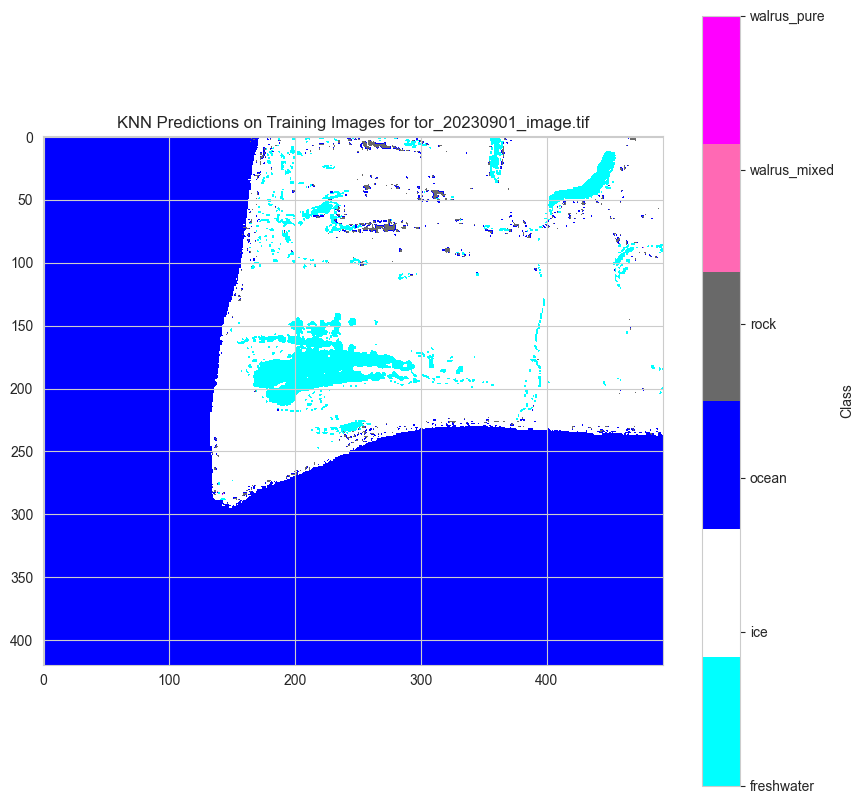

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


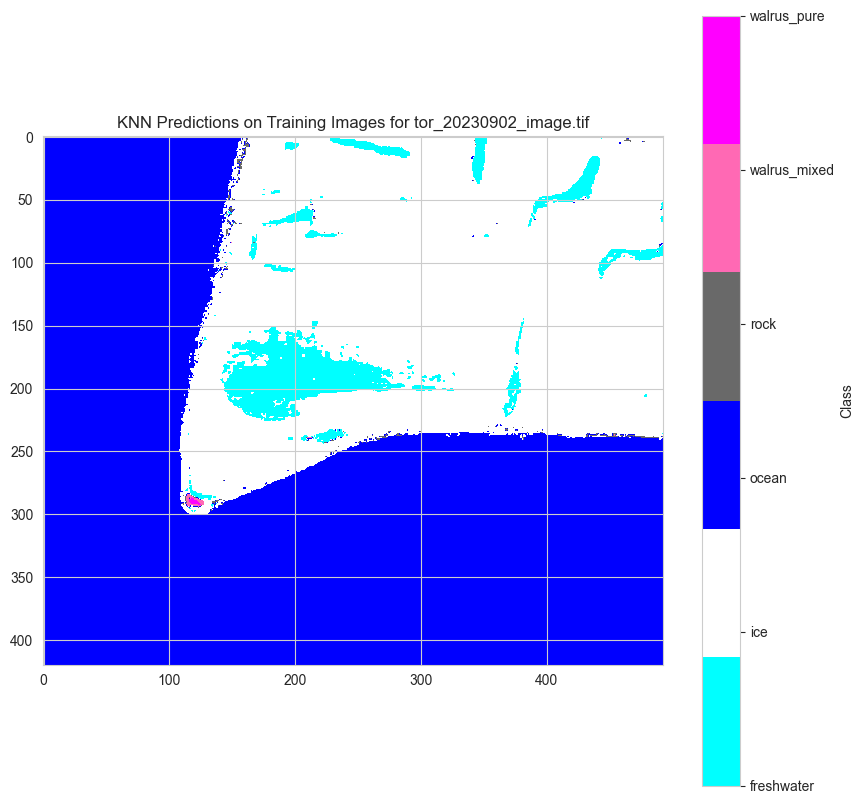

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


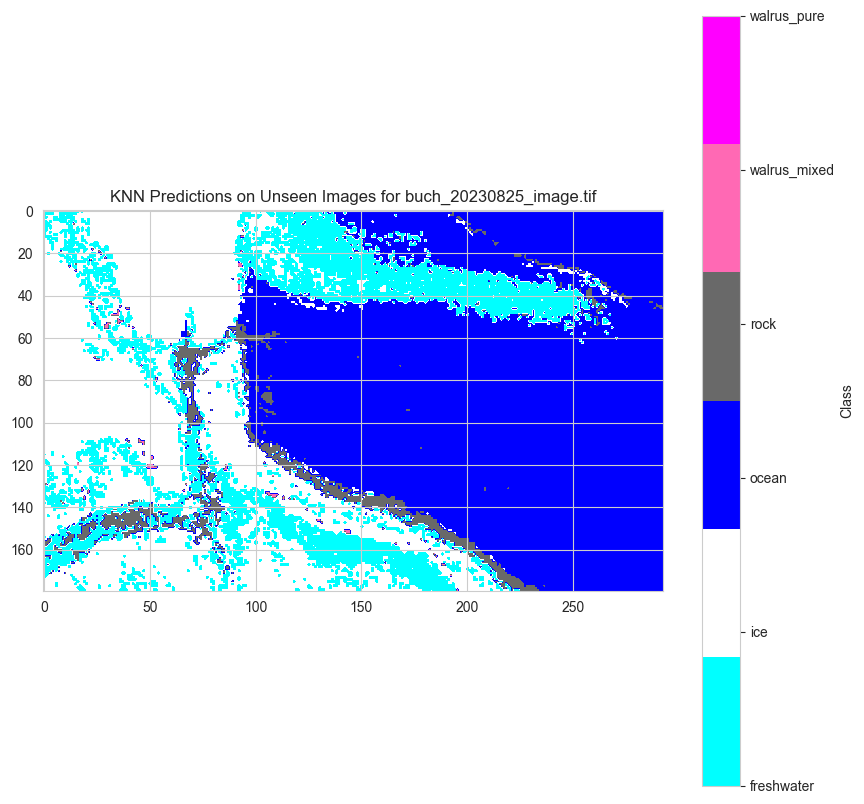

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


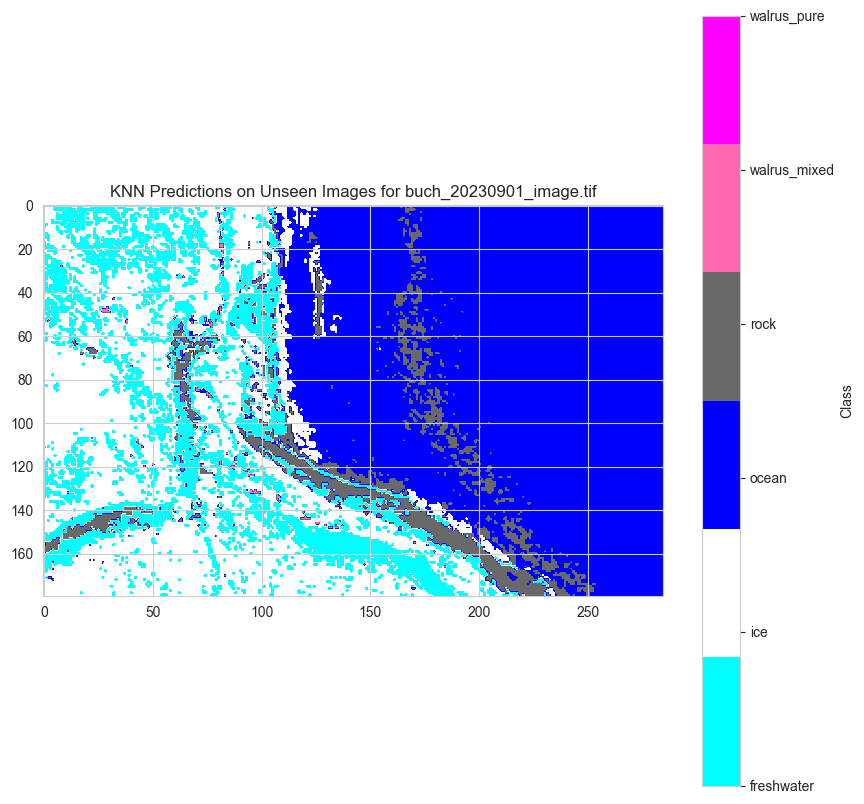

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


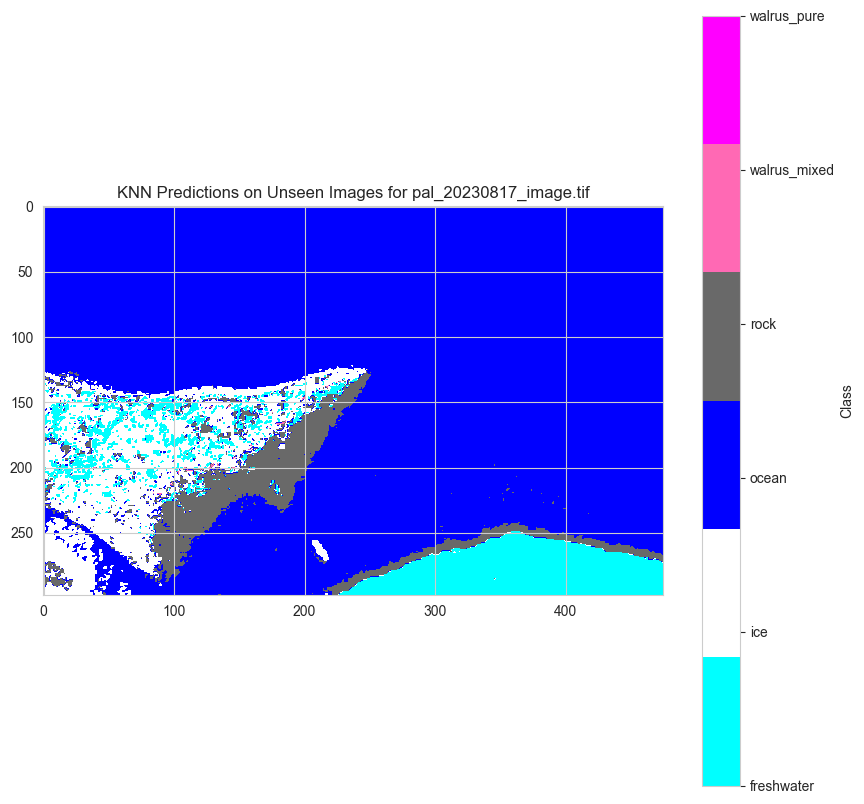

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


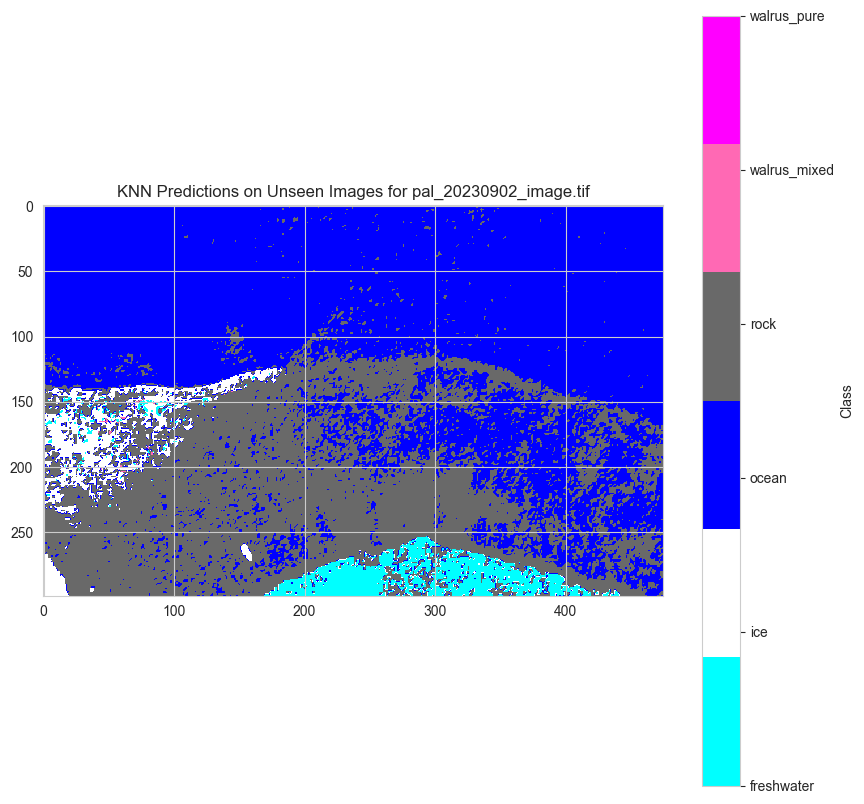

Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


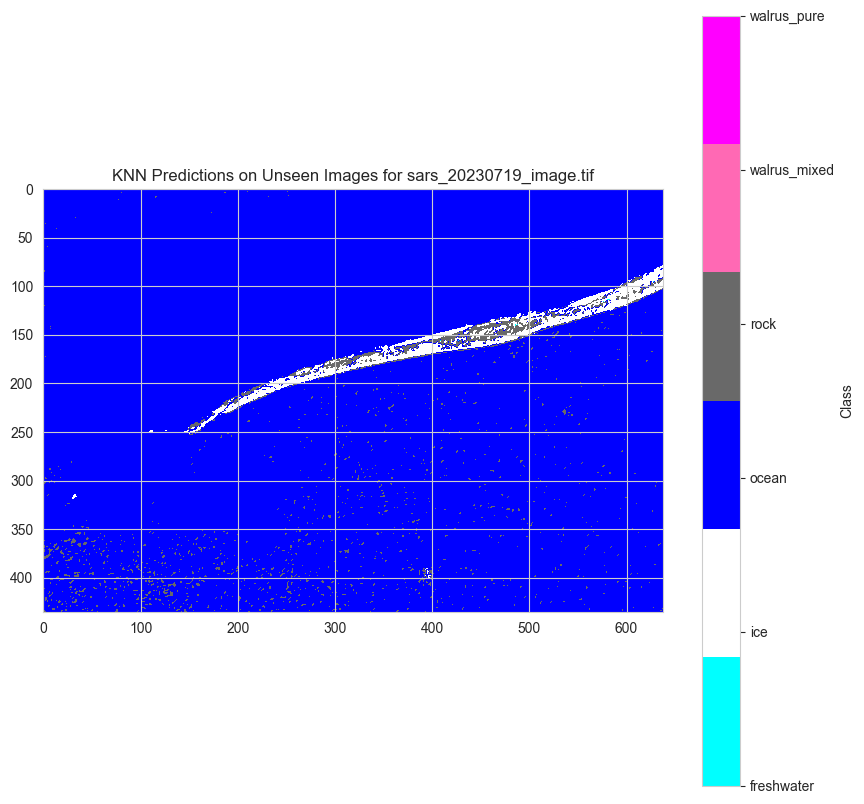

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


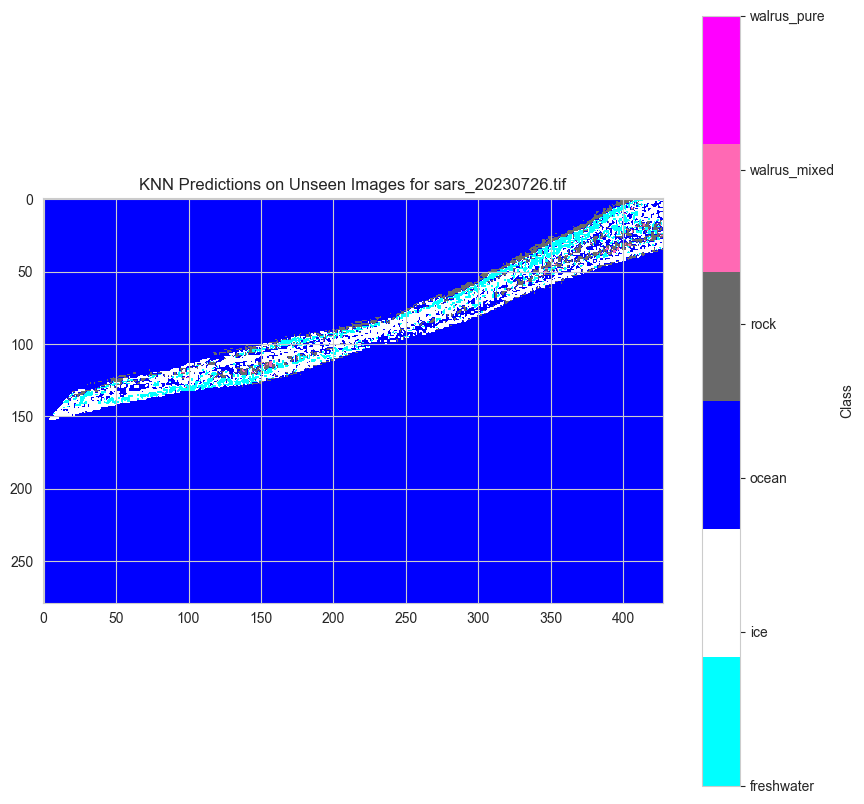

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


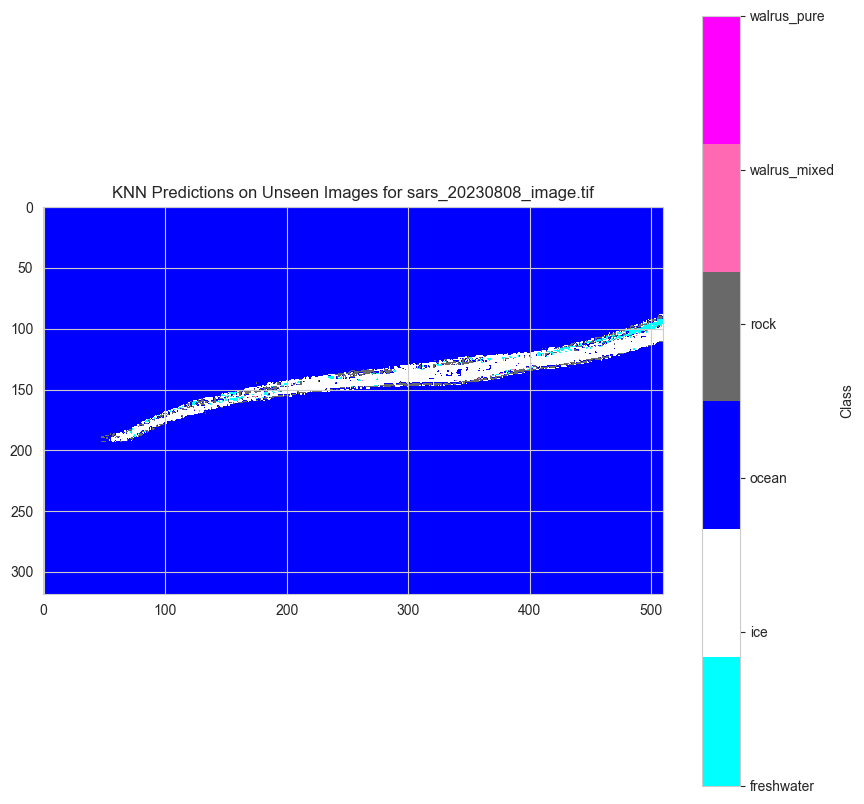

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


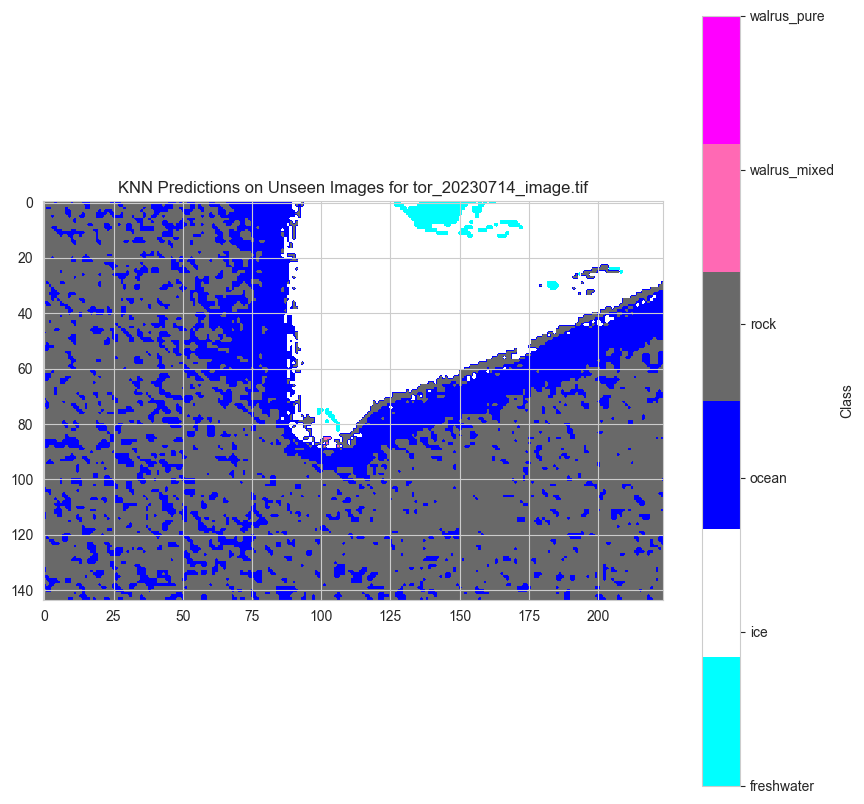

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


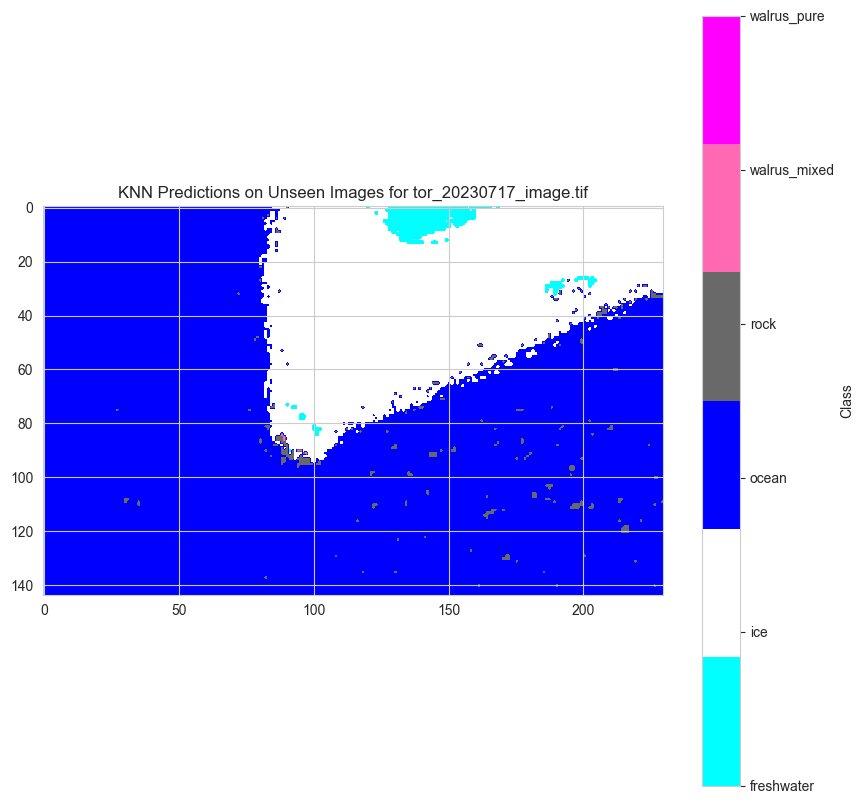

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


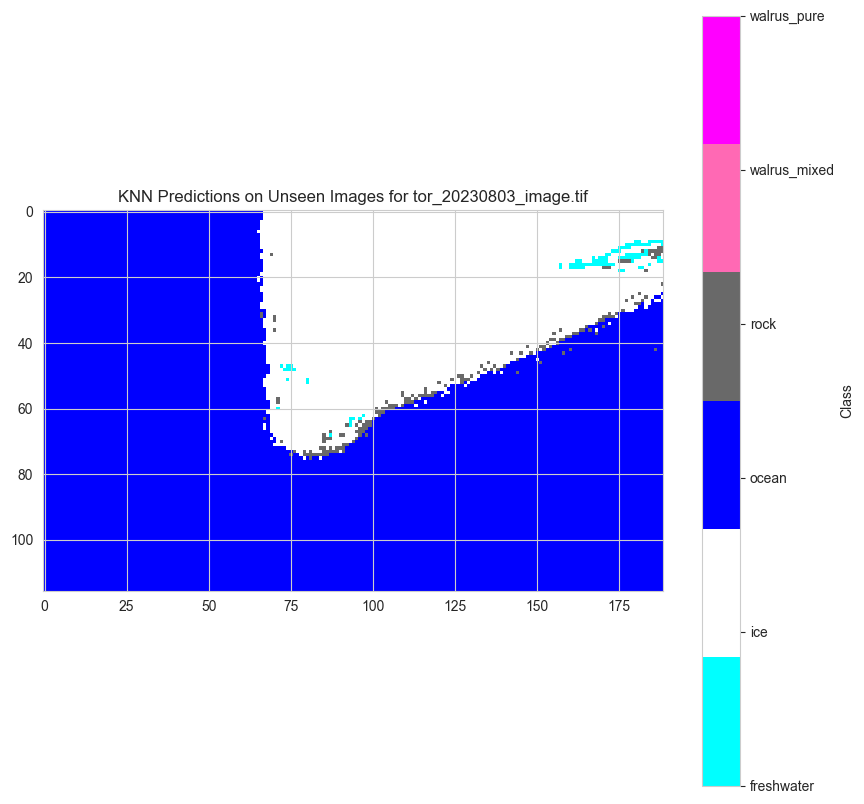

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


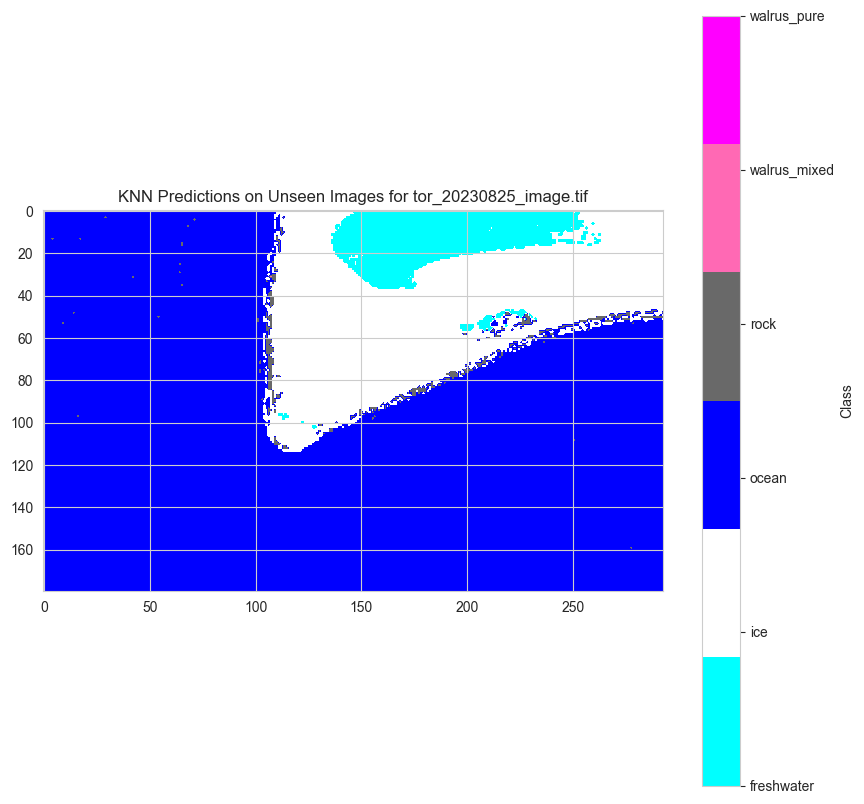

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


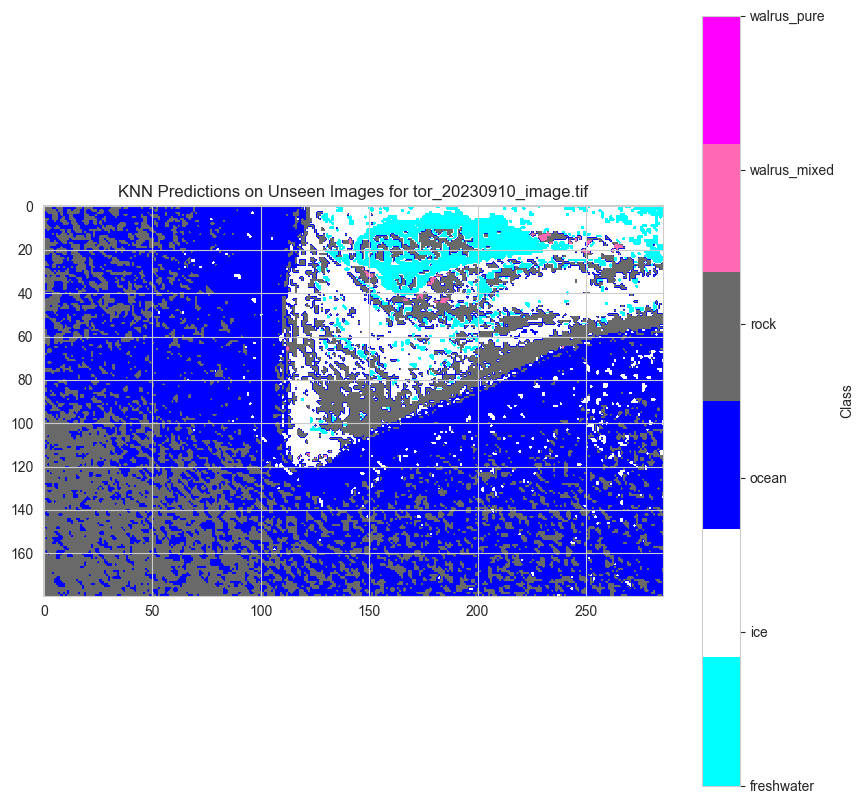


Training and evaluating model: CART
Accuracy: 0.9814915533580552
Precision: 0.9815323410996903
Recall: 0.9814915533580552
F1 Score: 0.9815112918006292
Cohen's Kappa: 0.9643689455702533

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.83      0.84      0.84      8050
         ice       0.97      0.97      0.97     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.96      0.96      0.96     18572
walrus_mixed       0.37      0.39      0.38       165
 walrus_pure       0.67      0.60      0.63        10

    accuracy                           0.98    242700
   macro avg       0.80      0.79      0.79    242700
weighted avg       0.98      0.98      0.98    242700


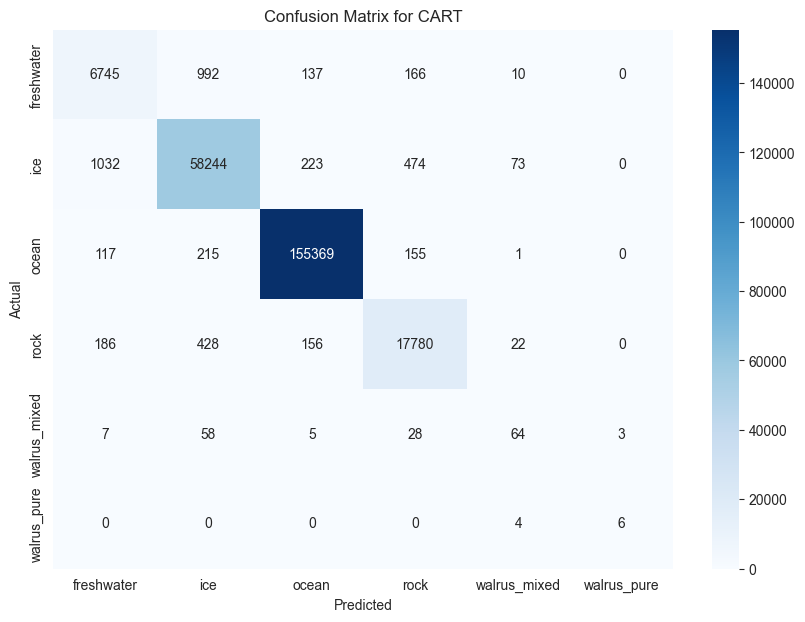

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


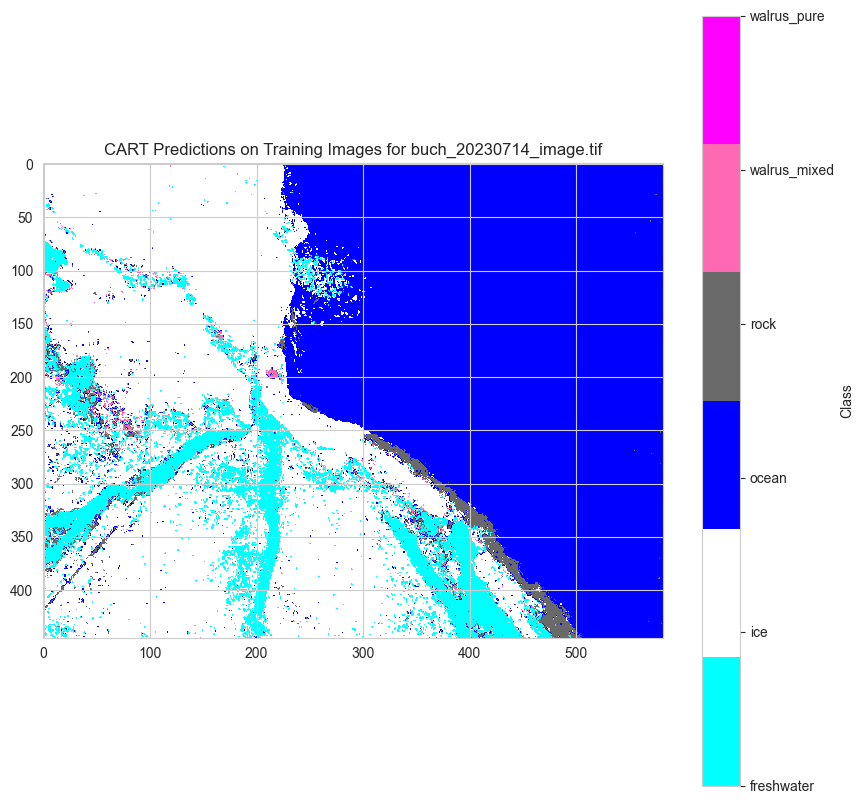

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


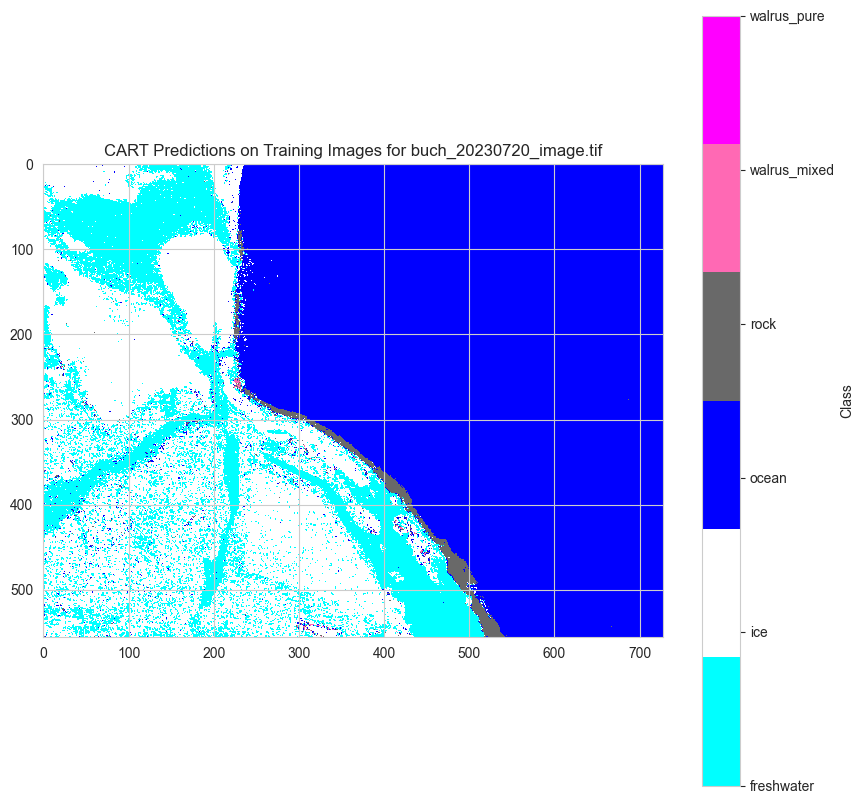

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


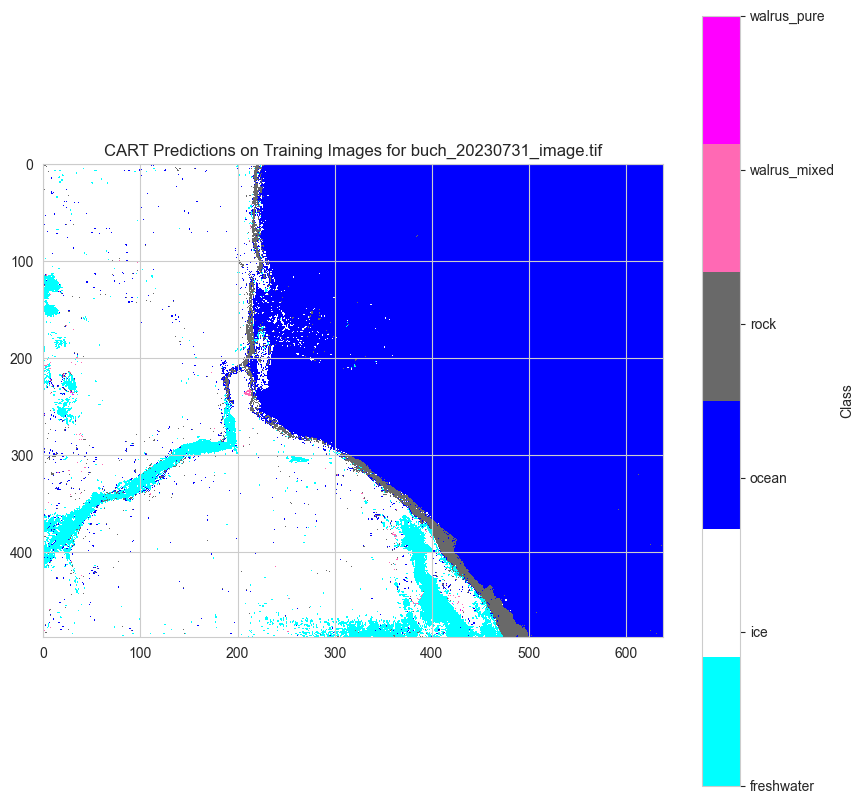

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


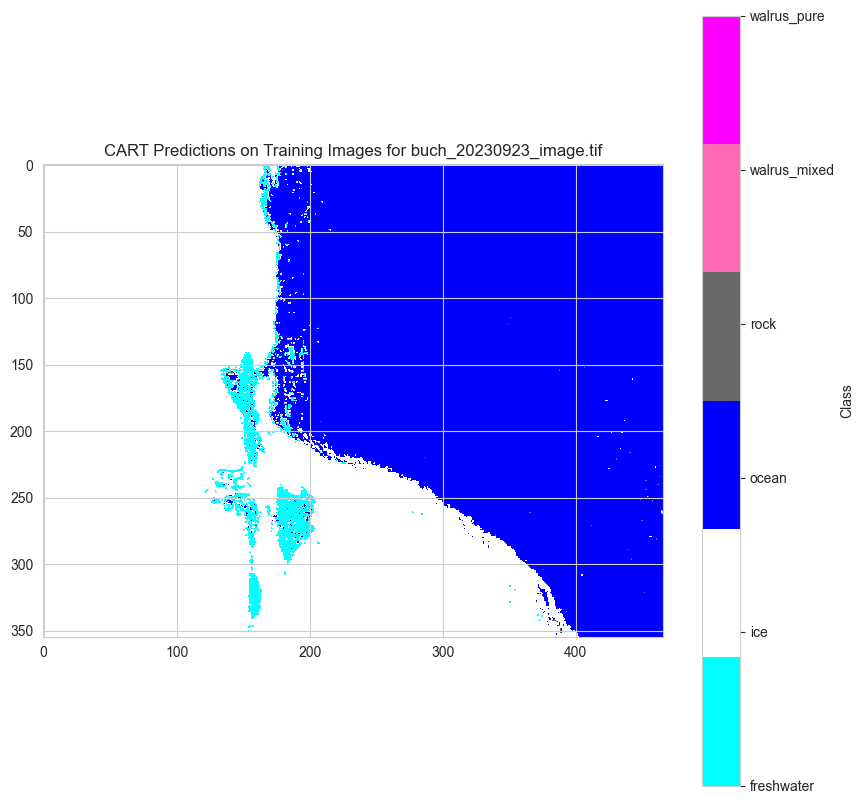

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


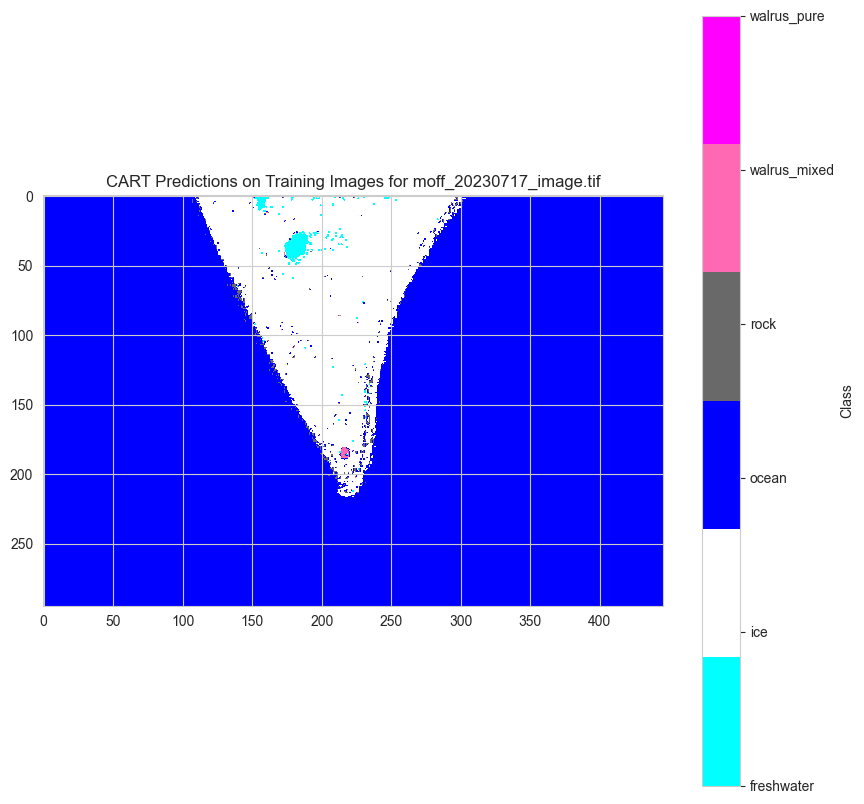

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


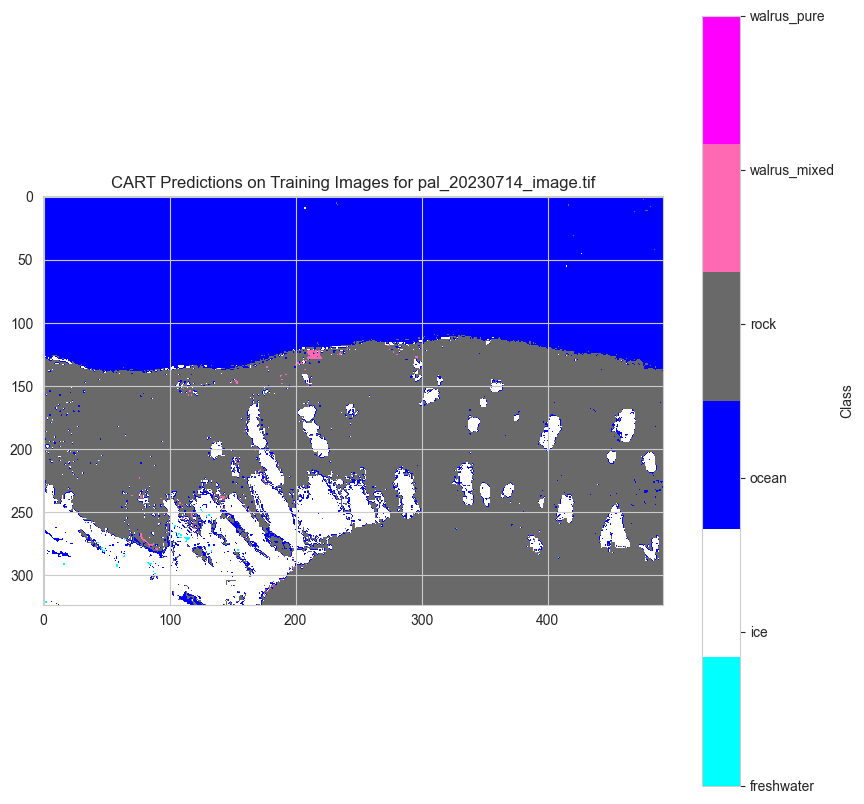

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


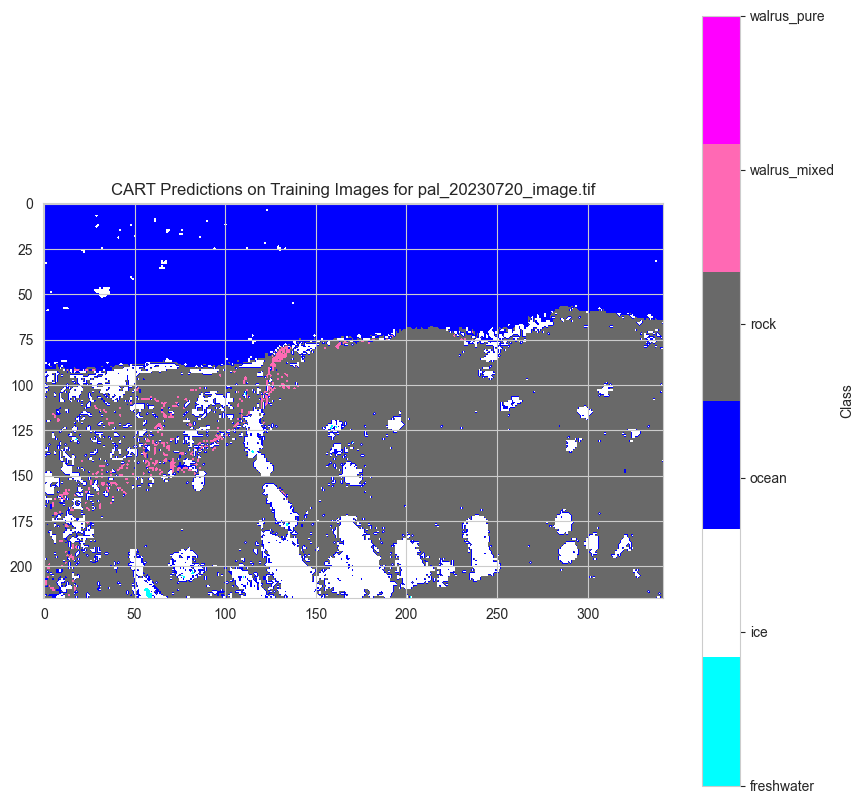

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


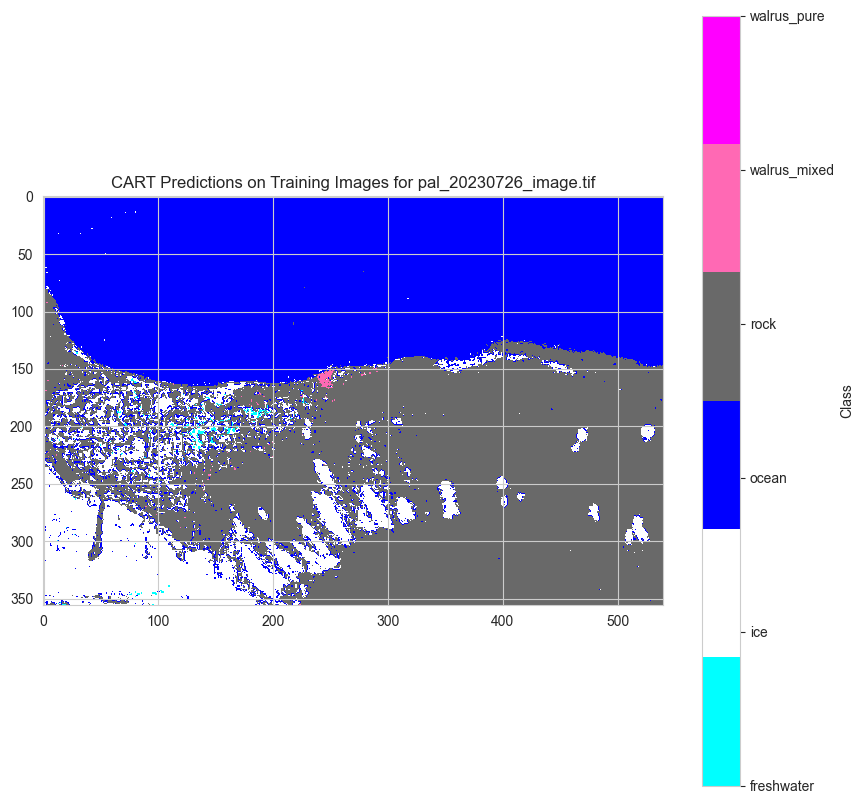

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


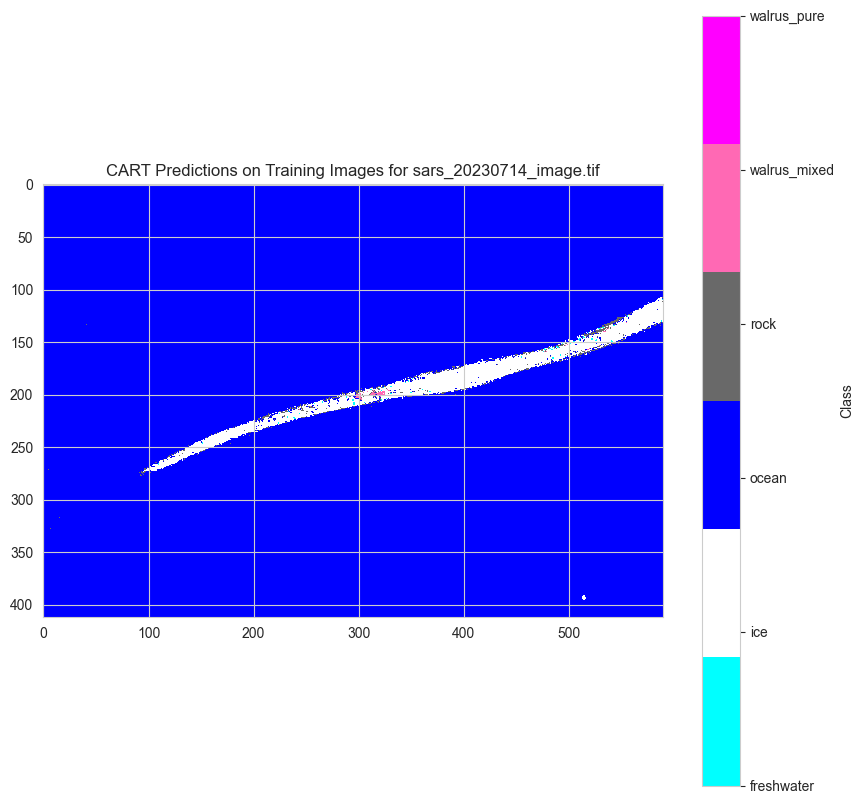

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


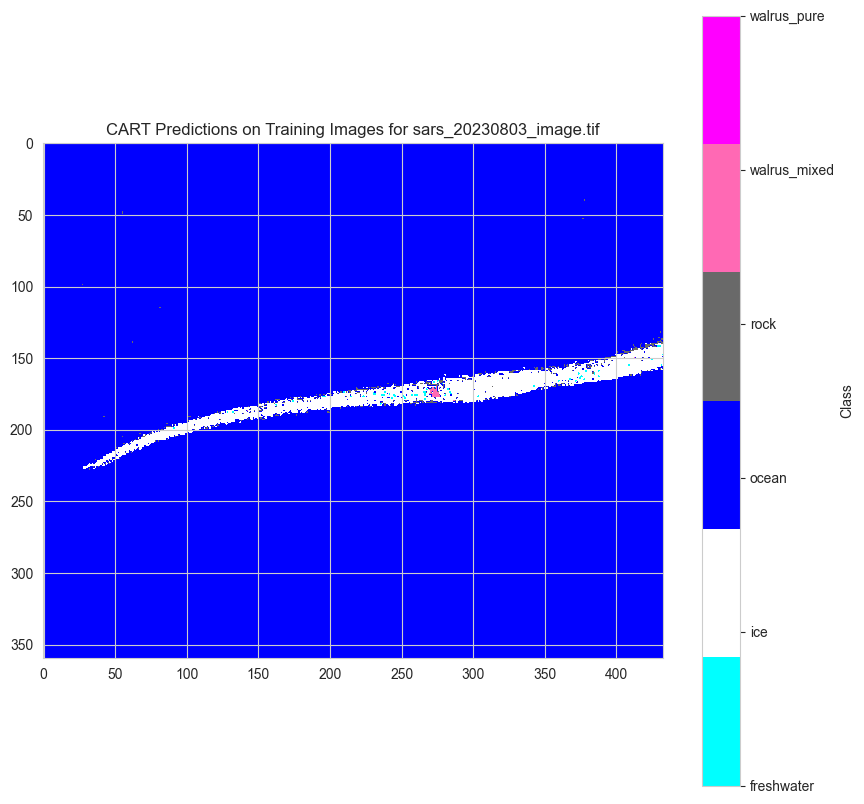

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


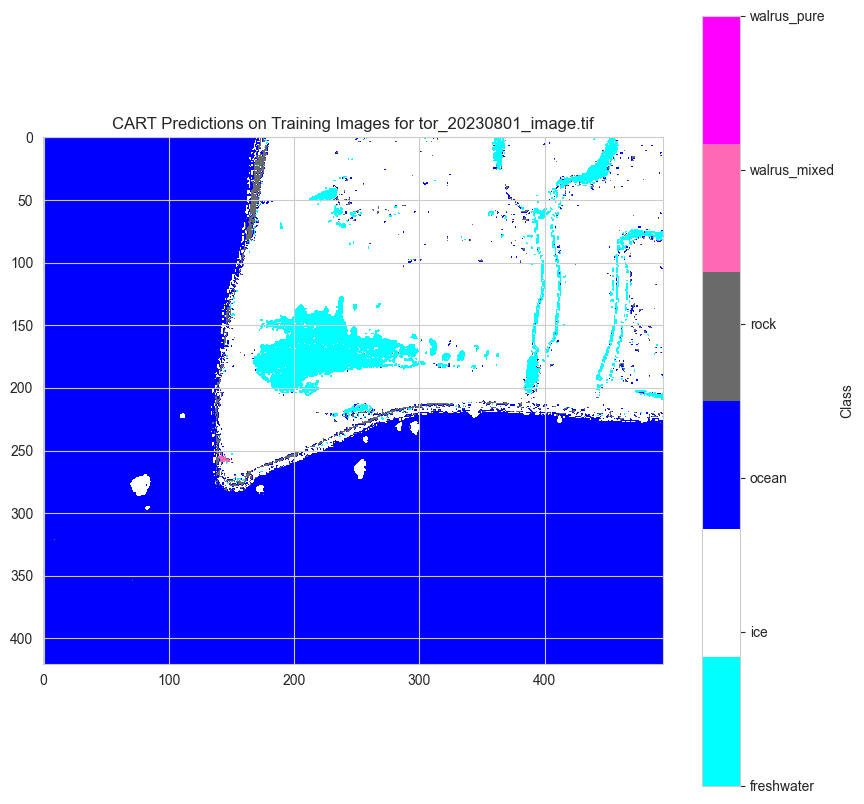

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


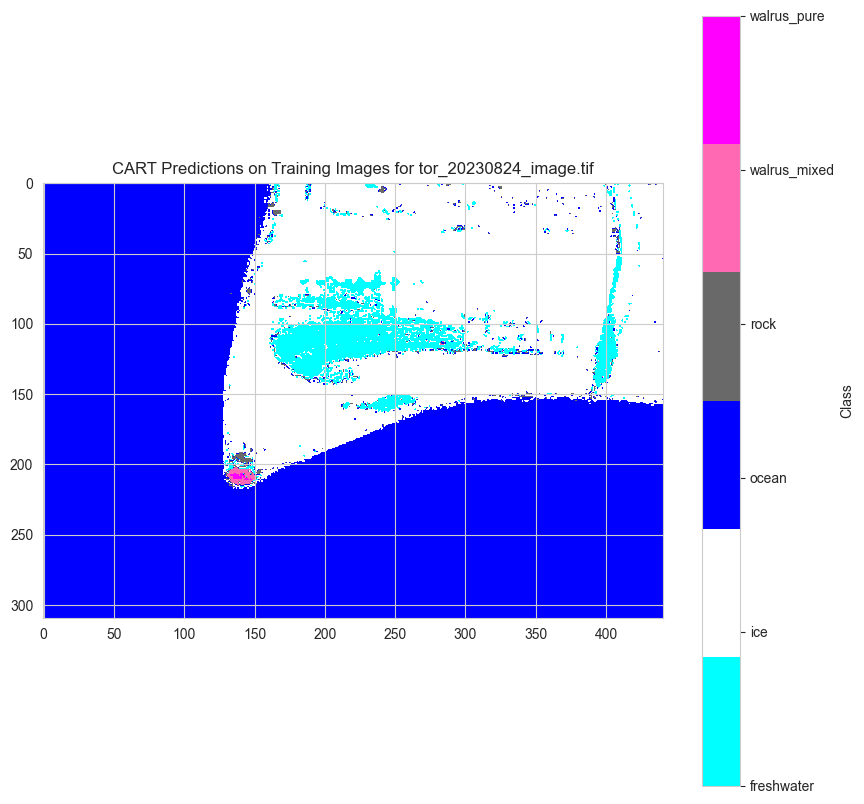

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


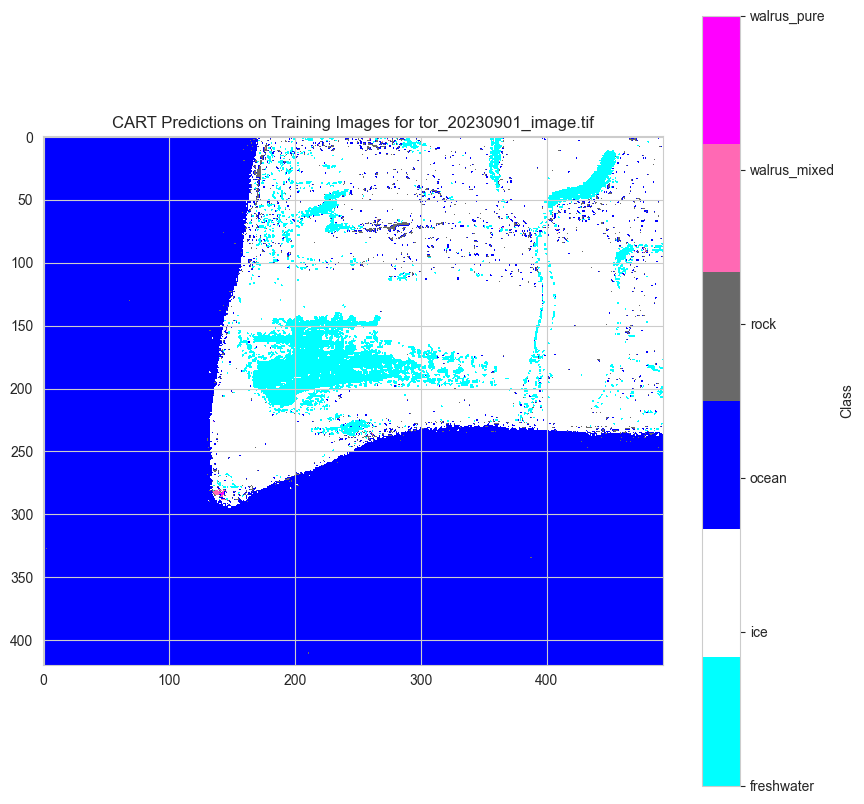

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


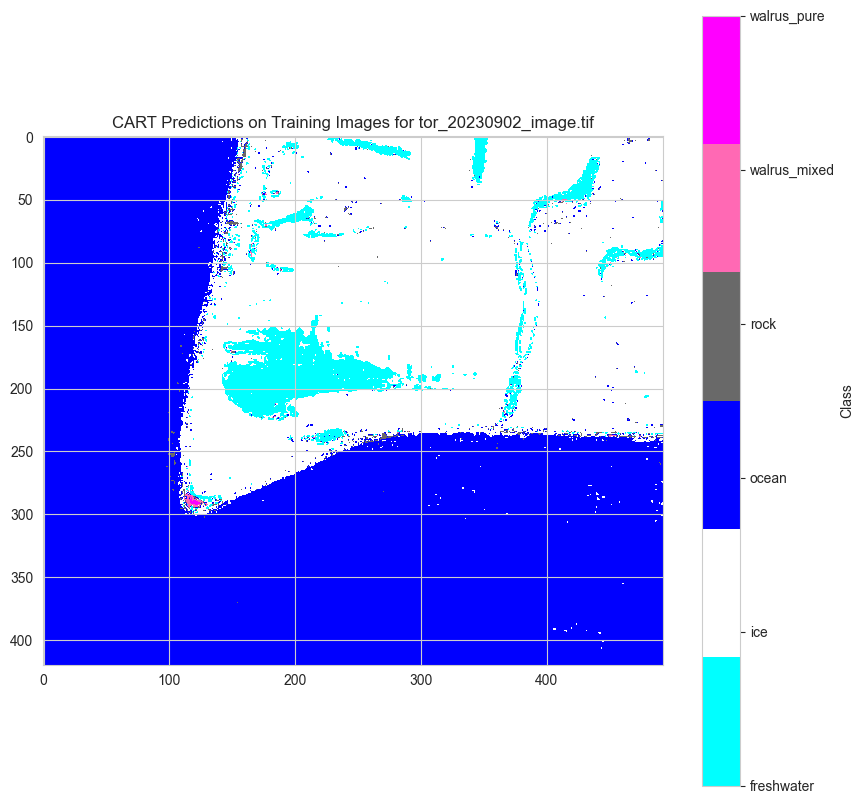

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


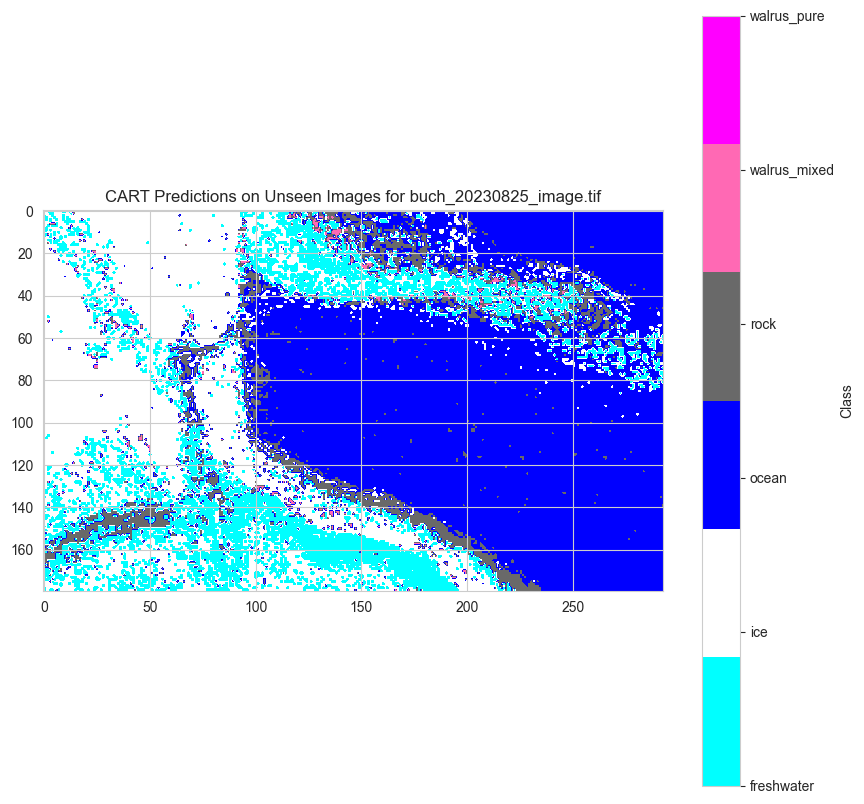

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


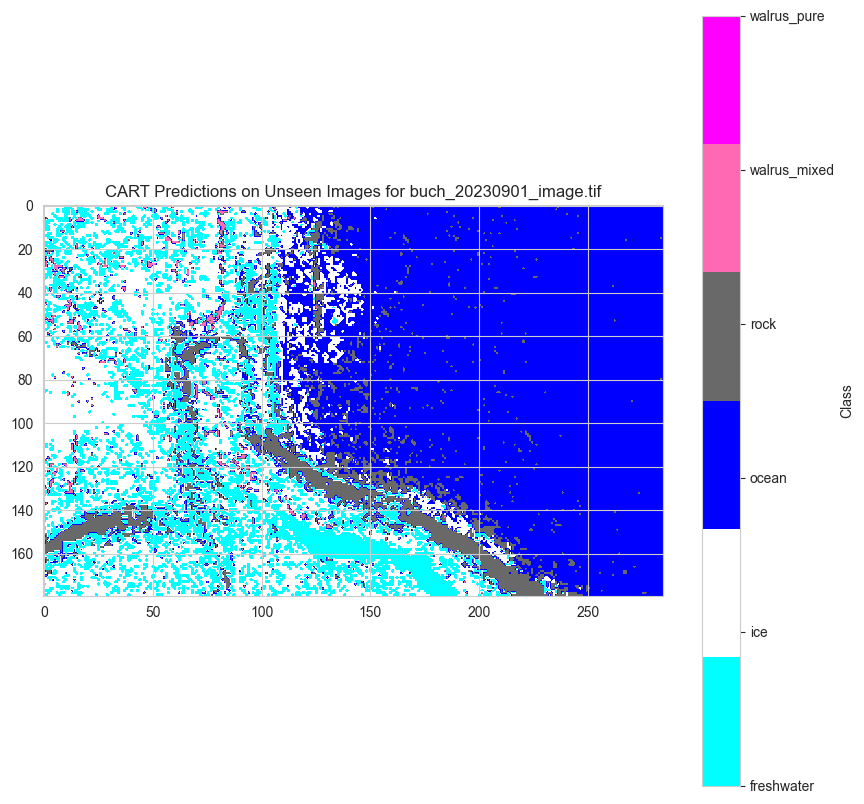

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


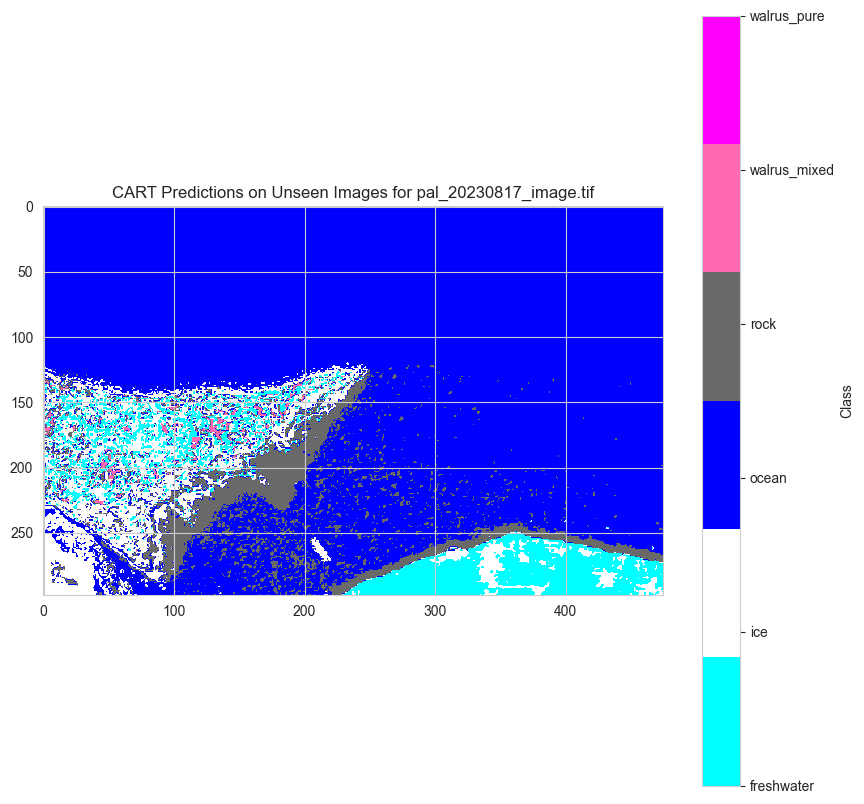

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


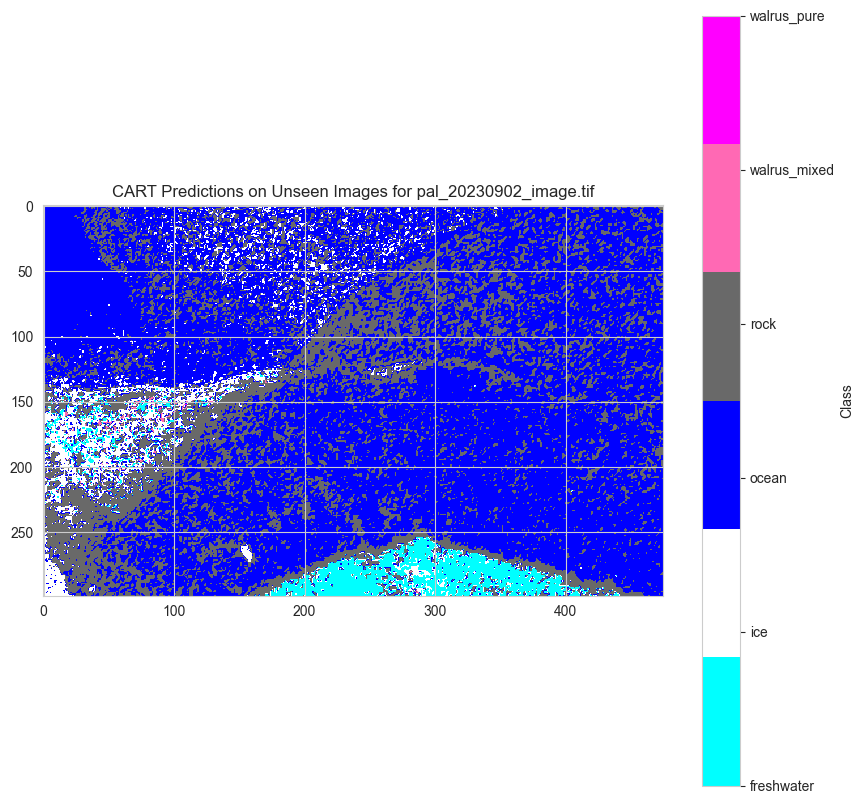

Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


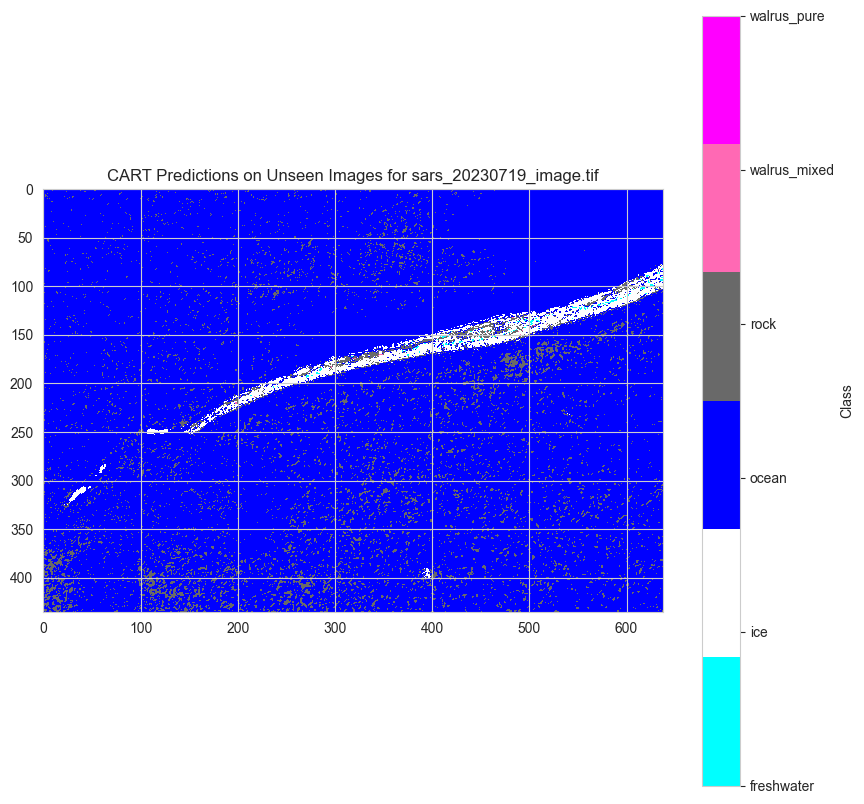

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


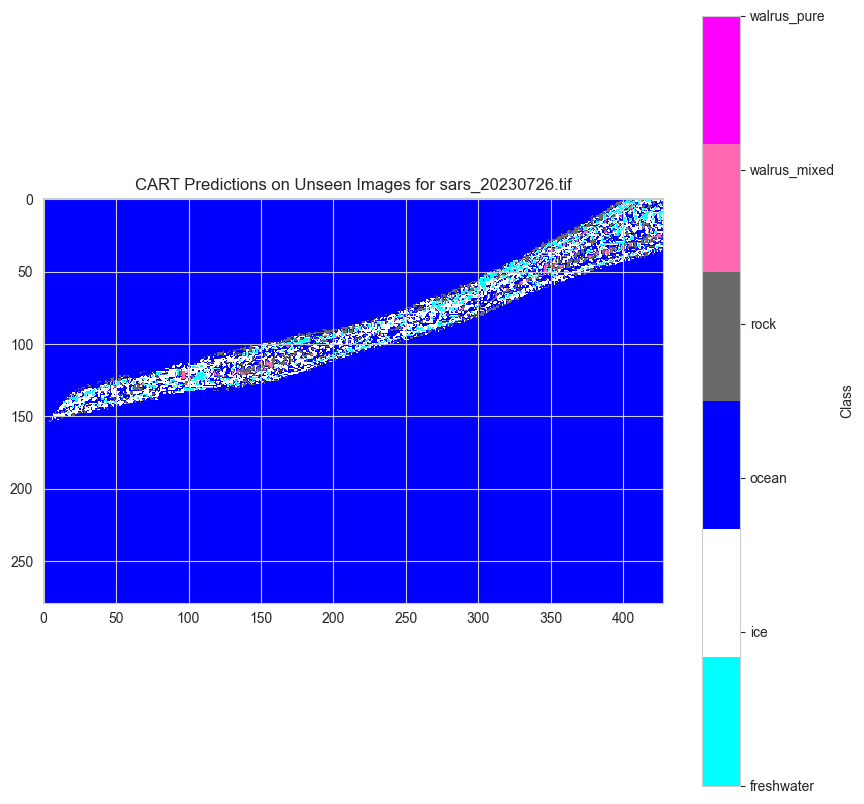

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


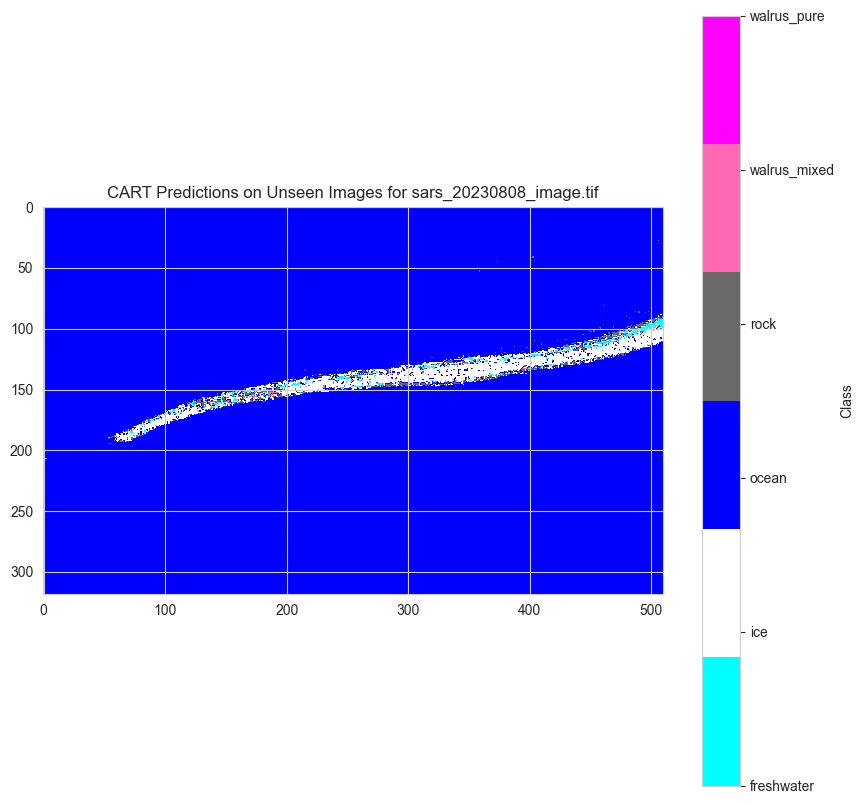

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


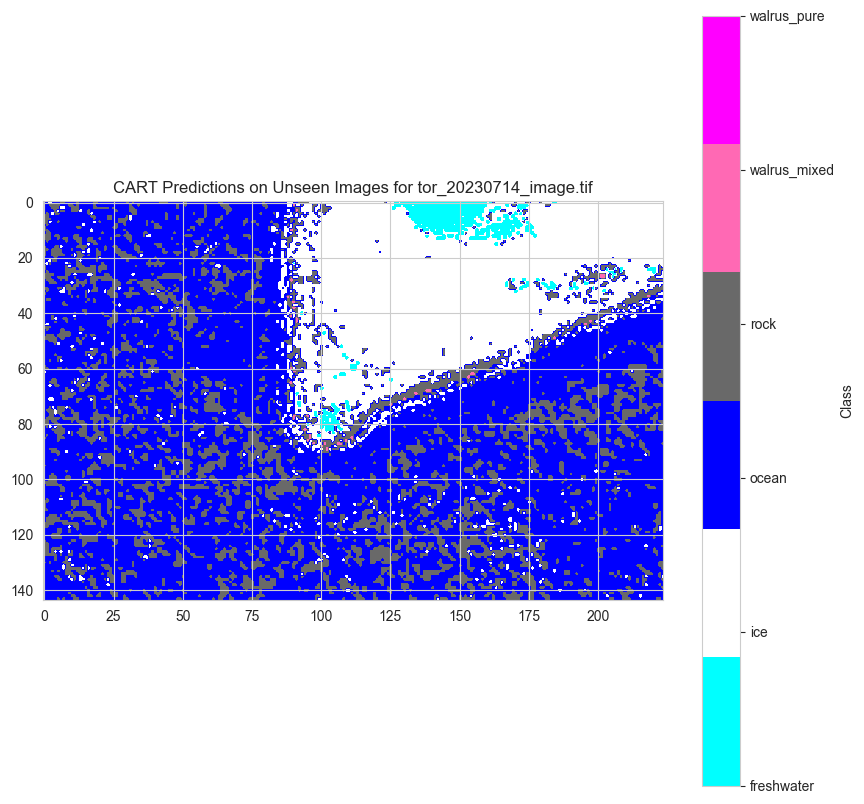

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


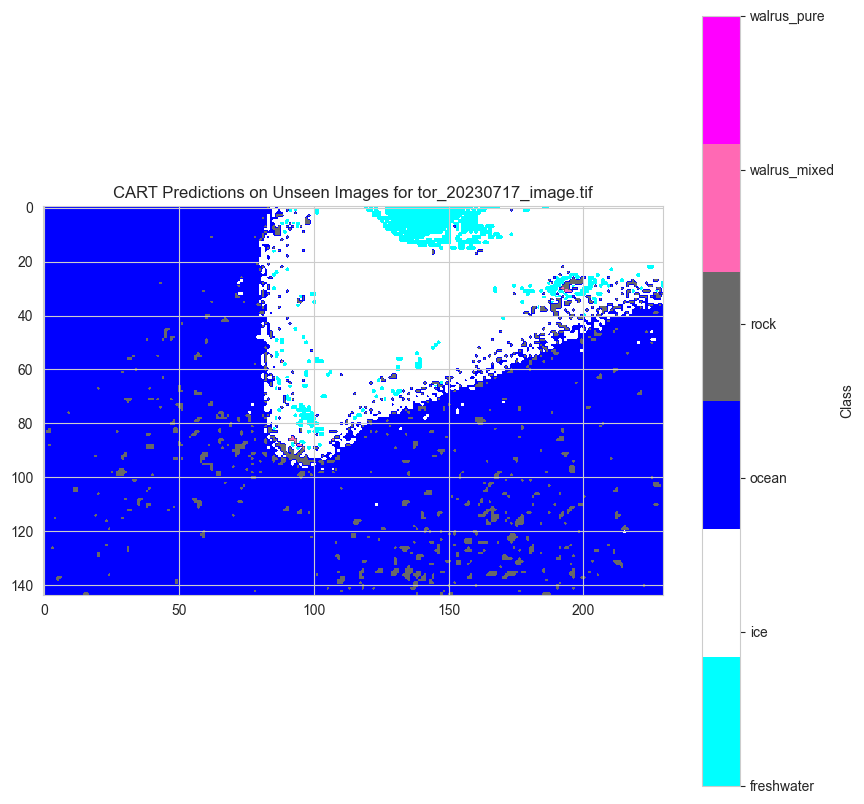

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


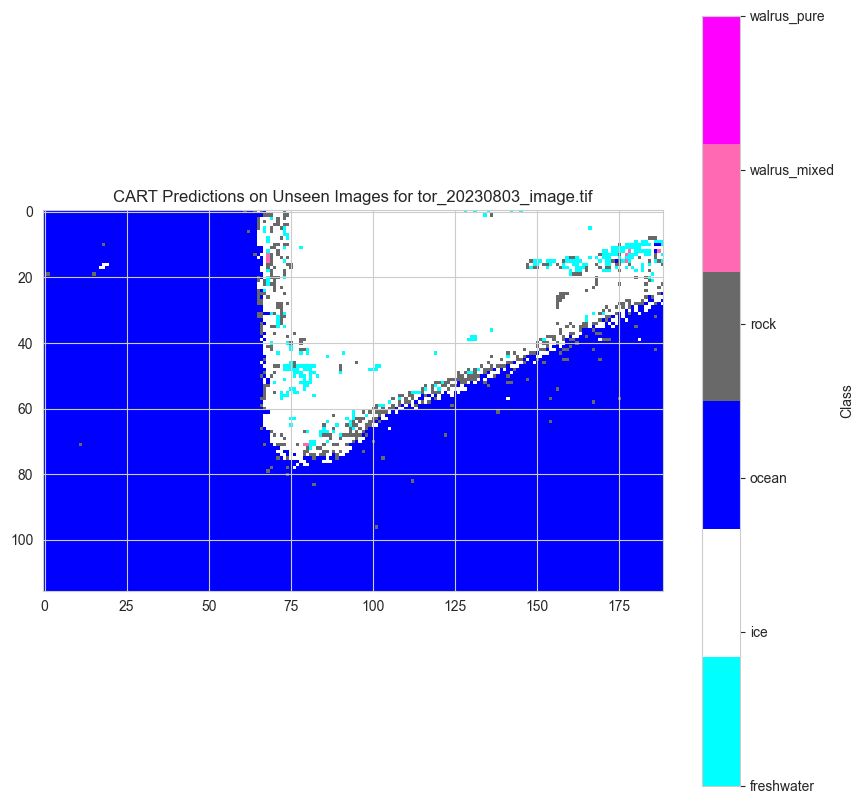

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


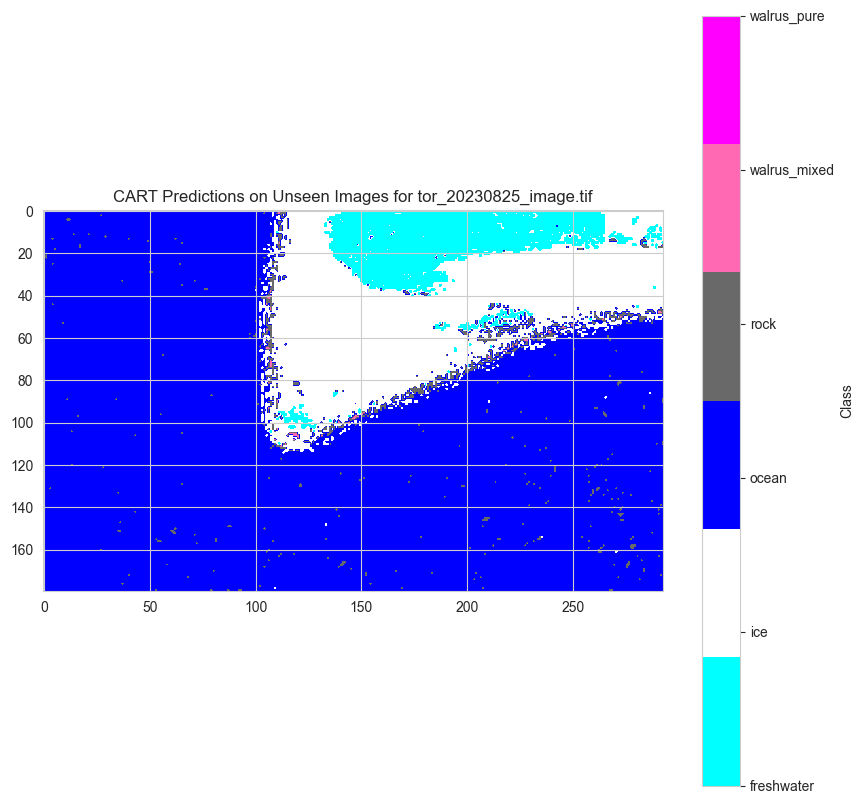

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


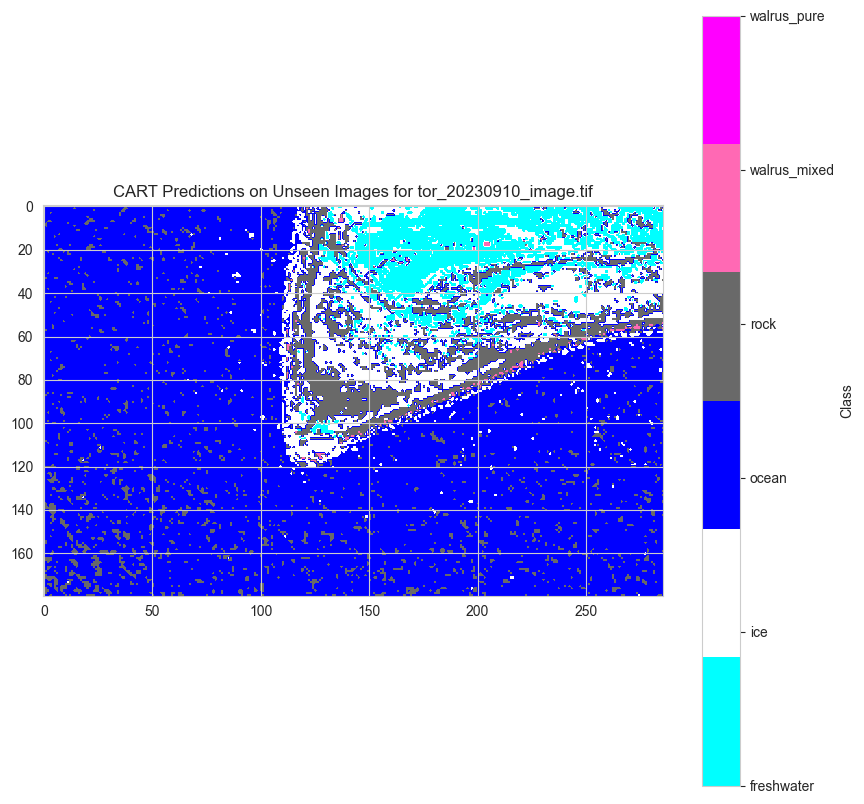


Training and evaluating model: NB
Accuracy: 0.7198516687268233
Precision: 0.8481424286851615
Recall: 0.7198516687268233
F1 Score: 0.7603498893831647
Cohen's Kappa: 0.5054187041467619

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.29      0.20      0.24      8050
         ice       0.88      0.42      0.57     60046
       ocean       0.94      0.89      0.92    155857
        rock       0.23      0.46      0.30     18572
walrus_mixed       0.00      0.38      0.01       165
 walrus_pure       0.01      0.80      0.02        10

    accuracy                           0.72    242700
   macro avg       0.39      0.53      0.34    242700
weighted avg       0.85      0.72      0.76    242700


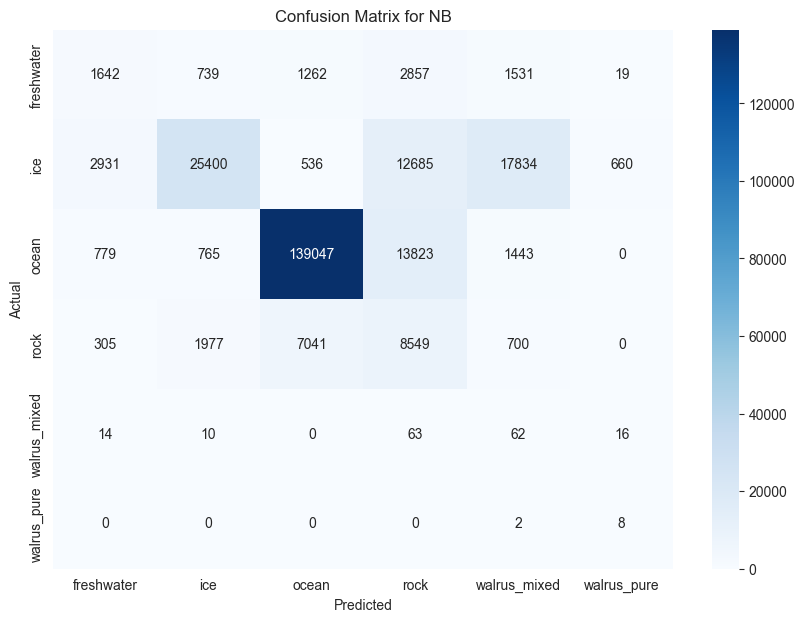

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


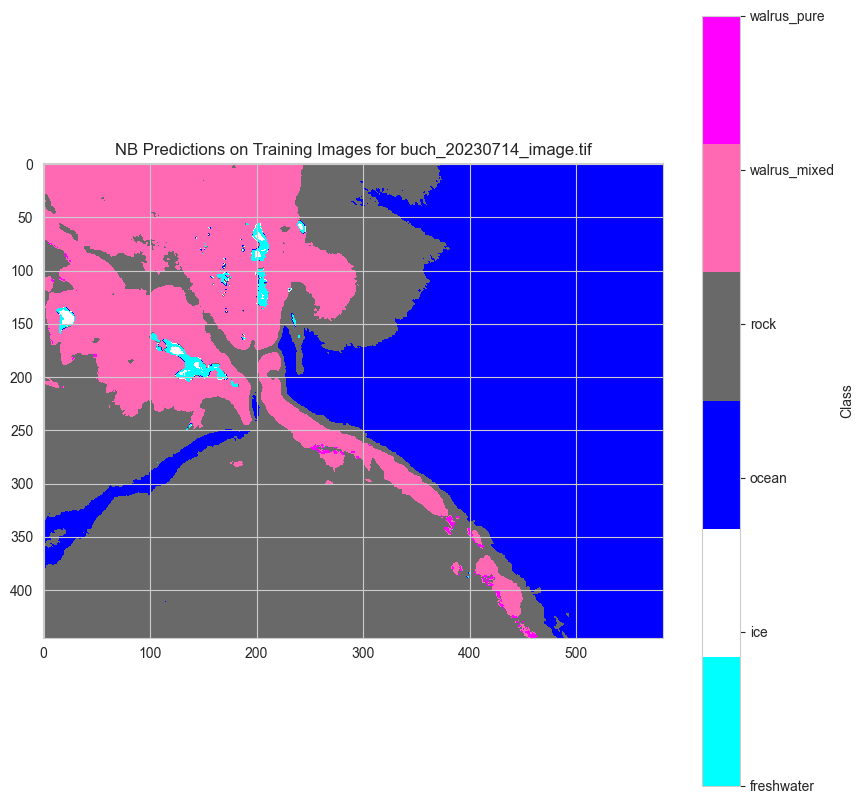

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


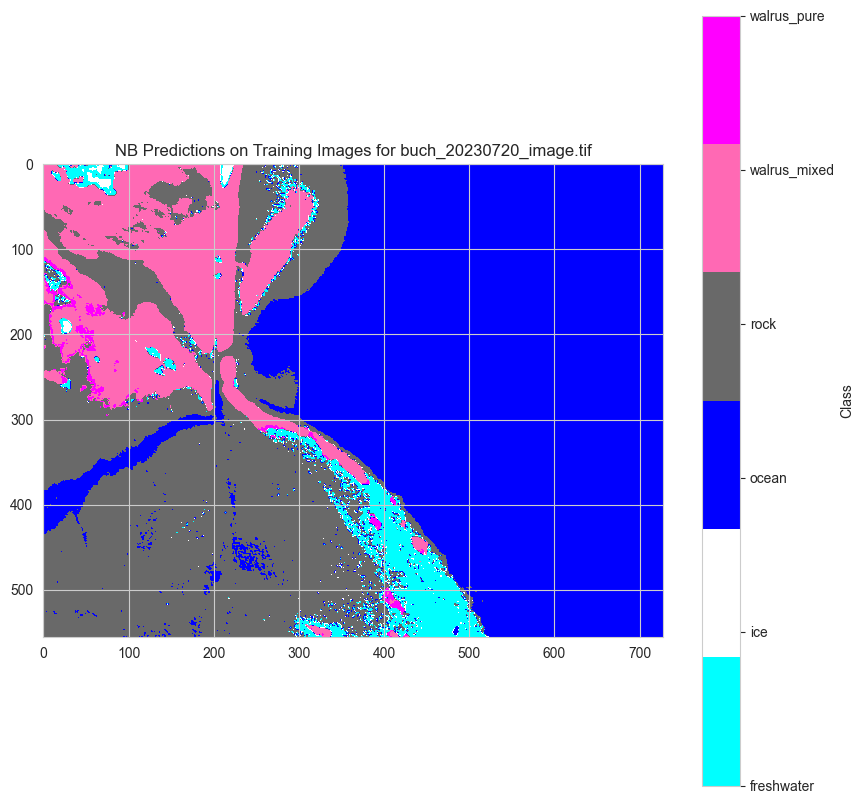

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


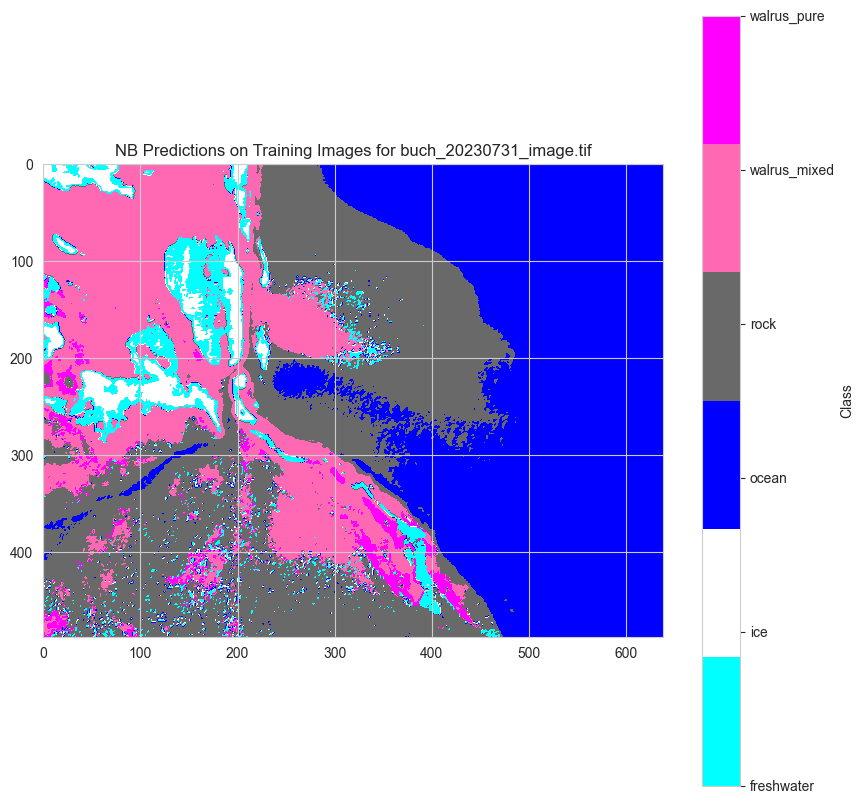

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


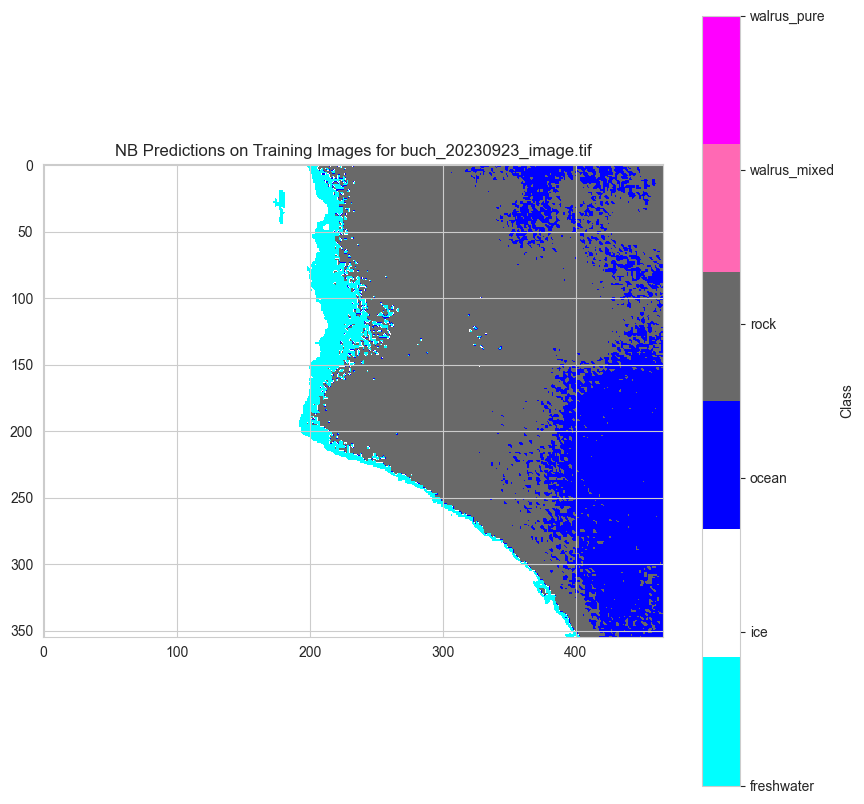

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


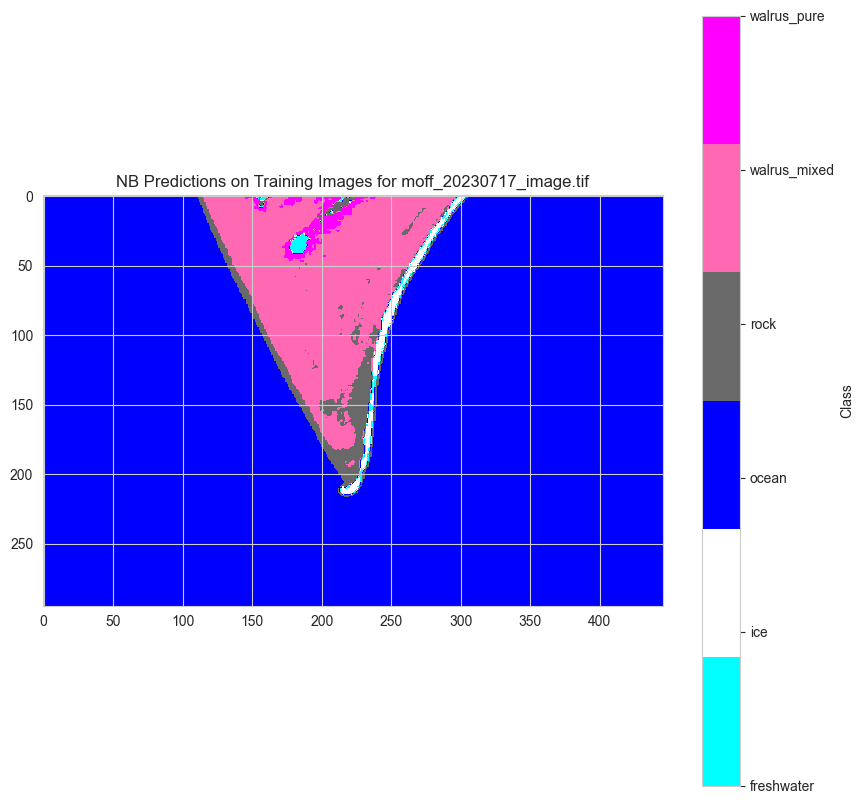

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


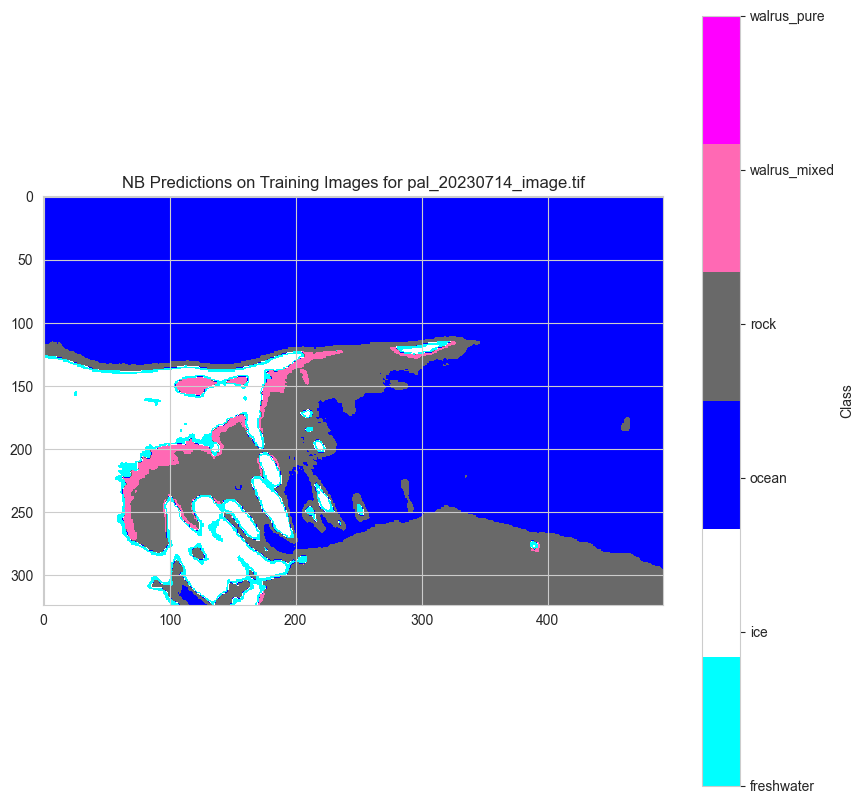

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


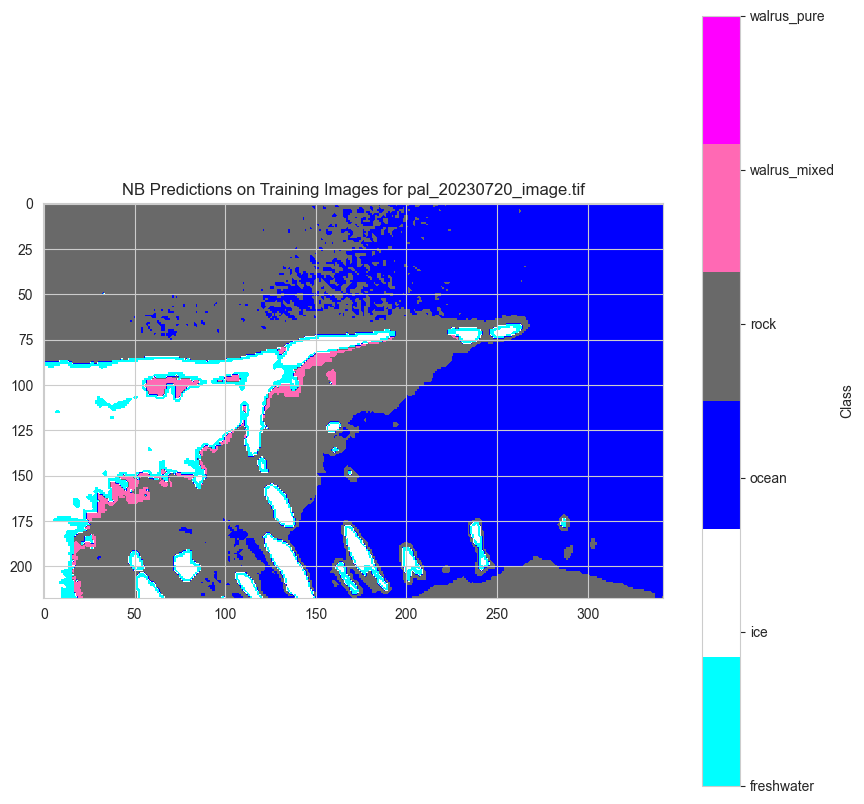

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


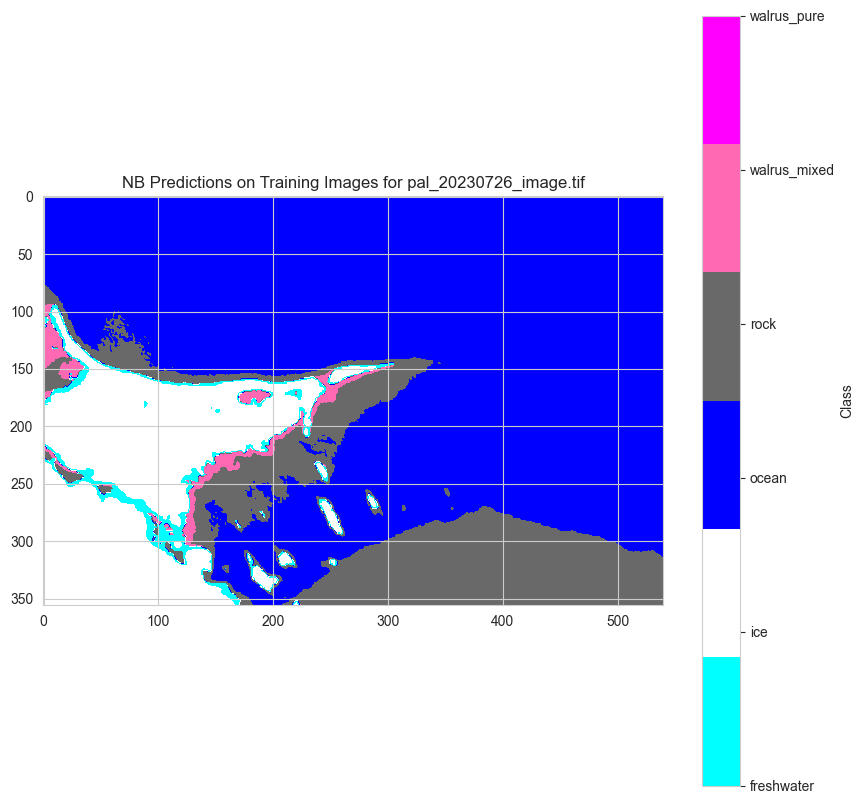

Labels present in sars_20230714_image.tif: ['freshwater', 'ocean', 'rock', 'walrus_mixed']


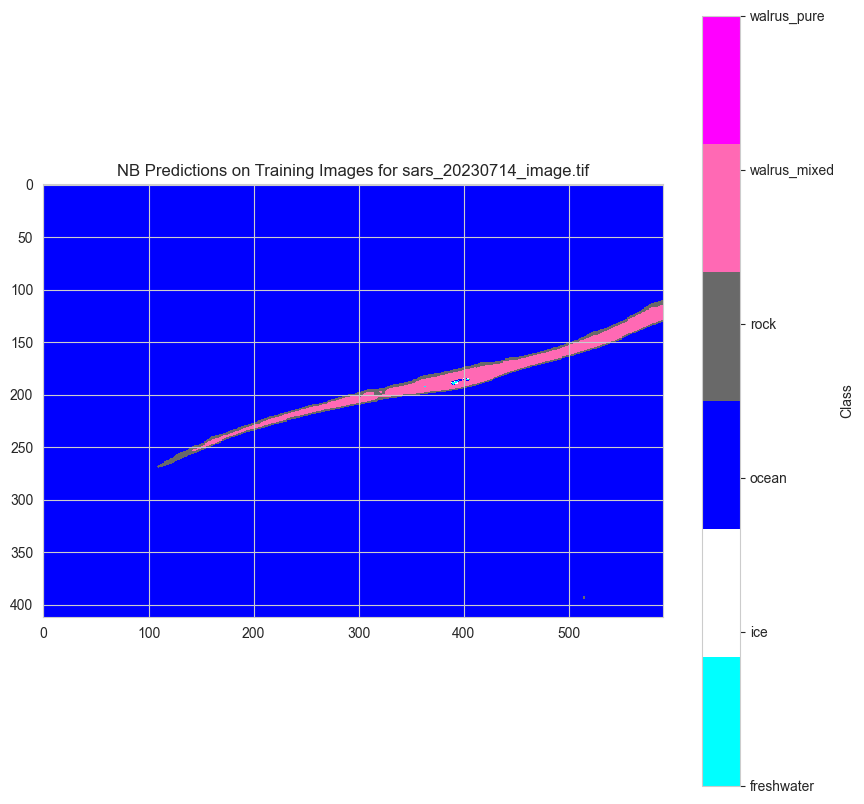

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


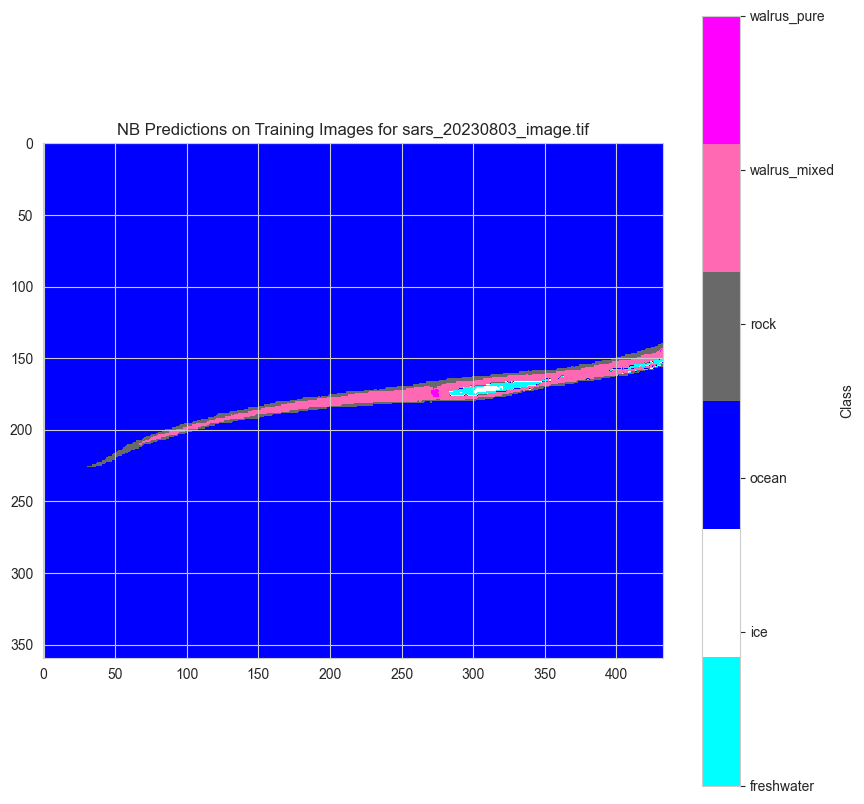

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


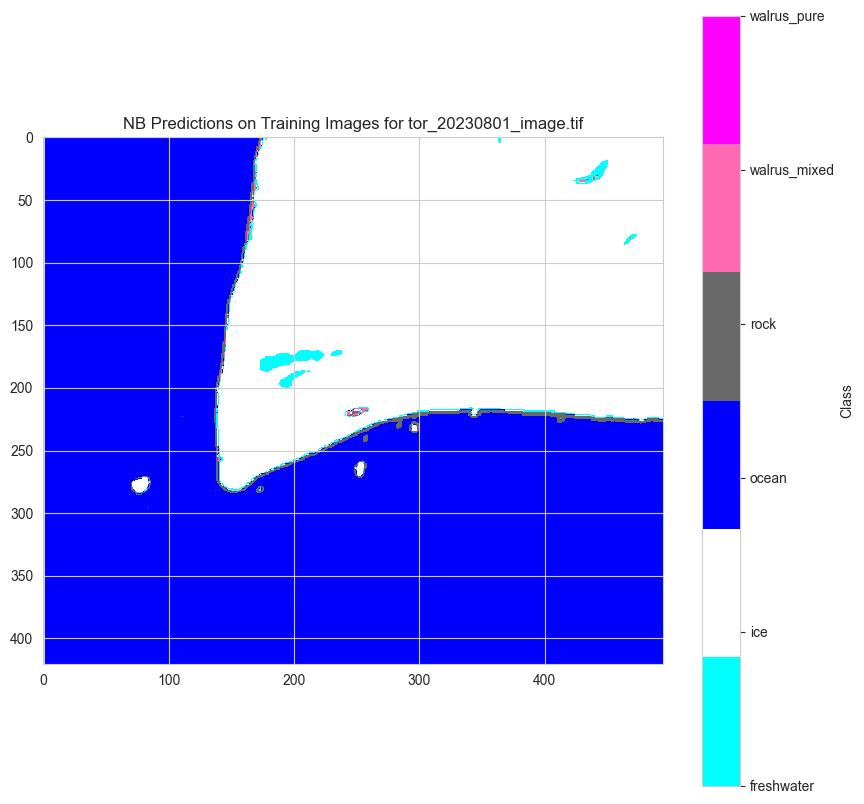

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


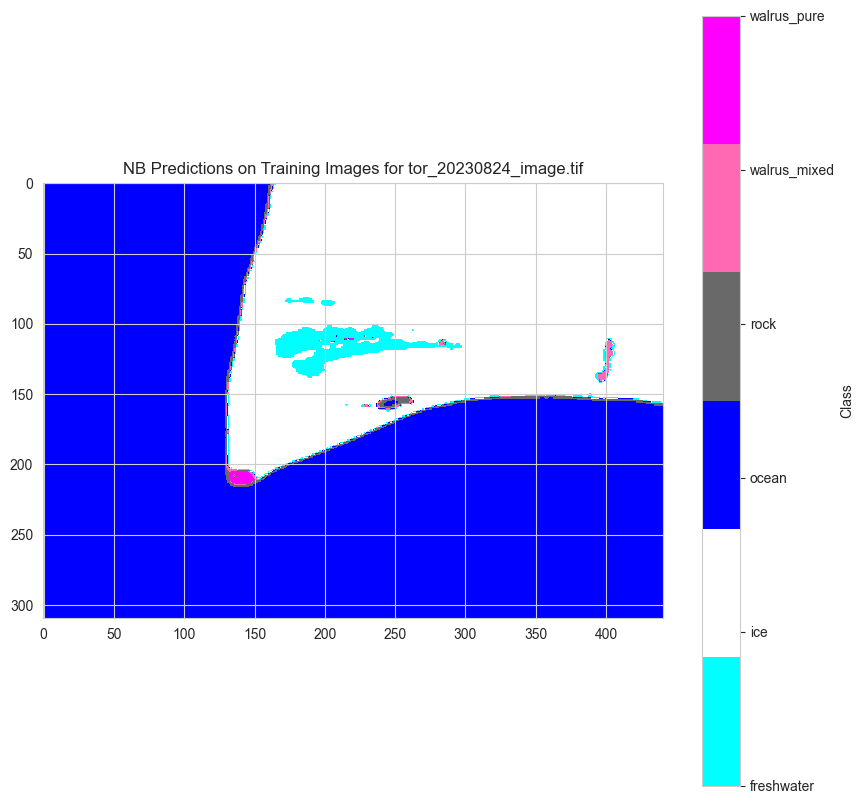

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


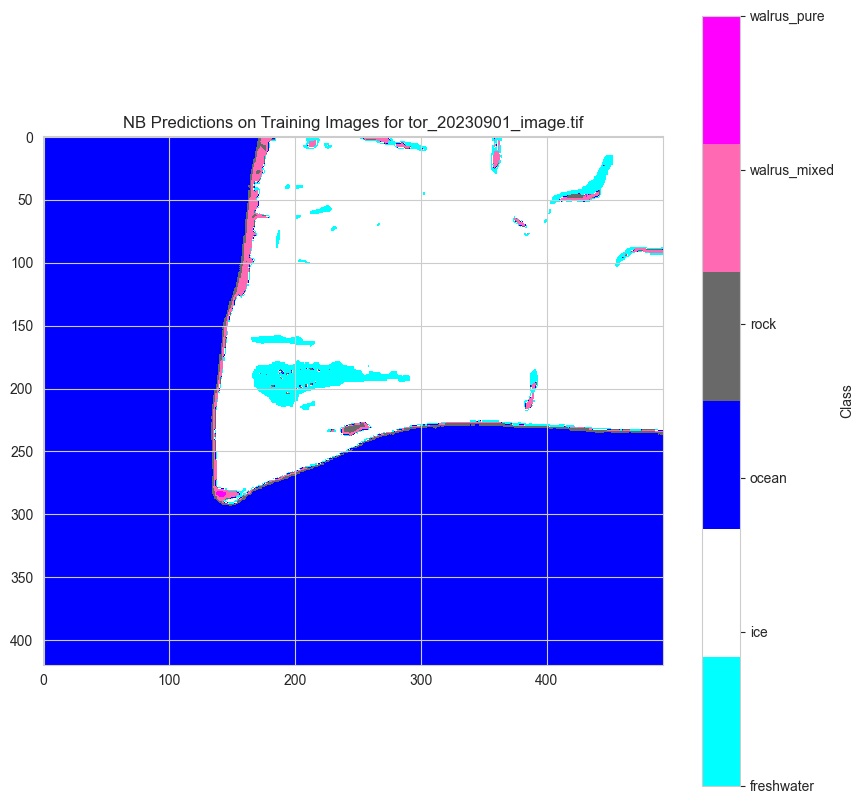

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


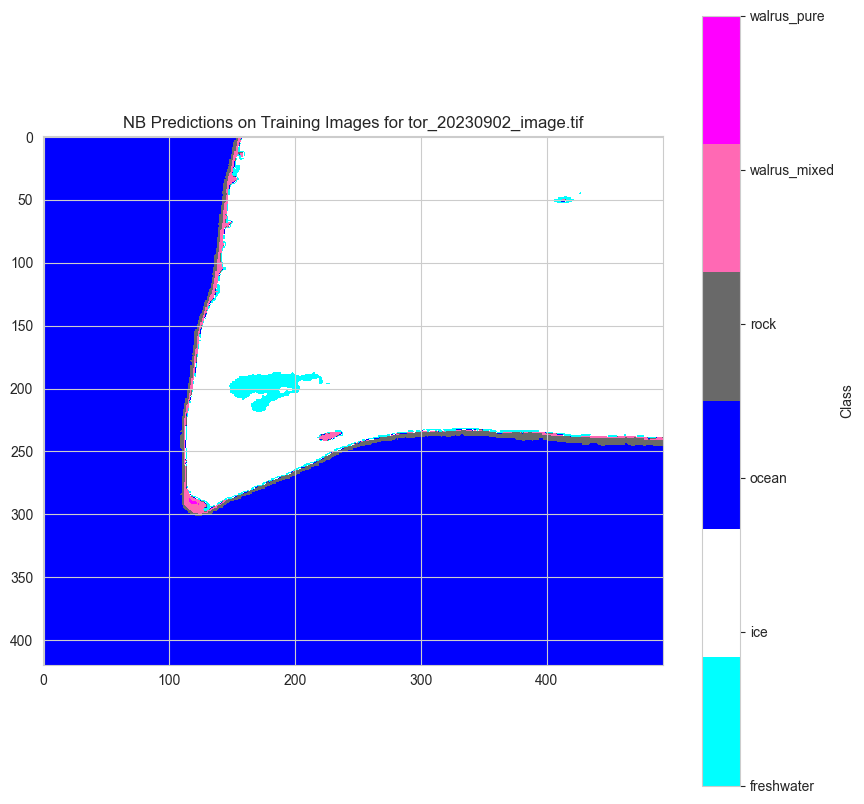

Labels present in buch_20230825_image.tif: ['freshwater', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


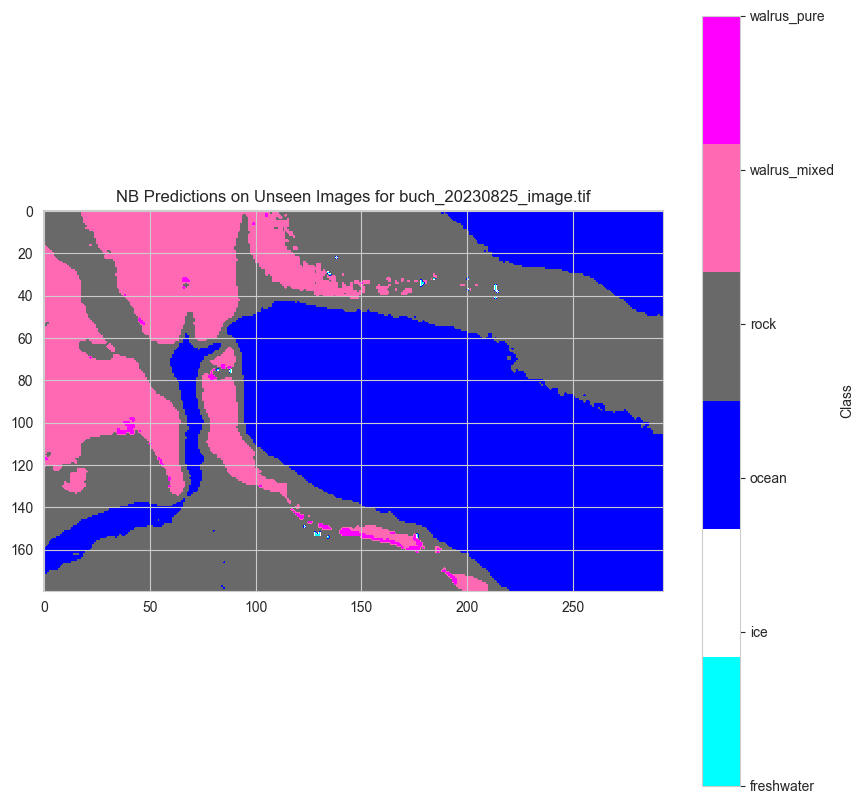

Labels present in buch_20230901_image.tif: ['freshwater', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


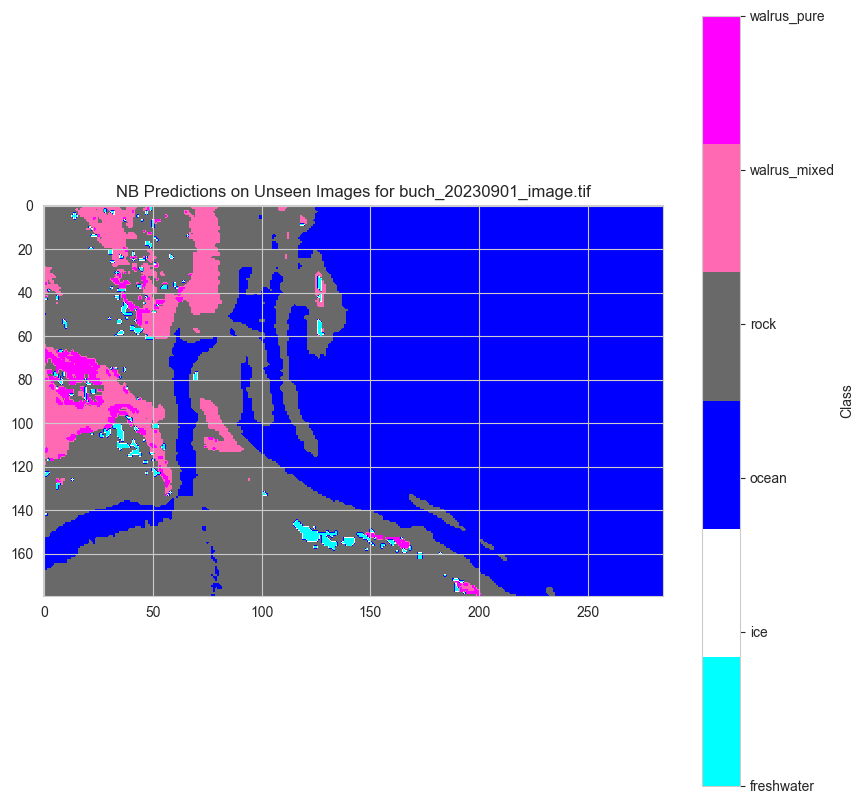

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


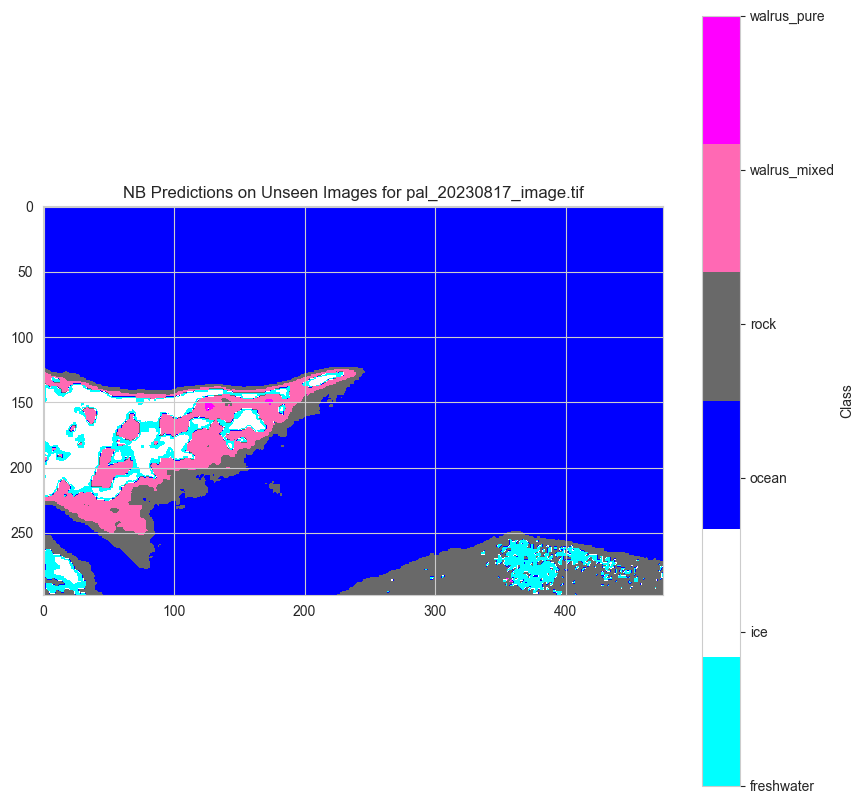

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


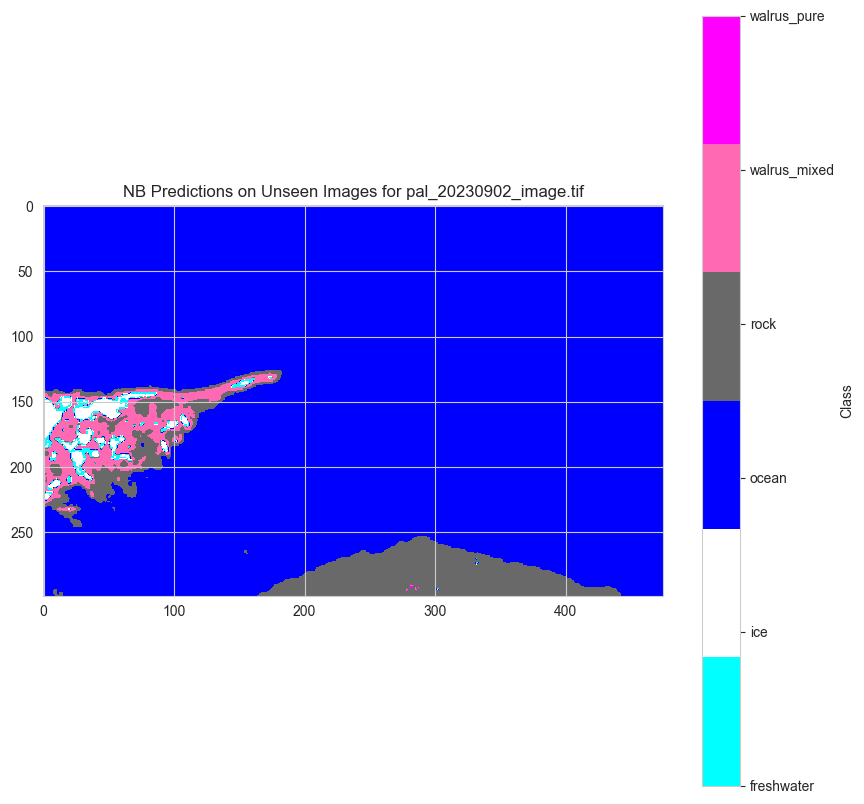

Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


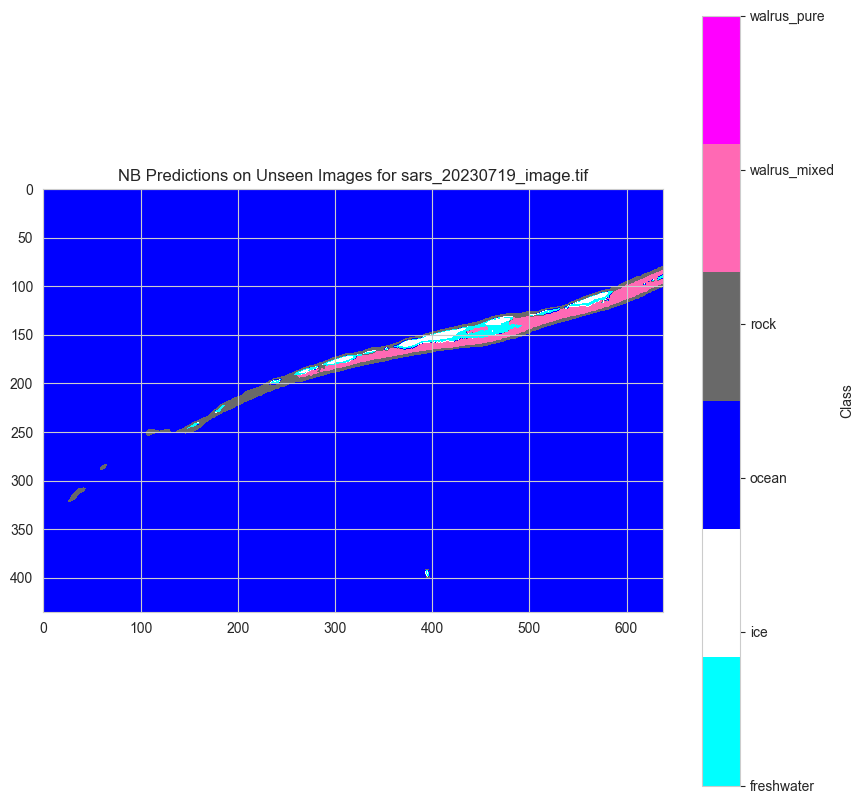

Labels present in sars_20230726.tif: ['freshwater', 'ocean', 'rock', 'walrus_mixed']


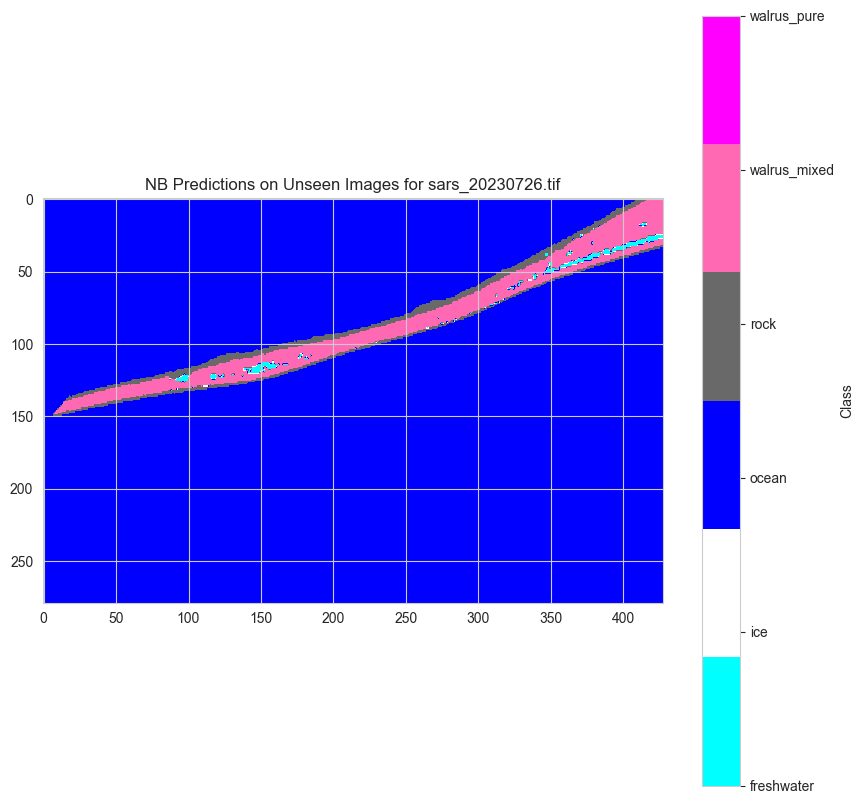

Labels present in sars_20230808_image.tif: ['ocean', 'rock', 'walrus_mixed']


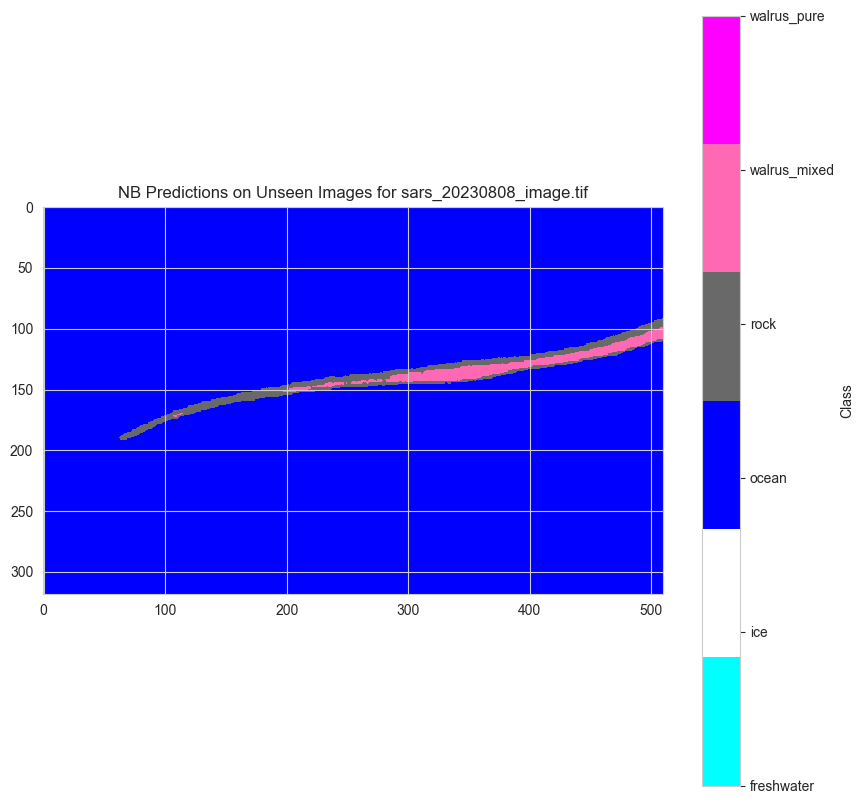

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


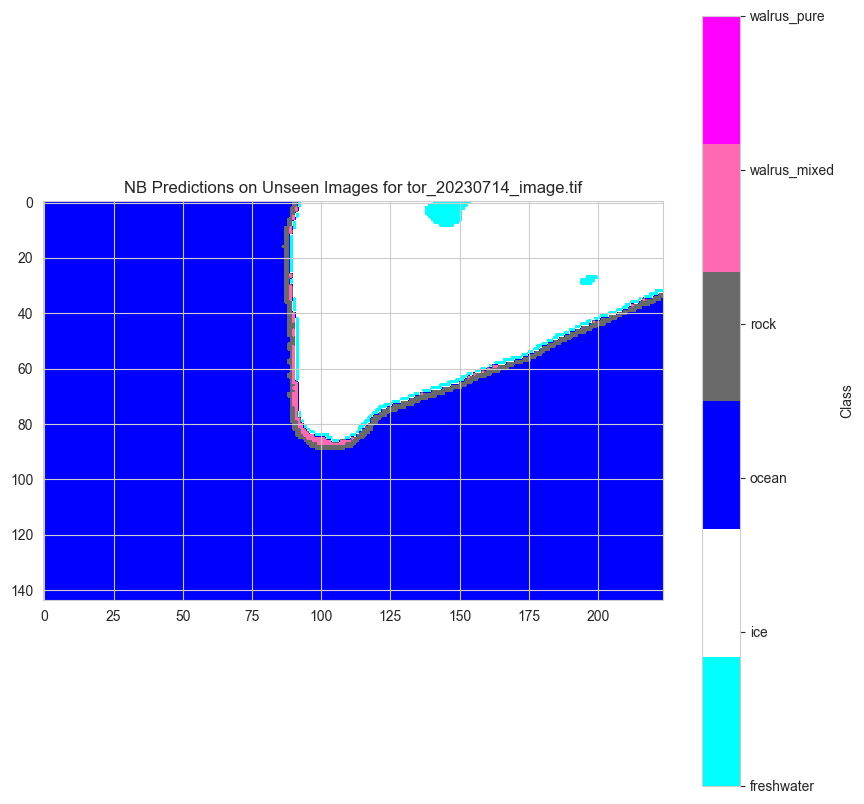

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


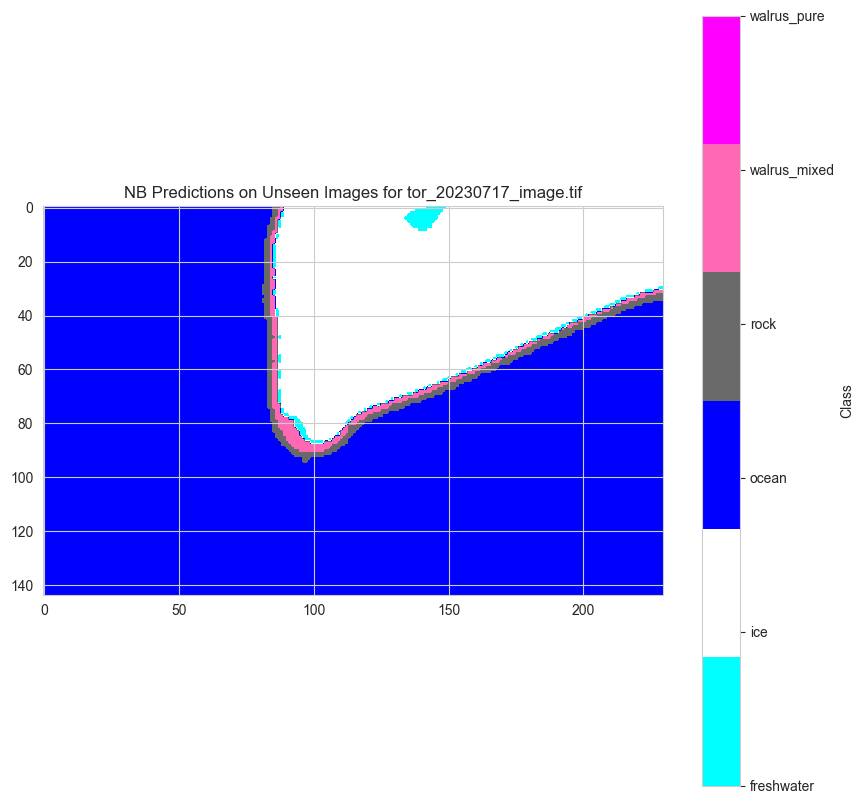

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


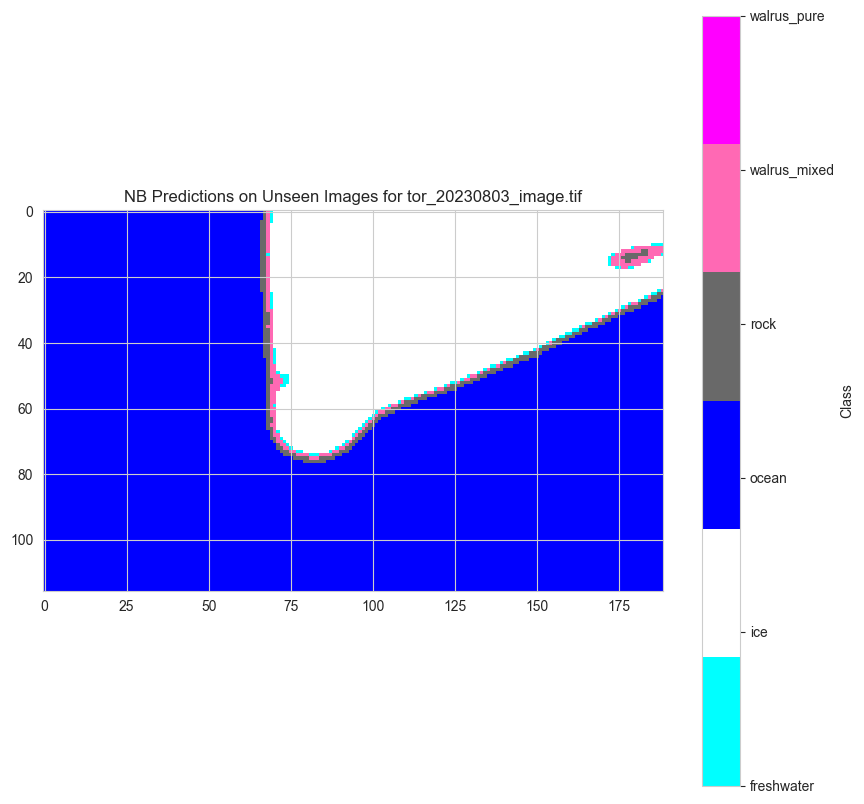

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


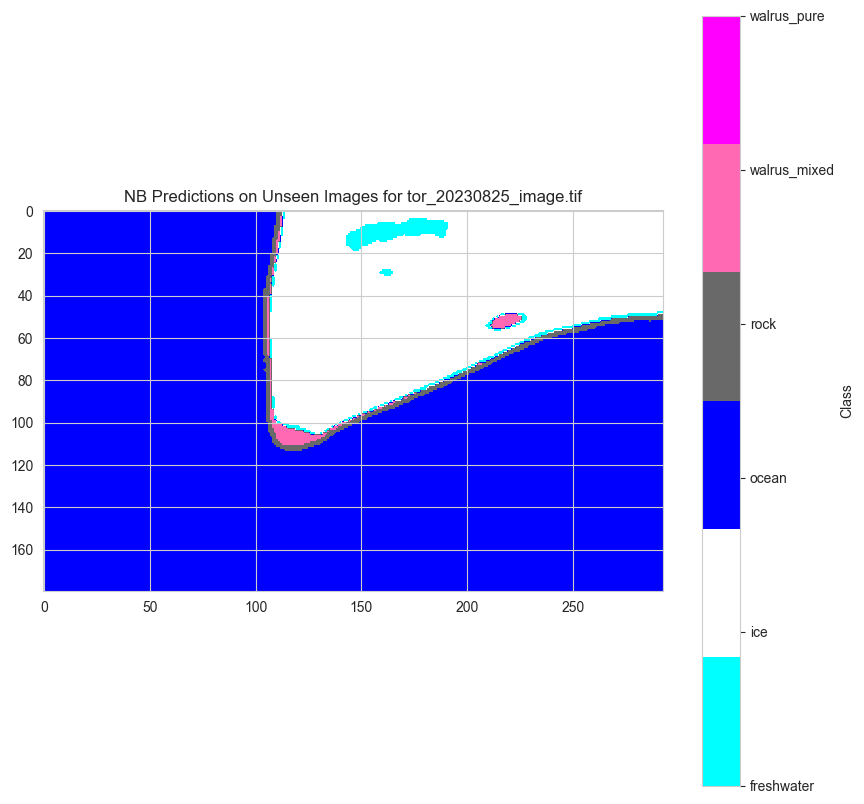

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


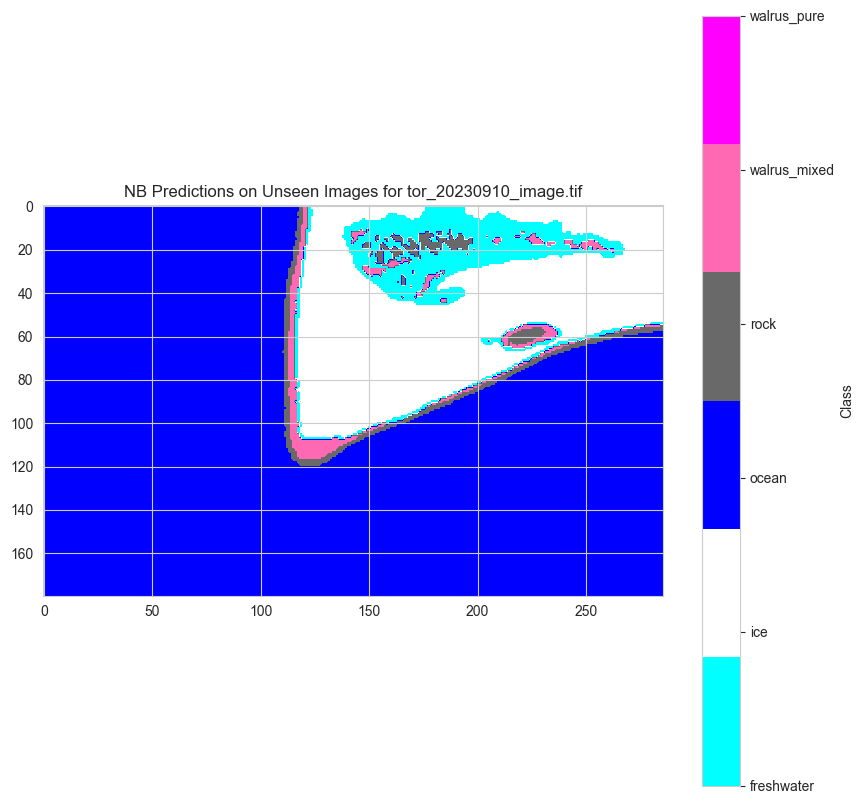


Training and evaluating model: SVM


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9680840543881335
Precision: 0.9671060471381282
Recall: 0.9680840543881335
F1 Score: 0.9643662327063061
Cohen's Kappa: 0.938067462110848

Classification Report:


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

  freshwater       0.88      0.41      0.56      8050
         ice       0.91      0.99      0.95     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.96      0.93      0.94     18572
walrus_mixed       0.00      0.00      0.00       165
 walrus_pure       0.00      0.00      0.00        10

    accuracy                           0.97    242700
   macro avg       0.62      0.55      0.57    242700
weighted avg       0.97      0.97      0.96    242700


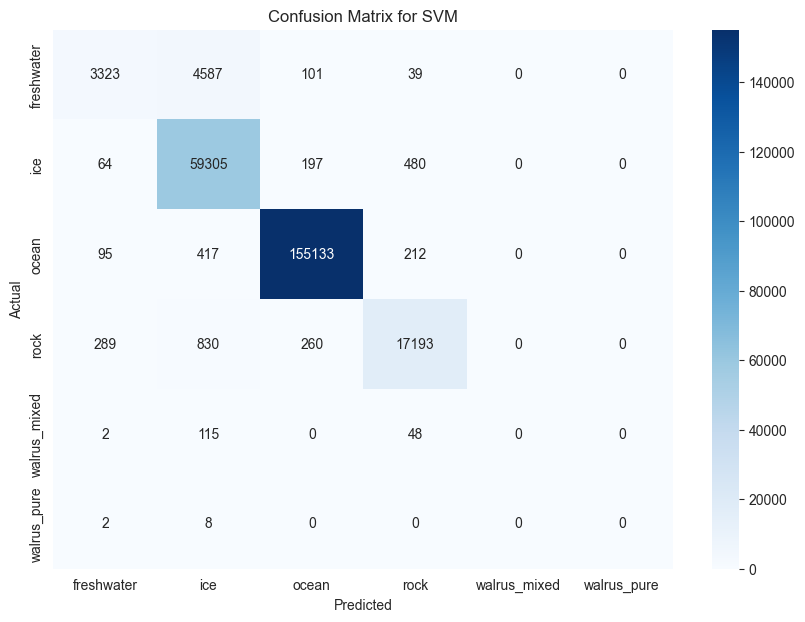

KeyboardInterrupt: 

In [11]:
# Train and evaluate each model
for name, model in models:
    print(f"\nTraining and evaluating model: {name}")
    model.fit(X_train, y_train)
    
    # Save the model
    model_filename = f"{name}_model.joblib"
    joblib.dump(model, model_filename)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Cohen's Kappa: {kappa}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    
    # Predict and plot results for training images
    predicted_images_train = {}
    for image_path, shapefile_path in file_pairs.items():
        predicted_images_train[image_path] = predict_image(image_path, model)
    
    plot_predictions(predicted_images_train, f"{name} Predictions on Training Images")
    
    # Predict and plot results for unseen images
    predicted_images_unseen = {}
    for image_path in unlabeled_image_paths:
        predicted_images_unseen[image_path] = predict_image(image_path, model)
    
    plot_predictions(predicted_images_unseen, f"{name} Predictions on Unseen Images")
